In [714]:
#Импотрирование необходимых библиотек 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor
import warnings
warnings.filterwarnings('ignore')

In [6]:
!nbstripout Untitled.ipynb

In [260]:
#Загрузка тренировочных данных
train_df = pd.read_csv("train.csv")

In [261]:
print(f"Размер датасета: {train_df.shape}")
train_df.head()

Размер датасета: (3000888, 6)


id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0

In [262]:
print(f"Минимальная дата: {np.min(pd.to_datetime(train_df["date"]))}", f"Максимальная дата: {np.max(pd.to_datetime(train_df["date"]))}", sep="\n")

Минимальная дата: 2013-01-01 00:00:00
Максимальная дата: 2017-08-15 00:00:00


In [263]:
#Загрузка тестовых данных
test_df = pd.read_csv("test.csv")

In [264]:
print(f"Размер датасета: {test_df.shape}")
test_df.head()

Размер датасета: (28512, 5)


id        date  store_nbr      family  onpromotion
0  3000888  2017-08-16          1  AUTOMOTIVE            0
1  3000889  2017-08-16          1   BABY CARE            0
2  3000890  2017-08-16          1      BEAUTY            2
3  3000891  2017-08-16          1   BEVERAGES           20
4  3000892  2017-08-16          1       BOOKS            0

In [265]:
print(f"Минимальная дата: {np.min(pd.to_datetime(test_df["date"]))}", f"Максимальная дата: {np.max(pd.to_datetime(test_df["date"]))}", sep="\n")

Минимальная дата: 2017-08-16 00:00:00
Максимальная дата: 2017-08-31 00:00:00


In [266]:
#Запишем индексы на всякий случай
train_index, test_index = np.array(train_df["id"]), np.array(test_df["id"])

In [267]:
#Загрузка данных о нефти
oil_df = pd.read_csv("oil.csv")

In [499]:
print(f"Размер датасета: {oil_df.shape}")
oil_df.head()

Размер датасета: (1218, 2)


date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20

In [269]:
#Загрузка данных с магазином
store_df = pd.read_csv("stores.csv")

In [270]:
print(f"Размер датасета: {store_df.shape}")
store_df.head()

Размер датасета: (54, 5)


store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [271]:
#Загрузка данных о праздниках
holiday_df = pd.read_csv("holidays_events.csv")

In [272]:
print(f"Размер датасета: {holiday_df.shape}")
holiday_df.head()

Размер датасета: (350, 6)


date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [273]:
#Видно, что для одной даты могут быть несколько празников
holiday_df["date"].value_counts().head()

date
2014-06-25    4
2012-06-25    3
2017-06-25    3
2013-06-25    3
2015-06-25    3
Name: count, dtype: int64

In [274]:
holiday_df[holiday_df["date"]=="2014-06-25"]

date     type    locale locale_name  \
110  2014-06-25  Holiday     Local   Latacunga   
111  2014-06-25  Holiday     Local     Machala   
112  2014-06-25  Holiday  Regional    Imbabura   
113  2014-06-25    Event  National     Ecuador   

                                   description  transferred  
110                 Cantonizacion de Latacunga        False  
111                       Fundacion de Machala        False  
112              Provincializacion de Imbabura        False  
113  Mundial de futbol Brasil: Ecuador-Francia        False

In [275]:
# Загрузка данных о операциях
transaction_df = pd.read_csv("transactions.csv")

In [276]:
print(f"Размер датасета: {transaction_df.shape}")
transaction_df.head()

Размер датасета: (83488, 3)


date  store_nbr  transactions
0  2013-01-01         25           770
1  2013-01-02          1          2111
2  2013-01-02          2          2358
3  2013-01-02          3          3487
4  2013-01-02          4          1922

In [277]:
#Объединим тренировочные и тестовые данные
df = pd.concat([train_df, test_df], axis=0)

In [278]:
print(f"Размер датасета: {df.shape}")
df.head()

Размер датасета: (3029400, 6)


id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0

In [279]:
#Присоединим к df oil_df через колонку date
df = pd.merge(left=df, right=oil_df, how="left", on="date")

In [280]:
#Присоединим к df store_df через колонку store_nbr
df = pd.merge(left=df, right=store_df, how="left", on="store_nbr")

In [281]:
#Присоединим к df transaction_df через колонки date и store_nbr
df = pd.merge(left=df, right=transaction_df, how="left", on=["date", "store_nbr"])

### holiday_df
- Для одной и той же даты, у нас могут быть разные праздники, поэтому присоединять правзники через merge некорректно
- Тогда закодируем празники, сделаем их бинарными

In [282]:
holiday_df.head()

date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [283]:
holiday_df["locale"].unique()

array(['Local', 'Regional', 'National'], dtype=object)

In [284]:
df["is_Local_event"] = 0
df["is_Regional_event"] = 0
df["is_National_event"] = 0

In [285]:
#Заполение колонки is_National_event единицами, там, где совпадает дата
date_National_event = holiday_df[holiday_df["locale"]=="National"]["date"]

df.loc[df["date"].isin(date_National_event.unique()), "is_National_event"] = 1

In [286]:
#Заполним колонку is_Regional_event единицами, если совпадает дата и регион
date_state_Regional_event = holiday_df[holiday_df["locale"]=="Regional"][["locale_name", "date"]]

for i in range(len(date_state_Regional_event)):
    df.loc[(df["state"]==date_state_Regional_event["locale_name"].iloc[i]) & (df["date"]==date_state_Regional_event["date"].iloc[i]), "is_Regional_event"] = 1

In [287]:
#Заполним колонку is_Local_event единицами, если совпадает дата и город
date_city_Local_event = holiday_df[holiday_df["locale"]=="Local"][["locale_name", "date"]]

for i in range(len(date_city_Local_event)):
    df.loc[(df["city"]==date_city_Local_event["locale_name"].iloc[i]) & (df["date"]==date_city_Local_event["date"].iloc[i]), "is_Local_event"] = 1

### holiday_df
- Также стоит отметить, что в датасете holiday_df, есть колонка description, в которой написаны описание праздников
- Также извлечем оттуда информацию

In [288]:
#Создадим 3 колонки description_event
df["description_National_event"] = np.nan
df["description_Regional_event"] = np.nan
df["description_Local_event"] = np.nan

In [289]:
#Заполним колонку description_event для национальных праздников
description_National_event = holiday_df[holiday_df["locale"]=="National"][["date", "description"]]

df["description_National_event"] = pd.merge(left=df, right=description_National_event, how="left", on="date")["description"]

In [290]:
#Заполним колонку description_event для национальных праздников
description_Regional_event = holiday_df[holiday_df["locale"]=="Regional"][["date", "description"]]

df["description_Regional_event"] = pd.merge(left=df, right=description_Regional_event, how="left", on="date")["description"]

In [291]:
#Заполним колонку description_event для национальных праздников
description_Local_event = holiday_df[holiday_df["locale"]=="Local"][["date", "description"]]

df["description_Local_event"] = pd.merge(left=df, right=description_Local_event, how="left", on="date")["description"]

In [292]:
#Заполняем пропуски
df["description_National_event"] = df["description_National_event"].fillna("No_Event")
df["description_Regional_event"] = df["description_Regional_event"].fillna("No_Event")
df["description_Local_event"] = df["description_Local_event"].fillna("No_Event")

In [293]:
df["family"].nunique()

33

In [294]:
df["store_nbr"].nunique()

54

### Результат
- Все колонки были присоединены, теперь можно начинать eda анализ

In [295]:
df.head()

id        date  store_nbr      family  sales  onpromotion  dcoilwtico  \
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0         NaN   
1   1  2013-01-01          1   BABY CARE    0.0            0         NaN   
2   2  2013-01-01          1      BEAUTY    0.0            0         NaN   
3   3  2013-01-01          1   BEVERAGES    0.0            0         NaN   
4   4  2013-01-01          1       BOOKS    0.0            0         NaN   

    city      state type  cluster  transactions  is_Local_event  \
0  Quito  Pichincha    D       13           NaN               0   
1  Quito  Pichincha    D       13           NaN               0   
2  Quito  Pichincha    D       13           NaN               0   
3  Quito  Pichincha    D       13           NaN               0   
4  Quito  Pichincha    D       13           NaN               0   

   is_Regional_event  is_National_event description_National_event  \
0                  0                  1         Primer dia del ano   
1                  0                  1         Primer dia del ano   
2                  0                  1         Primer dia del ano   
3                  0                  1         Primer dia del ano   
4                  0                  1         Primer dia del ano   

  description_Regional_event description_Local_event  
0                   No_Event                No_Event  
1                   No_Event                No_Event  
2                   No_Event                No_Event  
3                   No_Event                No_Event  
4                   No_Event                No_Event

In [296]:
print(f"Количество колонок: {df.shape[1]}", f"Количество объектов: {df.shape[0]}", sep="\n")

Количество колонок: 18
Количество объектов: 3029400


In [297]:
#Общая информация
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3029400 entries, 0 to 3029399
Data columns (total 18 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   id                          int64  
 1   date                        object 
 2   store_nbr                   int64  
 3   family                      object 
 4   sales                       float64
 5   onpromotion                 int64  
 6   dcoilwtico                  float64
 7   city                        object 
 8   state                       object 
 9   type                        object 
 10  cluster                     int64  
 11  transactions                float64
 12  is_Local_event              int64  
 13  is_Regional_event           int64  
 14  is_National_event           int64  
 15  description_National_event  object 
 16  description_Regional_event  object 
 17  description_Local_event     object 
dtypes: float64(3), int64(7), object(8)
memory usage: 416.0+ MB


In [298]:
#Посмотрим на количество пропусков
df.isna().sum()

id                                 0
date                               0
store_nbr                          0
family                             0
sales                          28512
onpromotion                        0
dcoilwtico                    935550
city                               0
state                              0
type                               0
cluster                            0
transactions                  274296
is_Local_event                     0
is_Regional_event                  0
is_National_event                  0
description_National_event         0
description_Regional_event         0
description_Local_event            0
dtype: int64

In [299]:
df.set_index("id", inplace=True)

In [300]:
df.describe()

store_nbr         sales   onpromotion    dcoilwtico       cluster  \
count  3.029400e+06  3.000888e+06  3.029400e+06  2.093850e+06  3.029400e+06   
mean   2.750000e+01  3.577757e+02  2.643830e+00  6.771437e+01  8.481481e+00   
std    1.558579e+01  1.101998e+03  1.233287e+01  2.561957e+01  4.649735e+00   
min    1.000000e+00  0.000000e+00  0.000000e+00  2.619000e+01  1.000000e+00   
25%    1.400000e+01  0.000000e+00  0.000000e+00  4.640000e+01  4.000000e+00   
50%    2.750000e+01  1.100000e+01  0.000000e+00  5.319000e+01  8.500000e+00   
75%    4.100000e+01  1.958473e+02  0.000000e+00  9.571000e+01  1.300000e+01   
max    5.400000e+01  1.247170e+05  7.410000e+02  1.106200e+02  1.700000e+01   

       transactions  is_Local_event  is_Regional_event  is_National_event  
count  2.755104e+06    3.029400e+06       3.029400e+06       3.029400e+06  
mean   1.694602e+03    4.063181e-03       3.376906e-04       8.411765e-02  
std    9.632810e+02    6.361346e-02       1.837326e-02       2.775642e-01  
min    5.000000e+00    0.000000e+00       0.000000e+00       0.000000e+00  
25%    1.046000e+03    0.000000e+00       0.000000e+00       0.000000e+00  
50%    1.393000e+03    0.000000e+00       0.000000e+00       0.000000e+00  
75%    2.079000e+03    0.000000e+00       0.000000e+00       0.000000e+00  
max    8.359000e+03    1.000000e+00       1.000000e+00       1.000000e+00

In [301]:
#Посмотрим на дубликаты
print(f"Количество дубликатов: {df.duplicated().sum()}")

Количество дубликатов: 0


In [302]:
#Разделение колонок на вещественные и категориальные

df_num_columns = pd.concat([df["date"], df[df.columns[df.dtypes != object]]], axis=1)
df_cat_columns = pd.concat([df[df.columns[df.dtypes == object]], df["sales"]], axis=1)

print(f"Всего колонок: {df_num_columns.shape[1] + df_cat_columns.shape[1] - 2}")

Всего колонок: 17


### Анализ вещественных колонок

In [303]:
df_num_columns.head()

date  store_nbr  sales  onpromotion  dcoilwtico  cluster  \
id                                                                   
0   2013-01-01          1    0.0            0         NaN       13   
1   2013-01-01          1    0.0            0         NaN       13   
2   2013-01-01          1    0.0            0         NaN       13   
3   2013-01-01          1    0.0            0         NaN       13   
4   2013-01-01          1    0.0            0         NaN       13   

    transactions  is_Local_event  is_Regional_event  is_National_event  
id                                                                      
0            NaN               0                  0                  1  
1            NaN               0                  0                  1  
2            NaN               0                  0                  1  
3            NaN               0                  0                  1  
4            NaN               0                  0                  1

In [304]:
#Напишем вспомогательный словарик, для перевода колонок
dict_num_features_description = {
    "date": "Дата",
    "store_nbr": "Номер магазина",
    "sales": "Цена",
    "onpromotion": "Промо-акции",
    "dcoilwtico": "Цена на нефть",
    "cluster": "Группа похожих магазинов, к которой относится данный магазин",
    "transactions": "Общее количество чеков за конкретный день",
    "is_Local_event": "Наличие локального праздника",
    "is_Regional_event": "Наличие регионального праздника",
    "is_National_event": "Наличие национального праздника"
}

### Посмотрим распределение признаков с помощью boxplot

In [305]:
def drow_boxplot(df, col, description):
    print("-------------------------------------------")
    print(df[col].describe())
    print("-------------------------------------------")
    fig = plt.figure(figsize=(5, 4), dpi=250)
    plt.title(description)
    sns.boxplot(data=df, y=col, color="pink")
    plt.show()

-------------------------------------------
count    3.029400e+06
mean     2.643830e+00
std      1.233287e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      7.410000e+02
Name: onpromotion, dtype: float64
-------------------------------------------


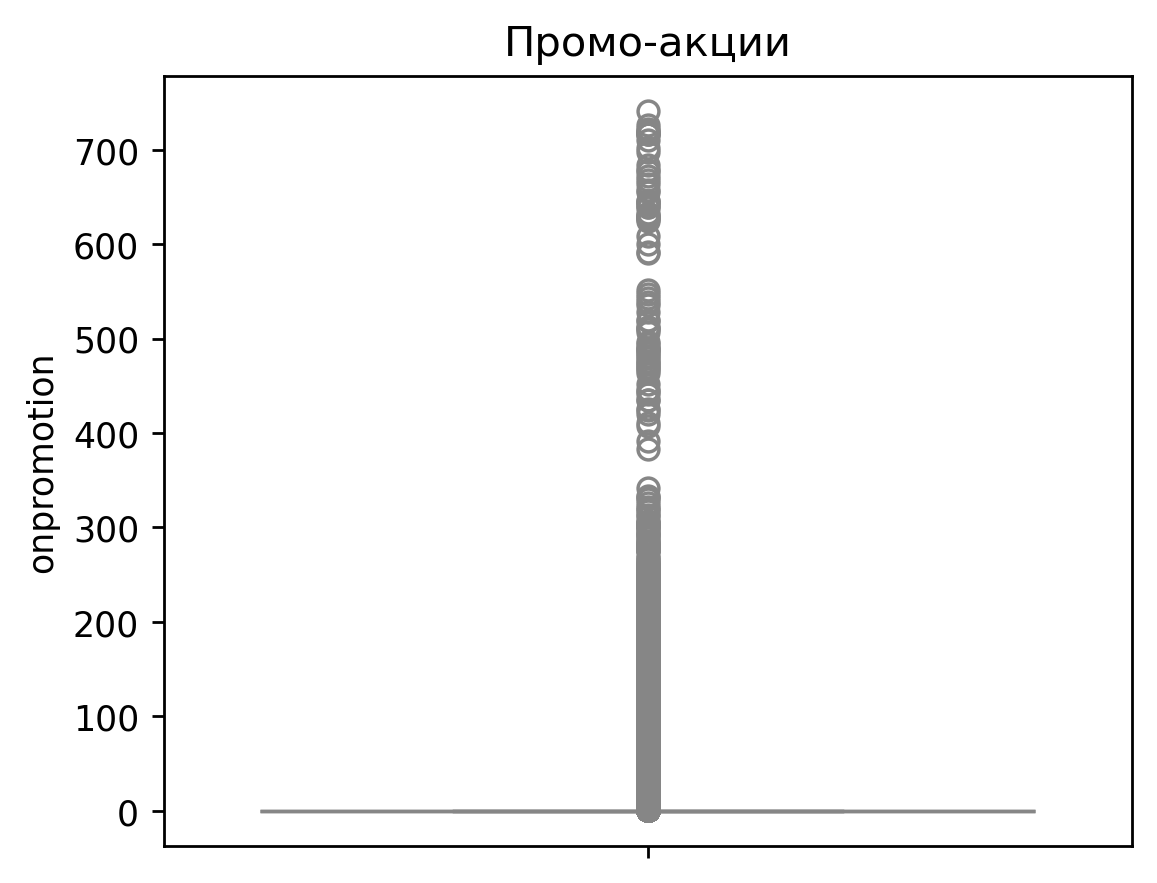

-------------------------------------------
count    2.093850e+06
mean     6.771437e+01
std      2.561957e+01
min      2.619000e+01
25%      4.640000e+01
50%      5.319000e+01
75%      9.571000e+01
max      1.106200e+02
Name: dcoilwtico, dtype: float64
-------------------------------------------


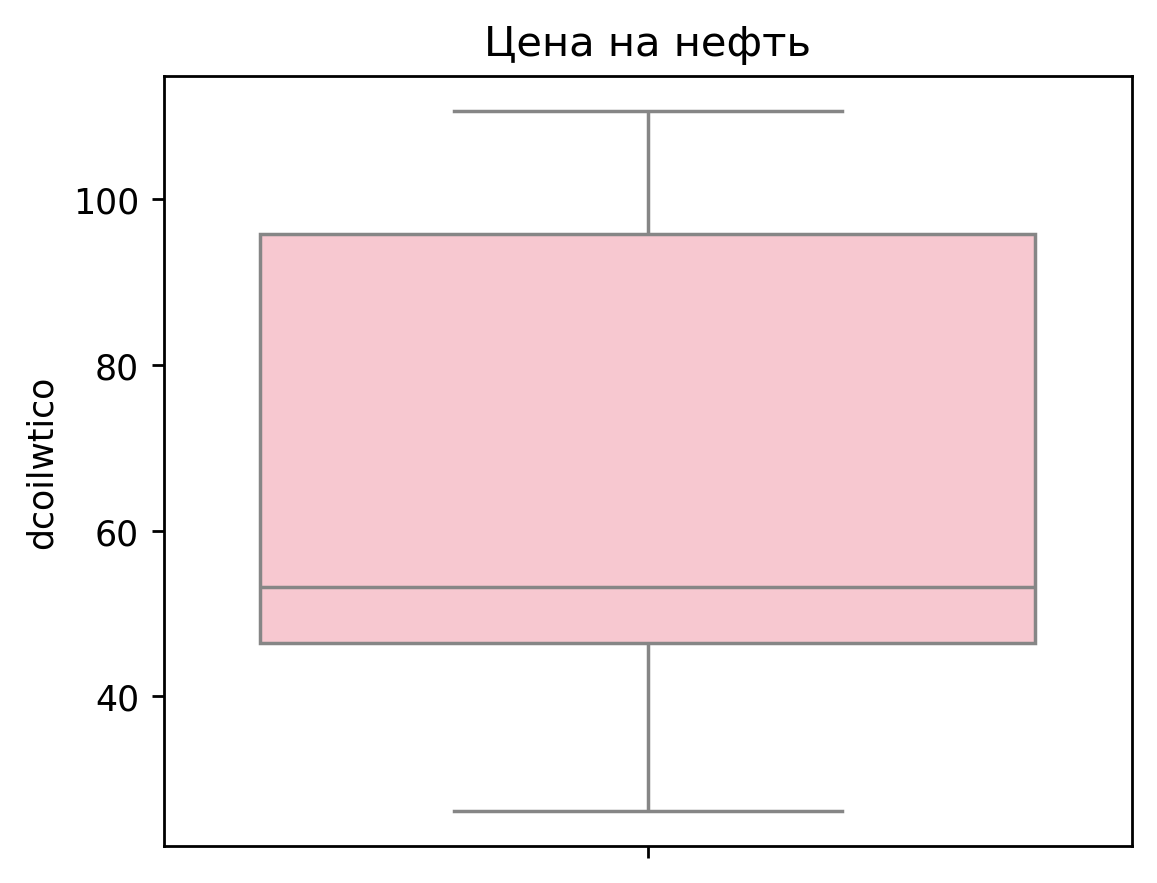

-------------------------------------------
count    2.755104e+06
mean     1.694602e+03
std      9.632810e+02
min      5.000000e+00
25%      1.046000e+03
50%      1.393000e+03
75%      2.079000e+03
max      8.359000e+03
Name: transactions, dtype: float64
-------------------------------------------


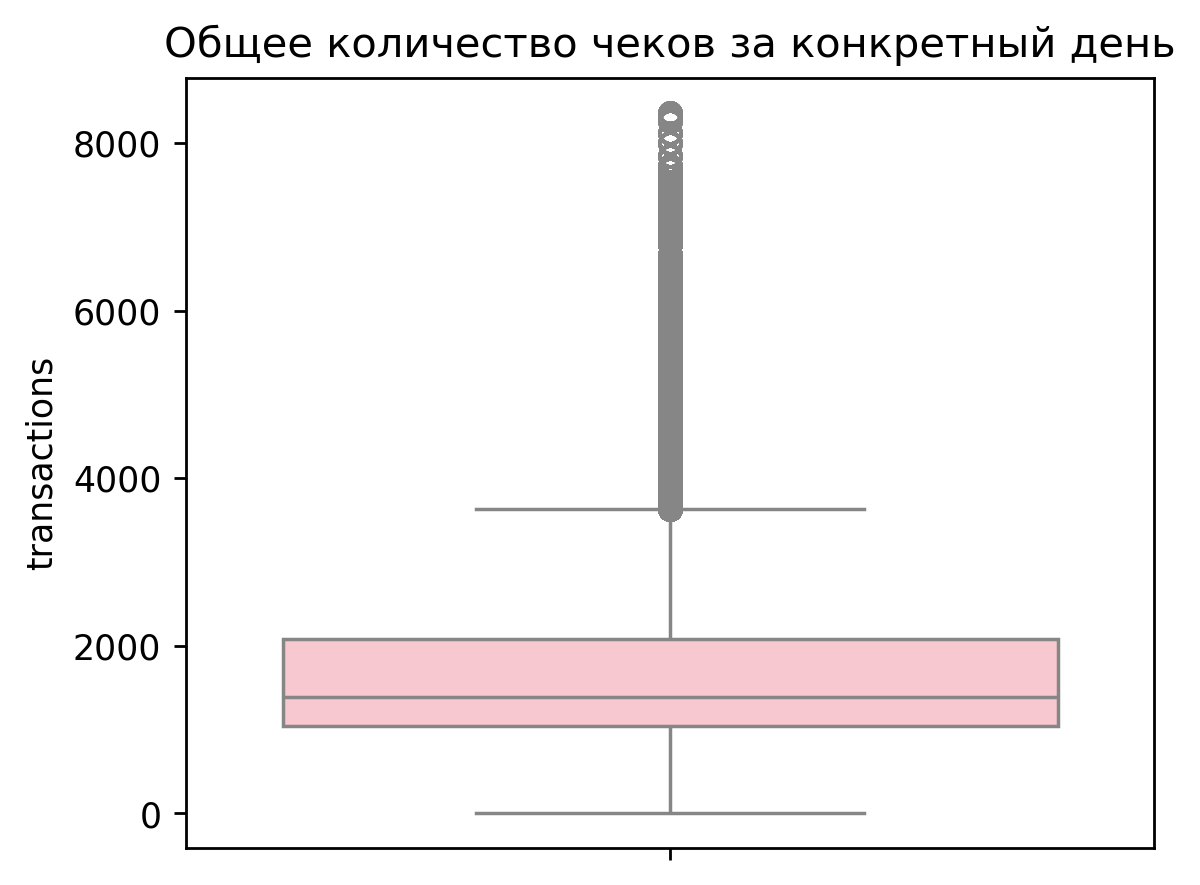

-------------------------------------------
count    3.029400e+06
mean     8.481481e+00
std      4.649735e+00
min      1.000000e+00
25%      4.000000e+00
50%      8.500000e+00
75%      1.300000e+01
max      1.700000e+01
Name: cluster, dtype: float64
-------------------------------------------


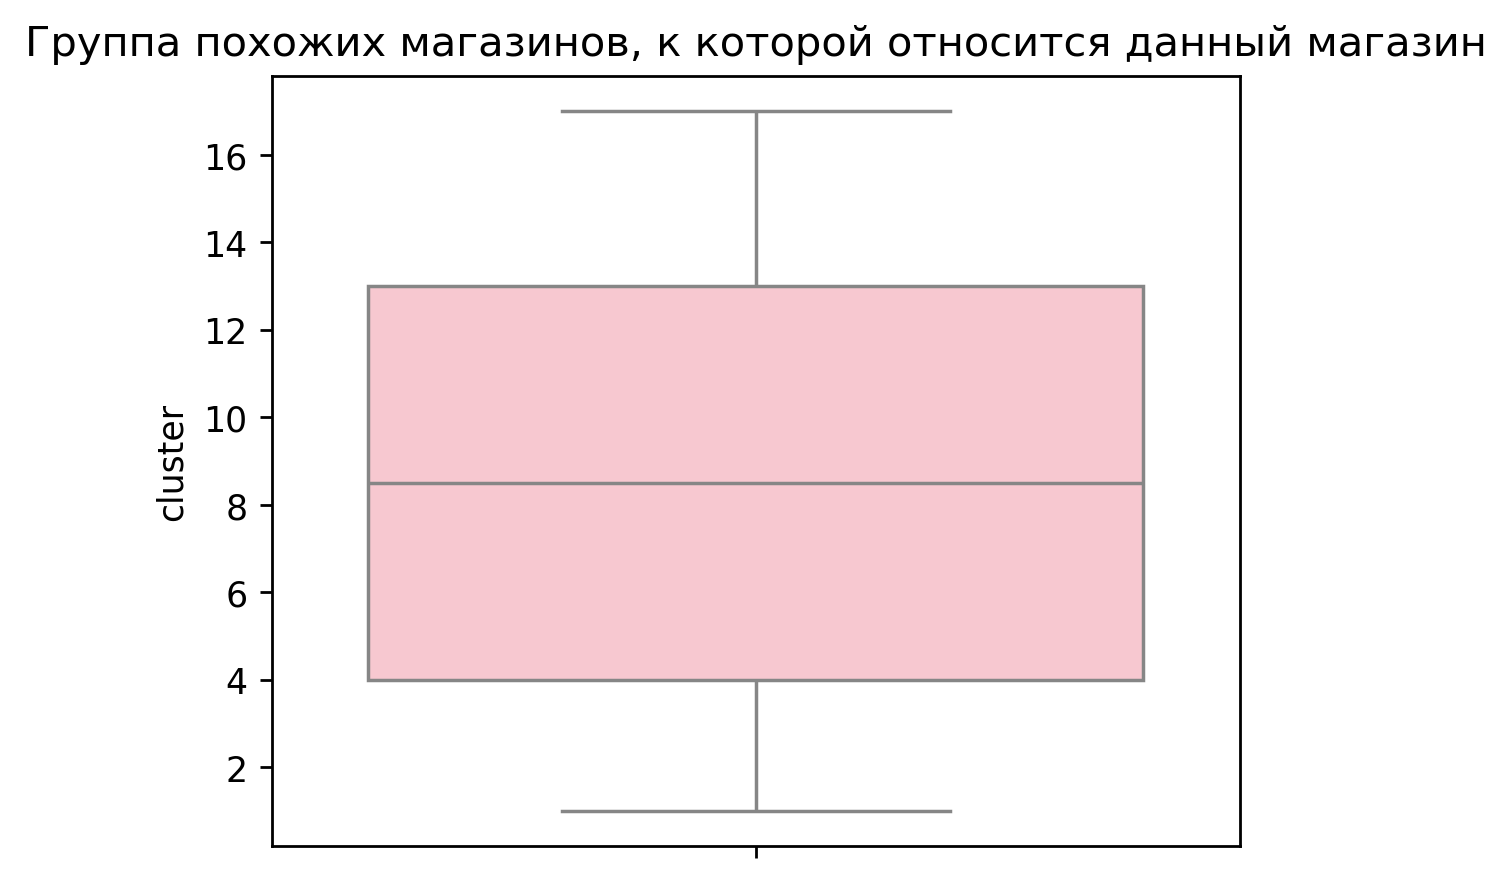

In [306]:
for col in ["onpromotion", "dcoilwtico", "transactions", "cluster"]:
    drow_boxplot(df_num_columns, col, dict_num_features_description[col])

### Результат
- Выбросов нет

In [307]:
#Посмотрим на пропуски
df_num_columns.isna().sum()

date                      0
store_nbr                 0
sales                 28512
onpromotion               0
dcoilwtico           935550
cluster                   0
transactions         274296
is_Local_event            0
is_Regional_event         0
is_National_event         0
dtype: int64

In [308]:
#Заполним пропуски нефти, с помощью заполнением предыдущим и будующим значением
df_num_columns["dcoilwtico"].fillna(method="ffill", inplace=True)
df_num_columns["dcoilwtico"].fillna(method="bfill", inplace=True)
print(f"Количество пропусков в колонке: {df_num_columns["dcoilwtico"].isna().sum()}")

Количество пропусков в колонке: 0


In [309]:
#Заполним пропуски в колонке transactions с помощью KNN
not_null_index = df_num_columns[df_num_columns["transactions"].notna()].index
null_index = df_num_columns[df_num_columns["transactions"].isnull()].index

X_fill = df_num_columns.loc[not_null_index][["store_nbr", "onpromotion", "dcoilwtico"]]
y_fill = df_num_columns.loc[not_null_index]["transactions"]

X_missing = df_num_columns.loc[null_index][["store_nbr", "onpromotion", "dcoilwtico"]]

fillna_model = KNeighborsRegressor(n_neighbors=8, n_jobs=-1)
fillna_model.fit(X_fill, y_fill)

df_num_columns.loc[null_index, "transactions"] = np.int16(fillna_model.predict(X_missing))

print("Пропуски заполнены!")

Пропуски заполнены!


In [310]:
print(f"Всего пропусков: {df_num_columns.drop("sales", axis=1).isna().sum().sum()}")

Всего пропусков: 0


In [311]:
def drow_countplot(df, col, description):
    print("---------------------------------------------------")
    print(f"Ассимметрия равна {df[col].skew()}")
    print(f"Эксцесс равен {df[col].kurt()}")
    print("---------------------------------------------------")
    fig = plt.figure(figsize=(8, 6.5), dpi=250)
    plt.title(description)
    sns.histplot(data=df, x=col)
    plt.show()

---------------------------------------------------
Ассимметрия равна 7.358757818882655
Эксцесс равен 154.5620923696481
---------------------------------------------------


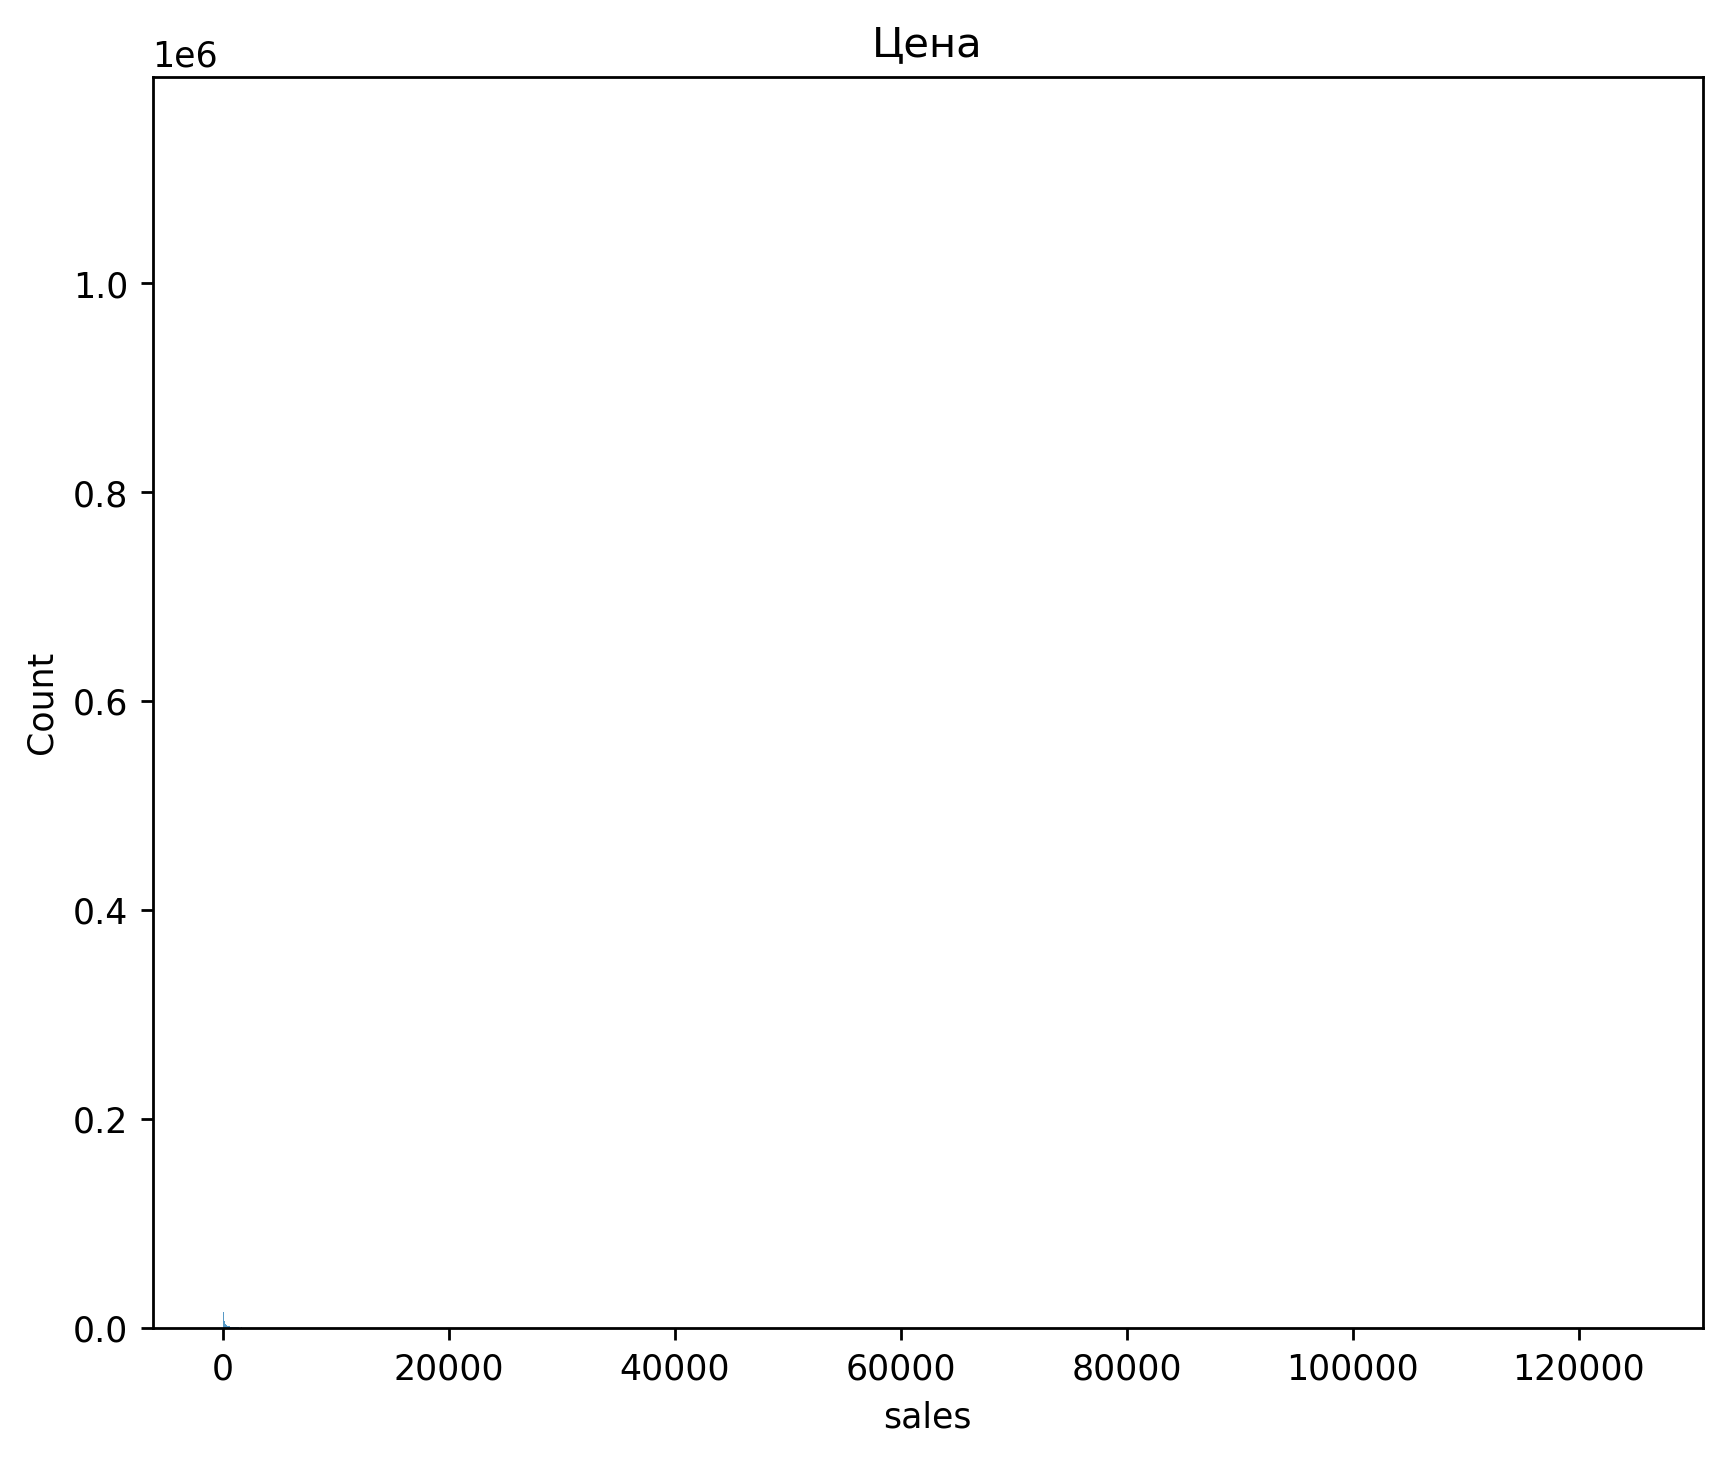

---------------------------------------------------
Ассимметрия равна 11.153282330297108
Эксцесс равен 239.76101014841117
---------------------------------------------------


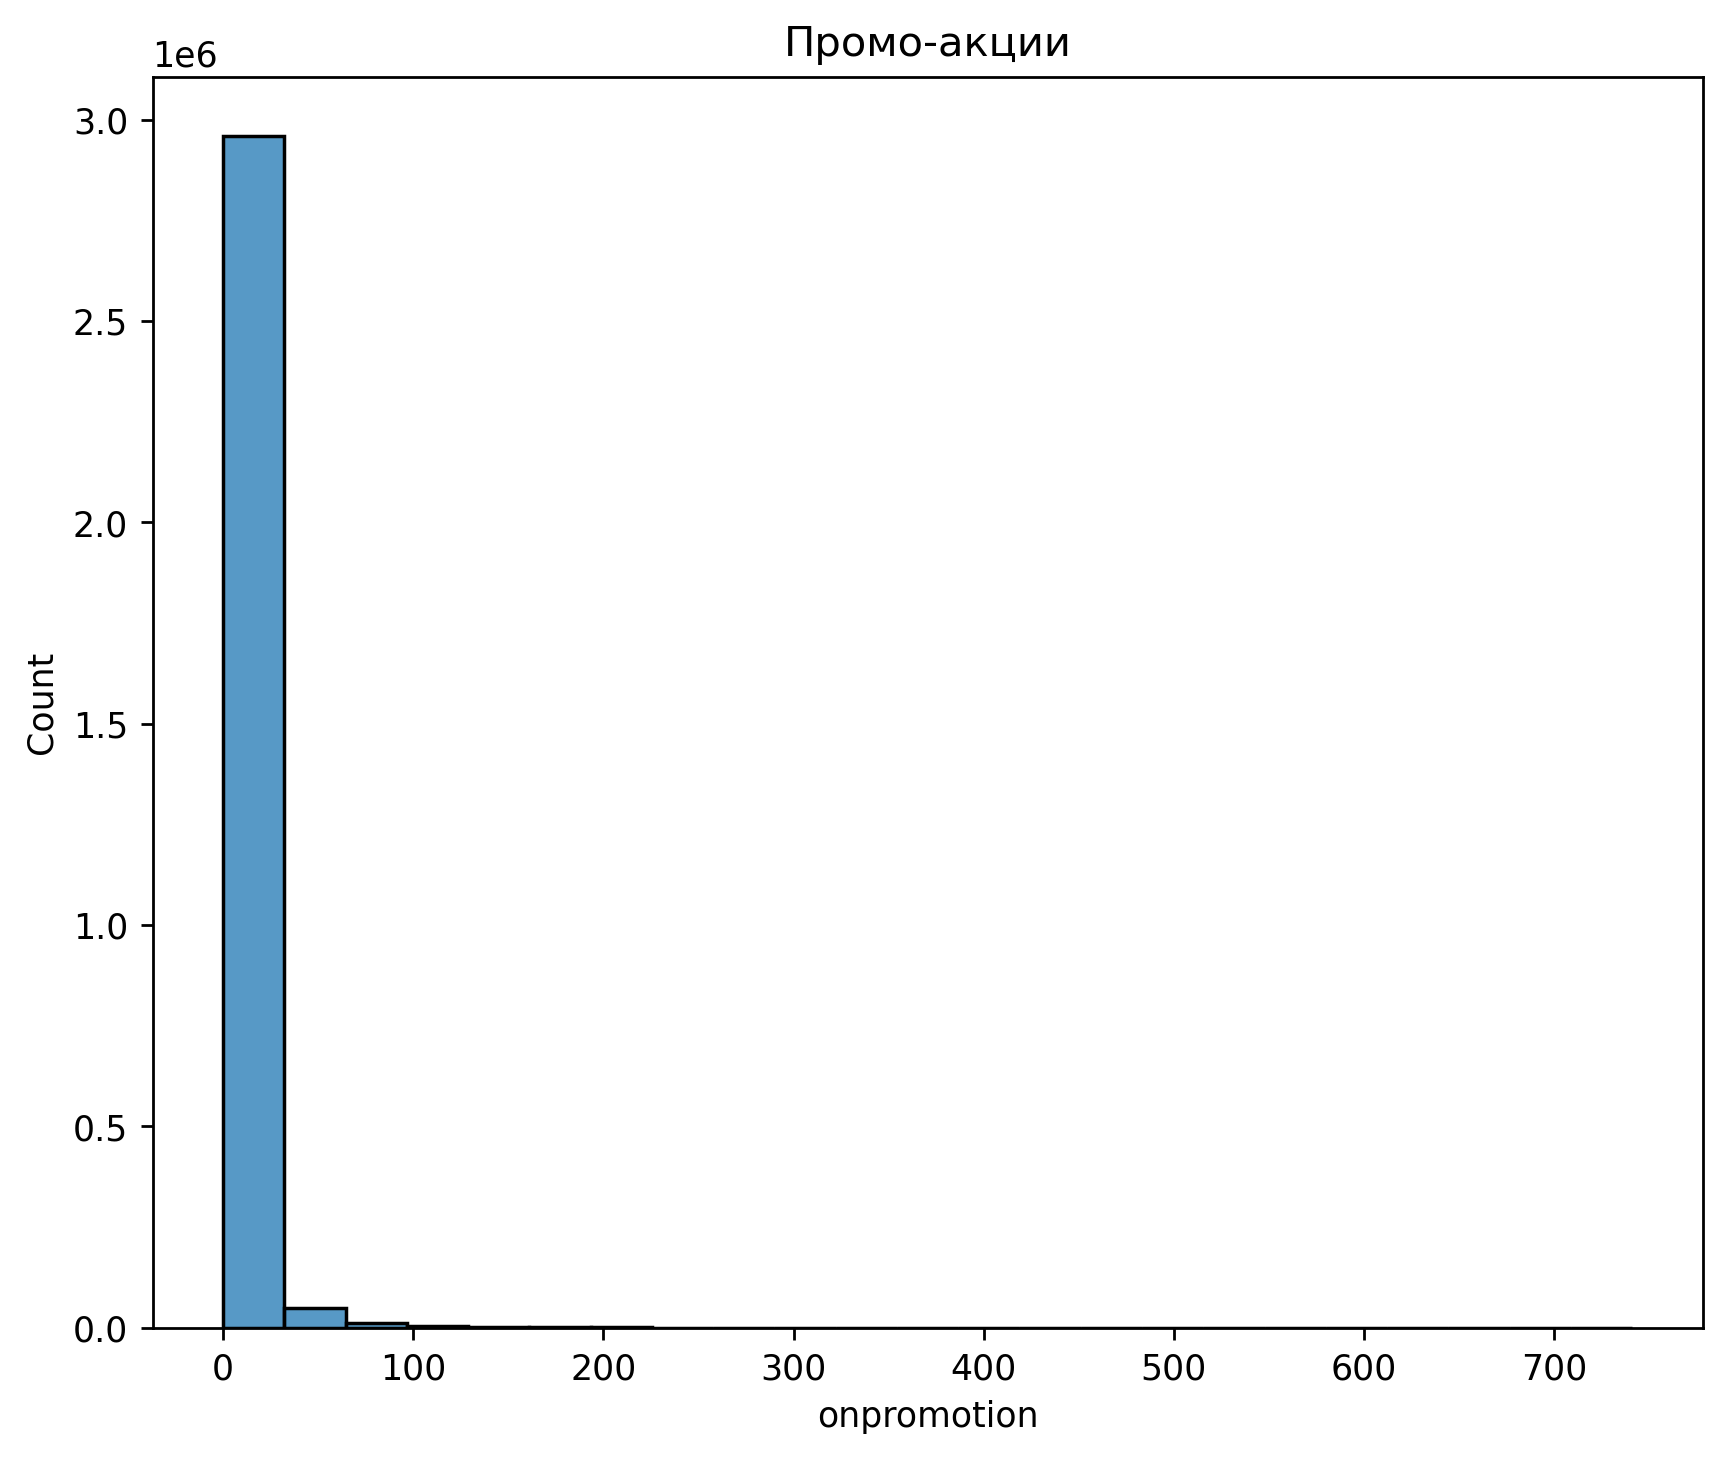

---------------------------------------------------
Ассимметрия равна 0.32203221727041026
Эксцесс равен -1.6086455318056685
---------------------------------------------------


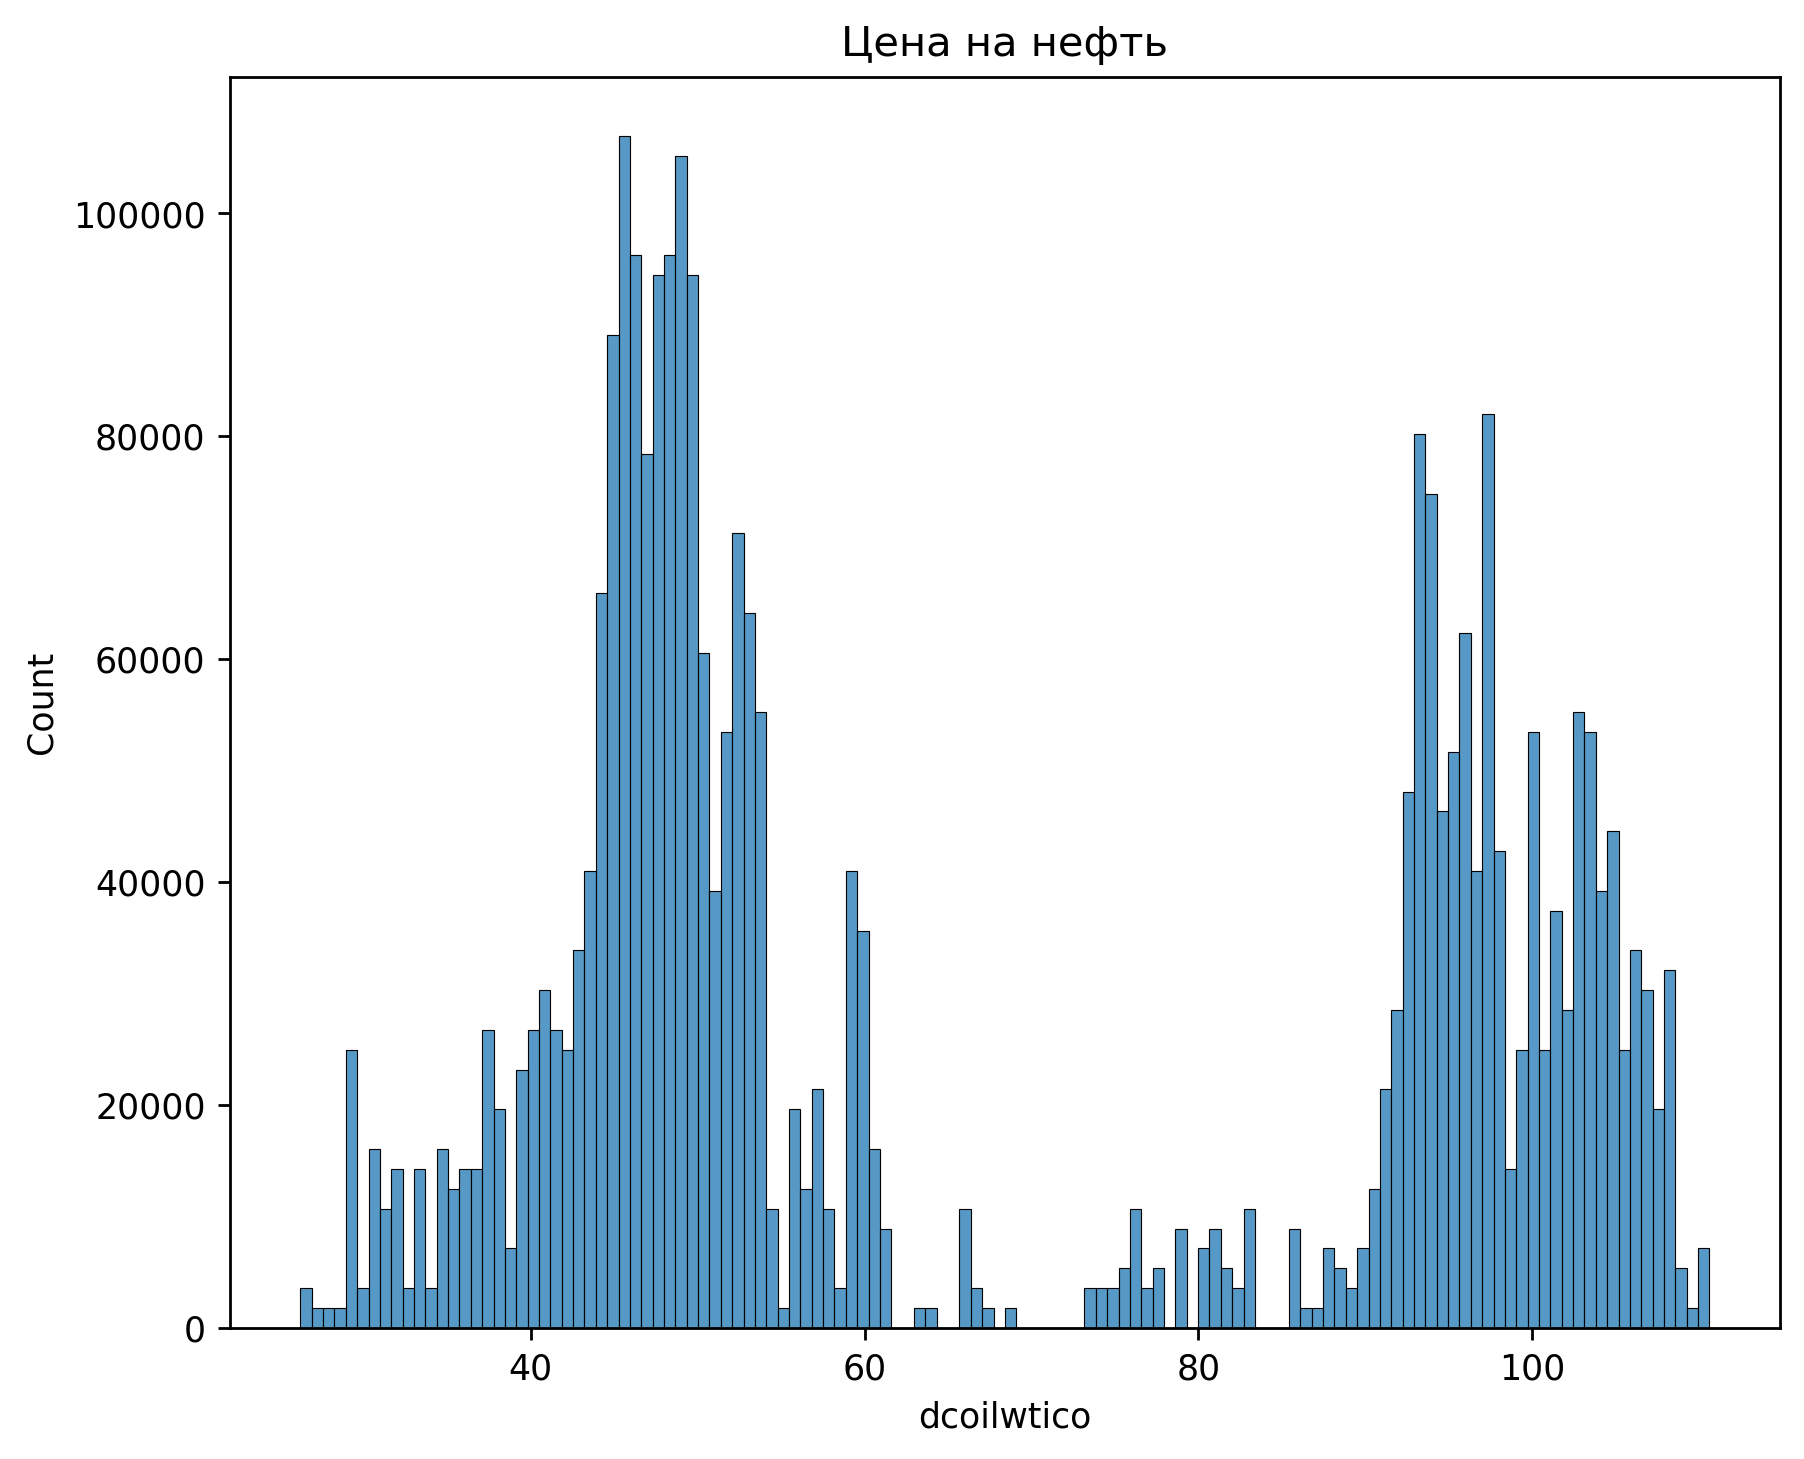

---------------------------------------------------
Ассимметрия равна 0.040086837148273054
Эксцесс равен -1.2562449309588373
---------------------------------------------------


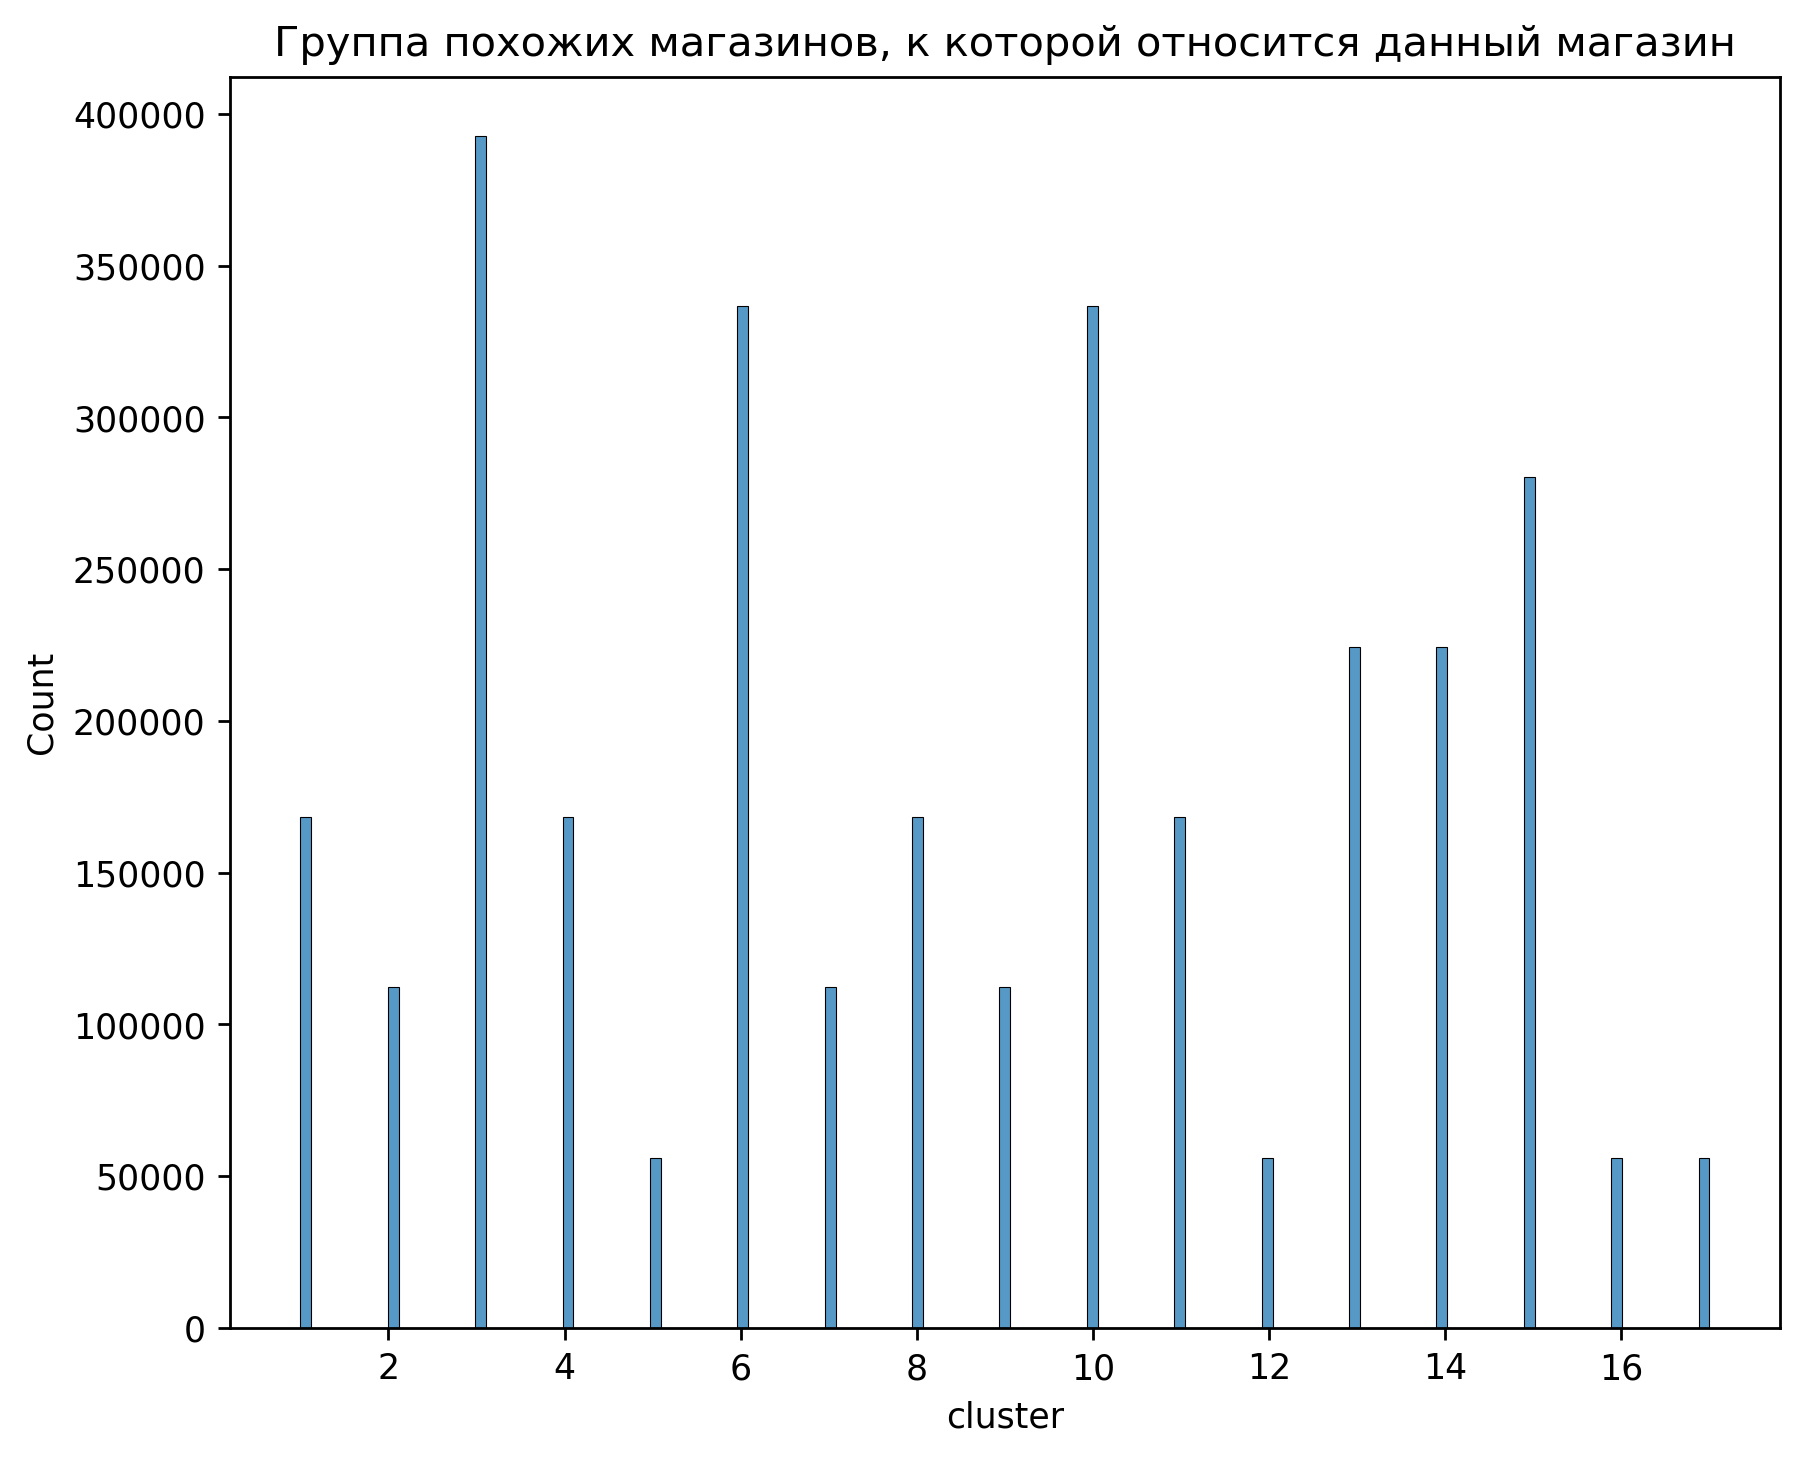

---------------------------------------------------
Ассимметрия равна 1.590246988096825
Эксцесс равен 2.8904619408606598
---------------------------------------------------


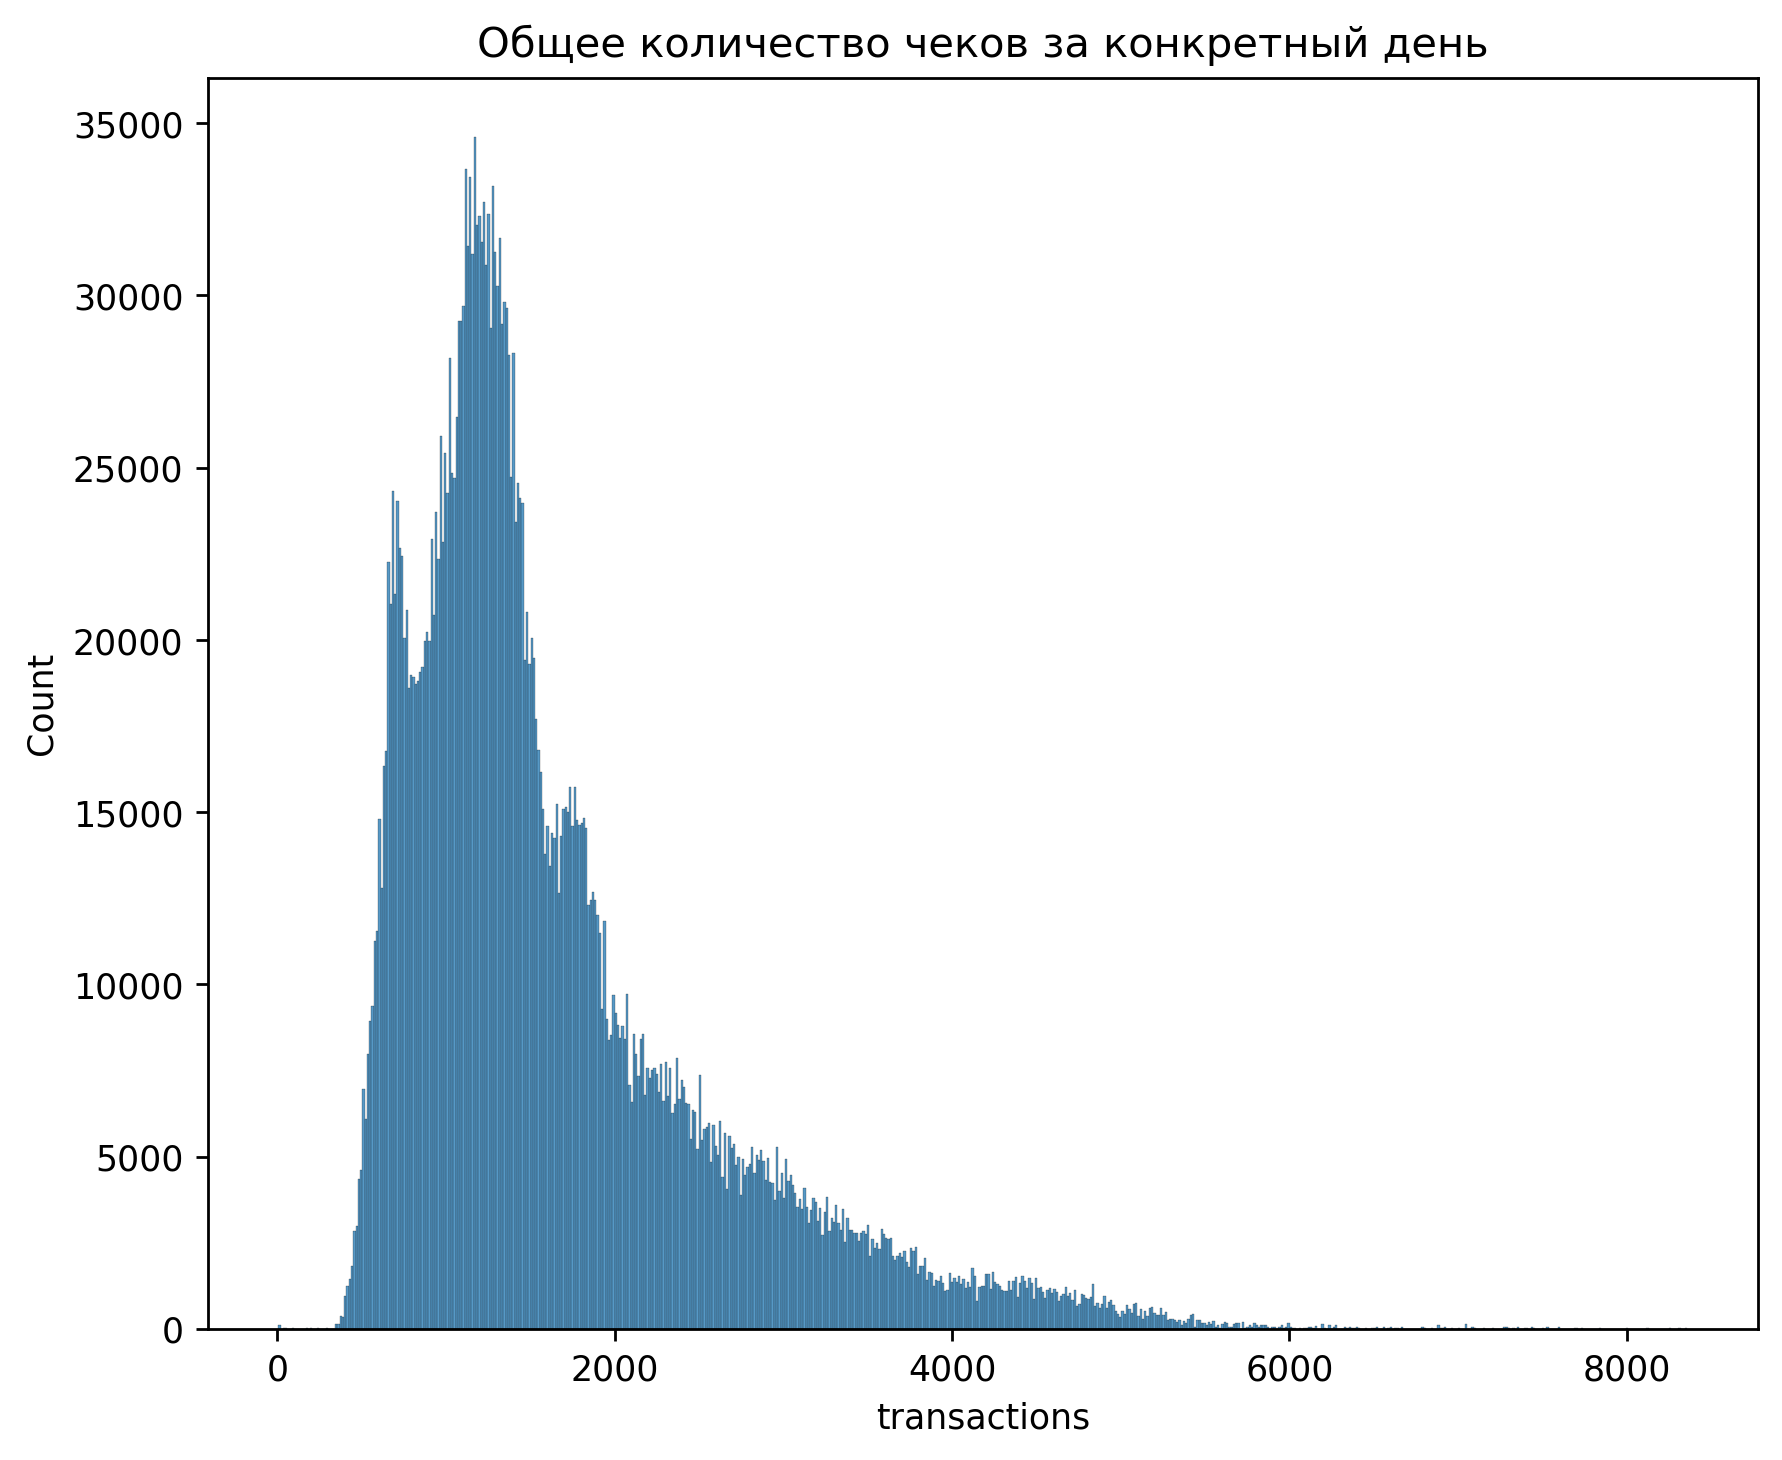

---------------------------------------------------
Ассимметрия равна 15.5922070615831
Эксцесс равен 241.11708023599334
---------------------------------------------------


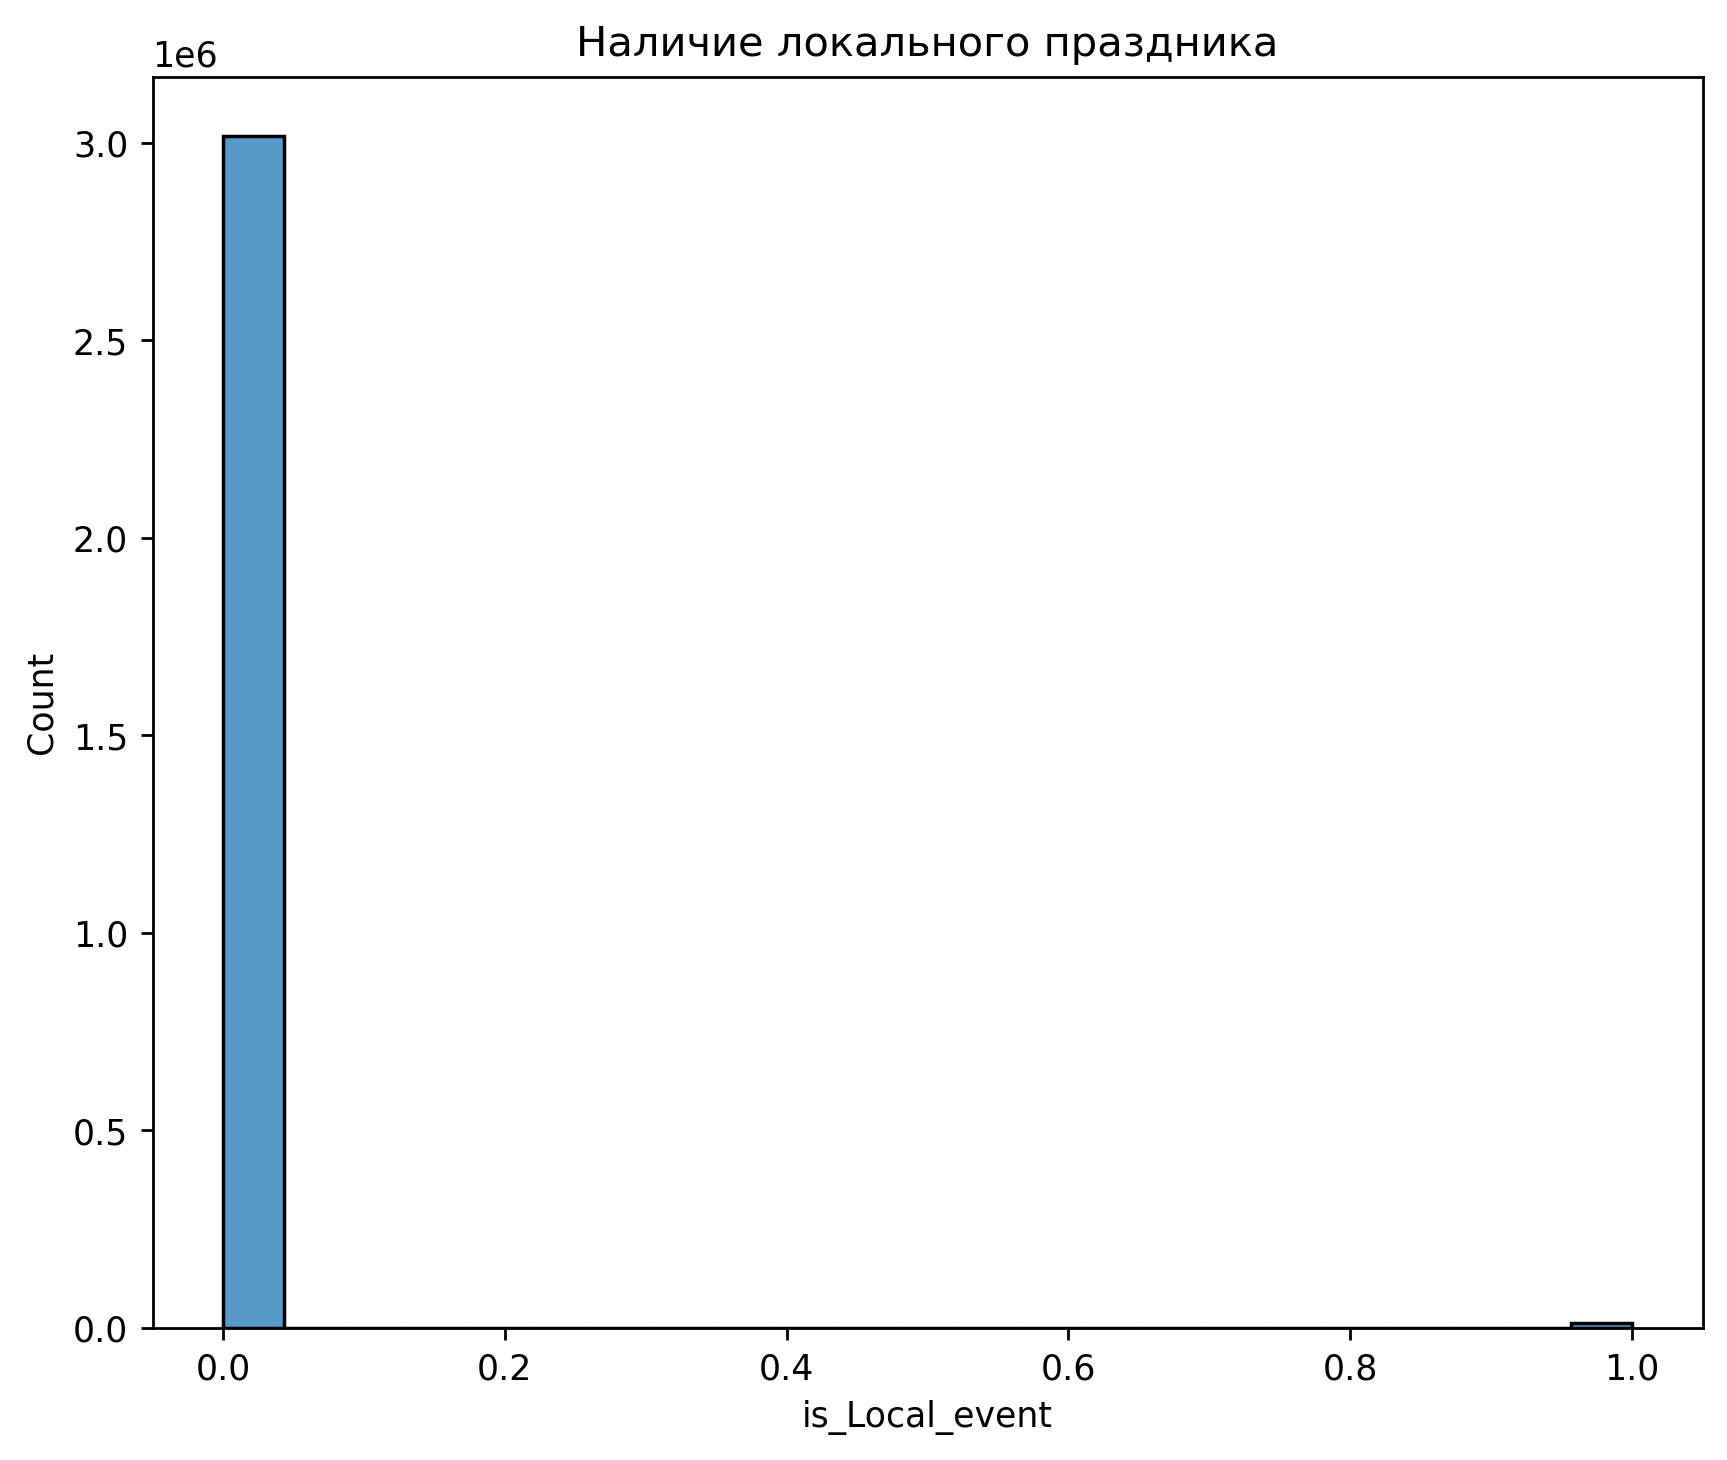

---------------------------------------------------
Ассимметрия равна 54.39019755405124
Эксцесс равен 2956.29554170541
---------------------------------------------------


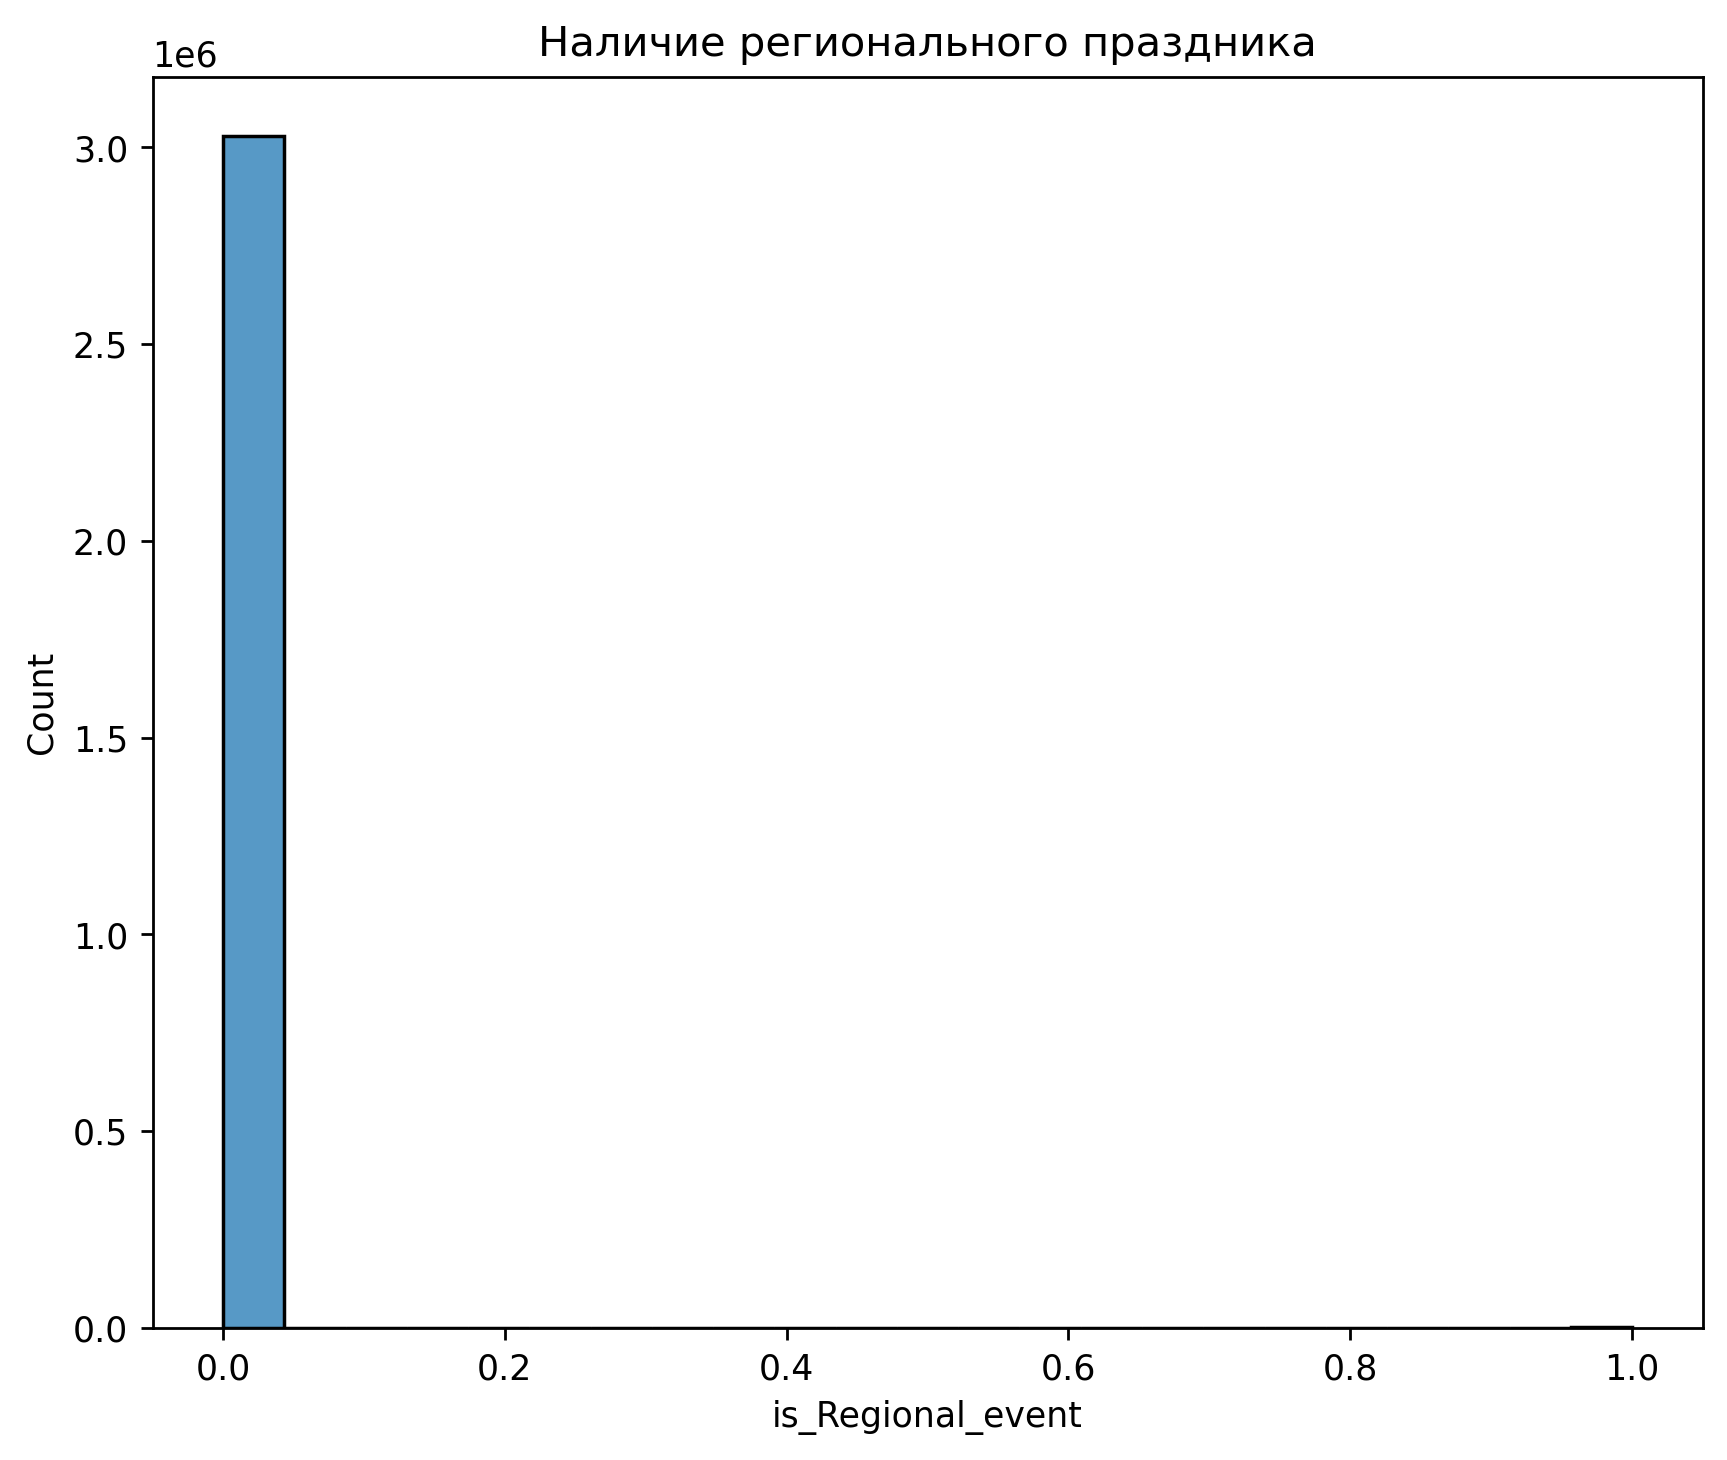

---------------------------------------------------
Ассимметрия равна 2.9966588176334805
Эксцесс равен 6.979968677452634
---------------------------------------------------


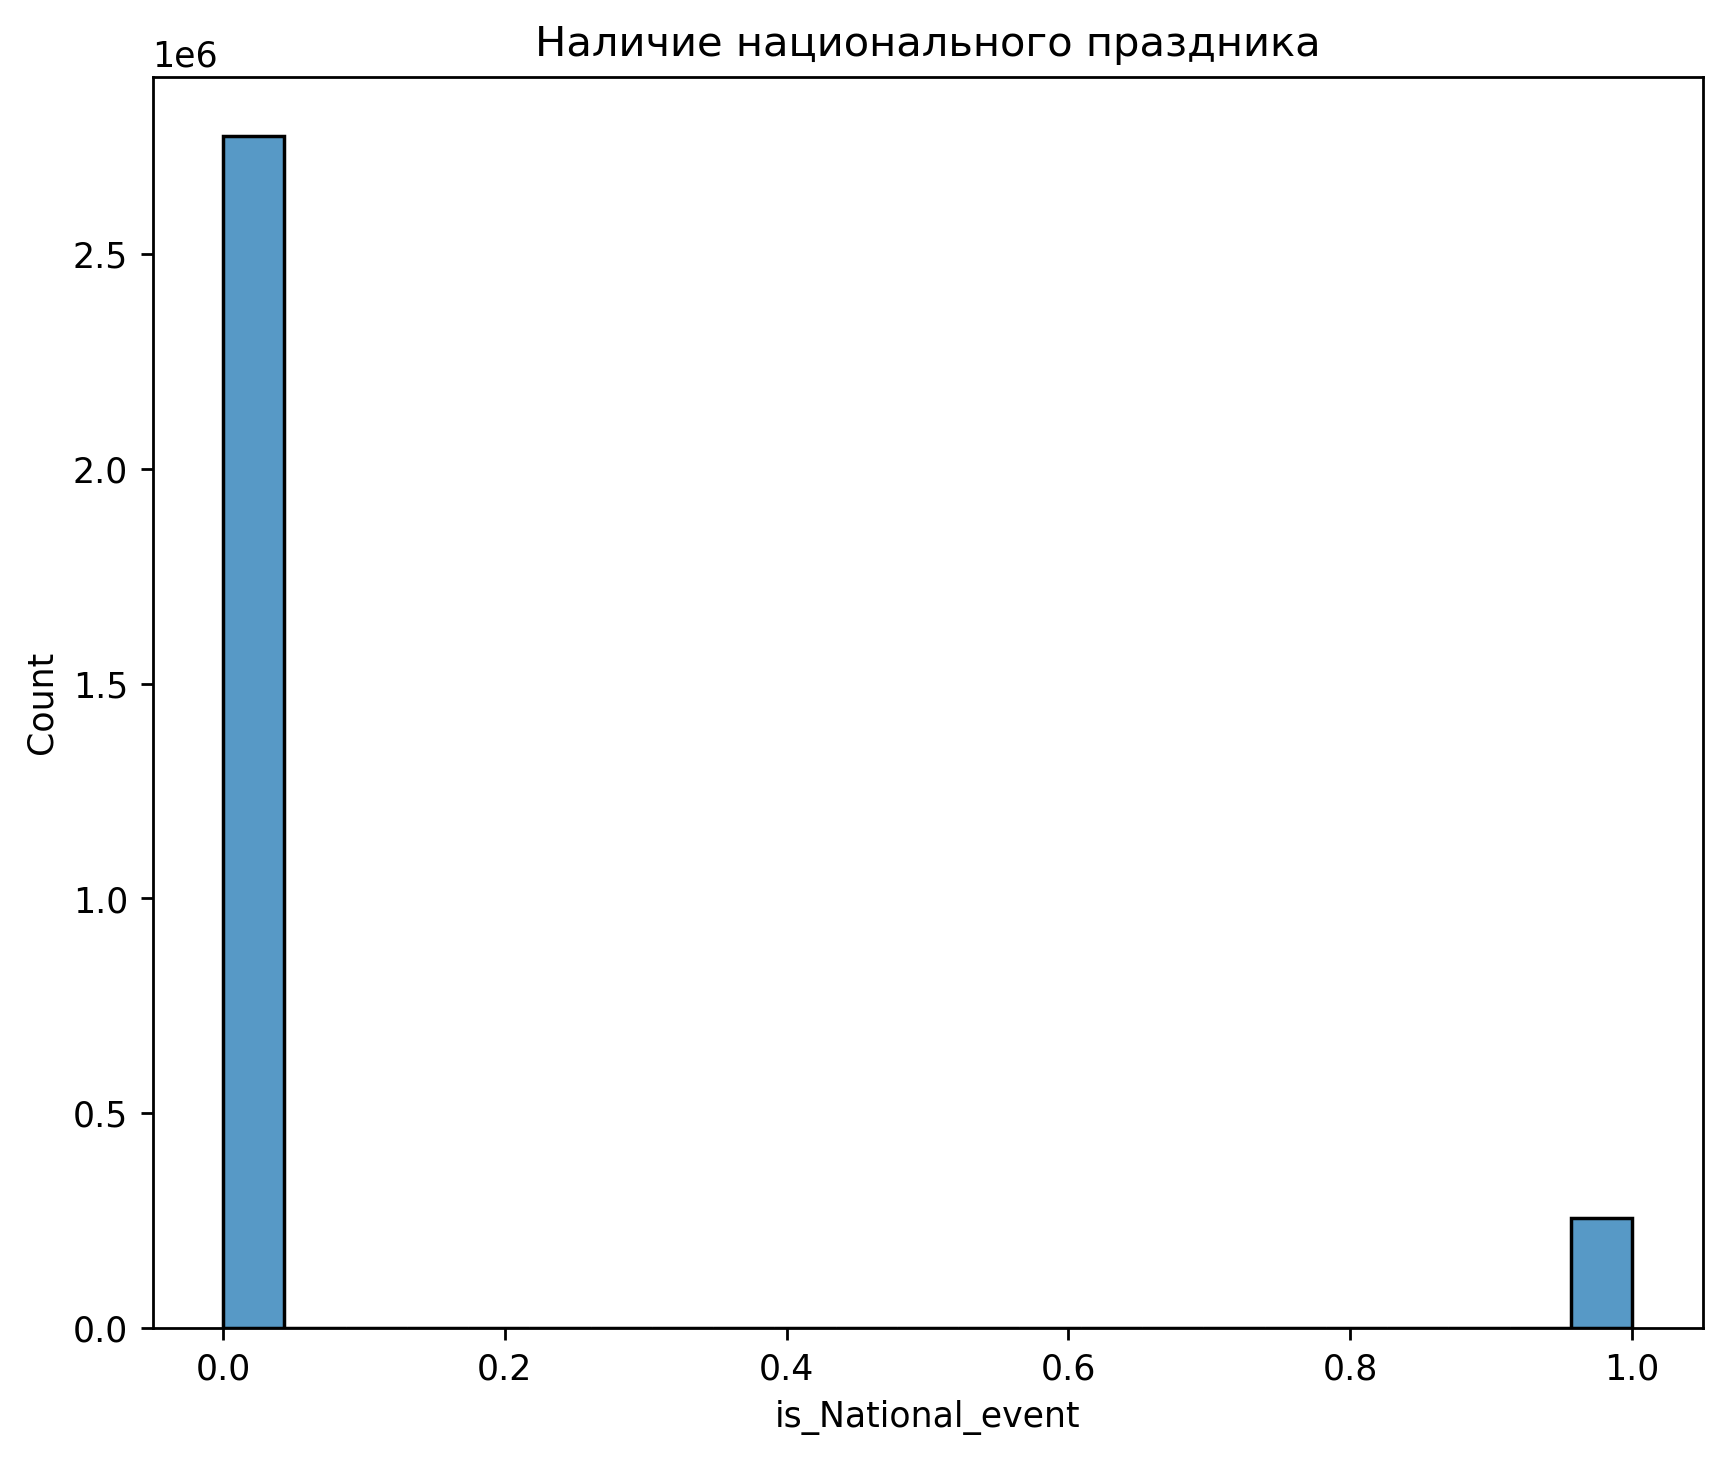

In [312]:
for col in df_num_columns.drop(["date", "store_nbr"], axis=1).columns:
    drow_countplot(df_num_columns, col, dict_num_features_description[col])

In [313]:
#Поменяем тип данных для date в datetime
df_num_columns["date"] = pd.to_datetime(df_num_columns["date"])

In [314]:
df_num_columns["months"] = (df_num_columns["date"].dt.year - 2013) * 12 + df_num_columns["date"].dt.month

In [315]:
df_num_columns["months"]

id
0           1
1           1
2           1
3           1
4           1
           ..
3029395    56
3029396    56
3029397    56
3029398    56
3029399    56
Name: months, Length: 3029400, dtype: int64

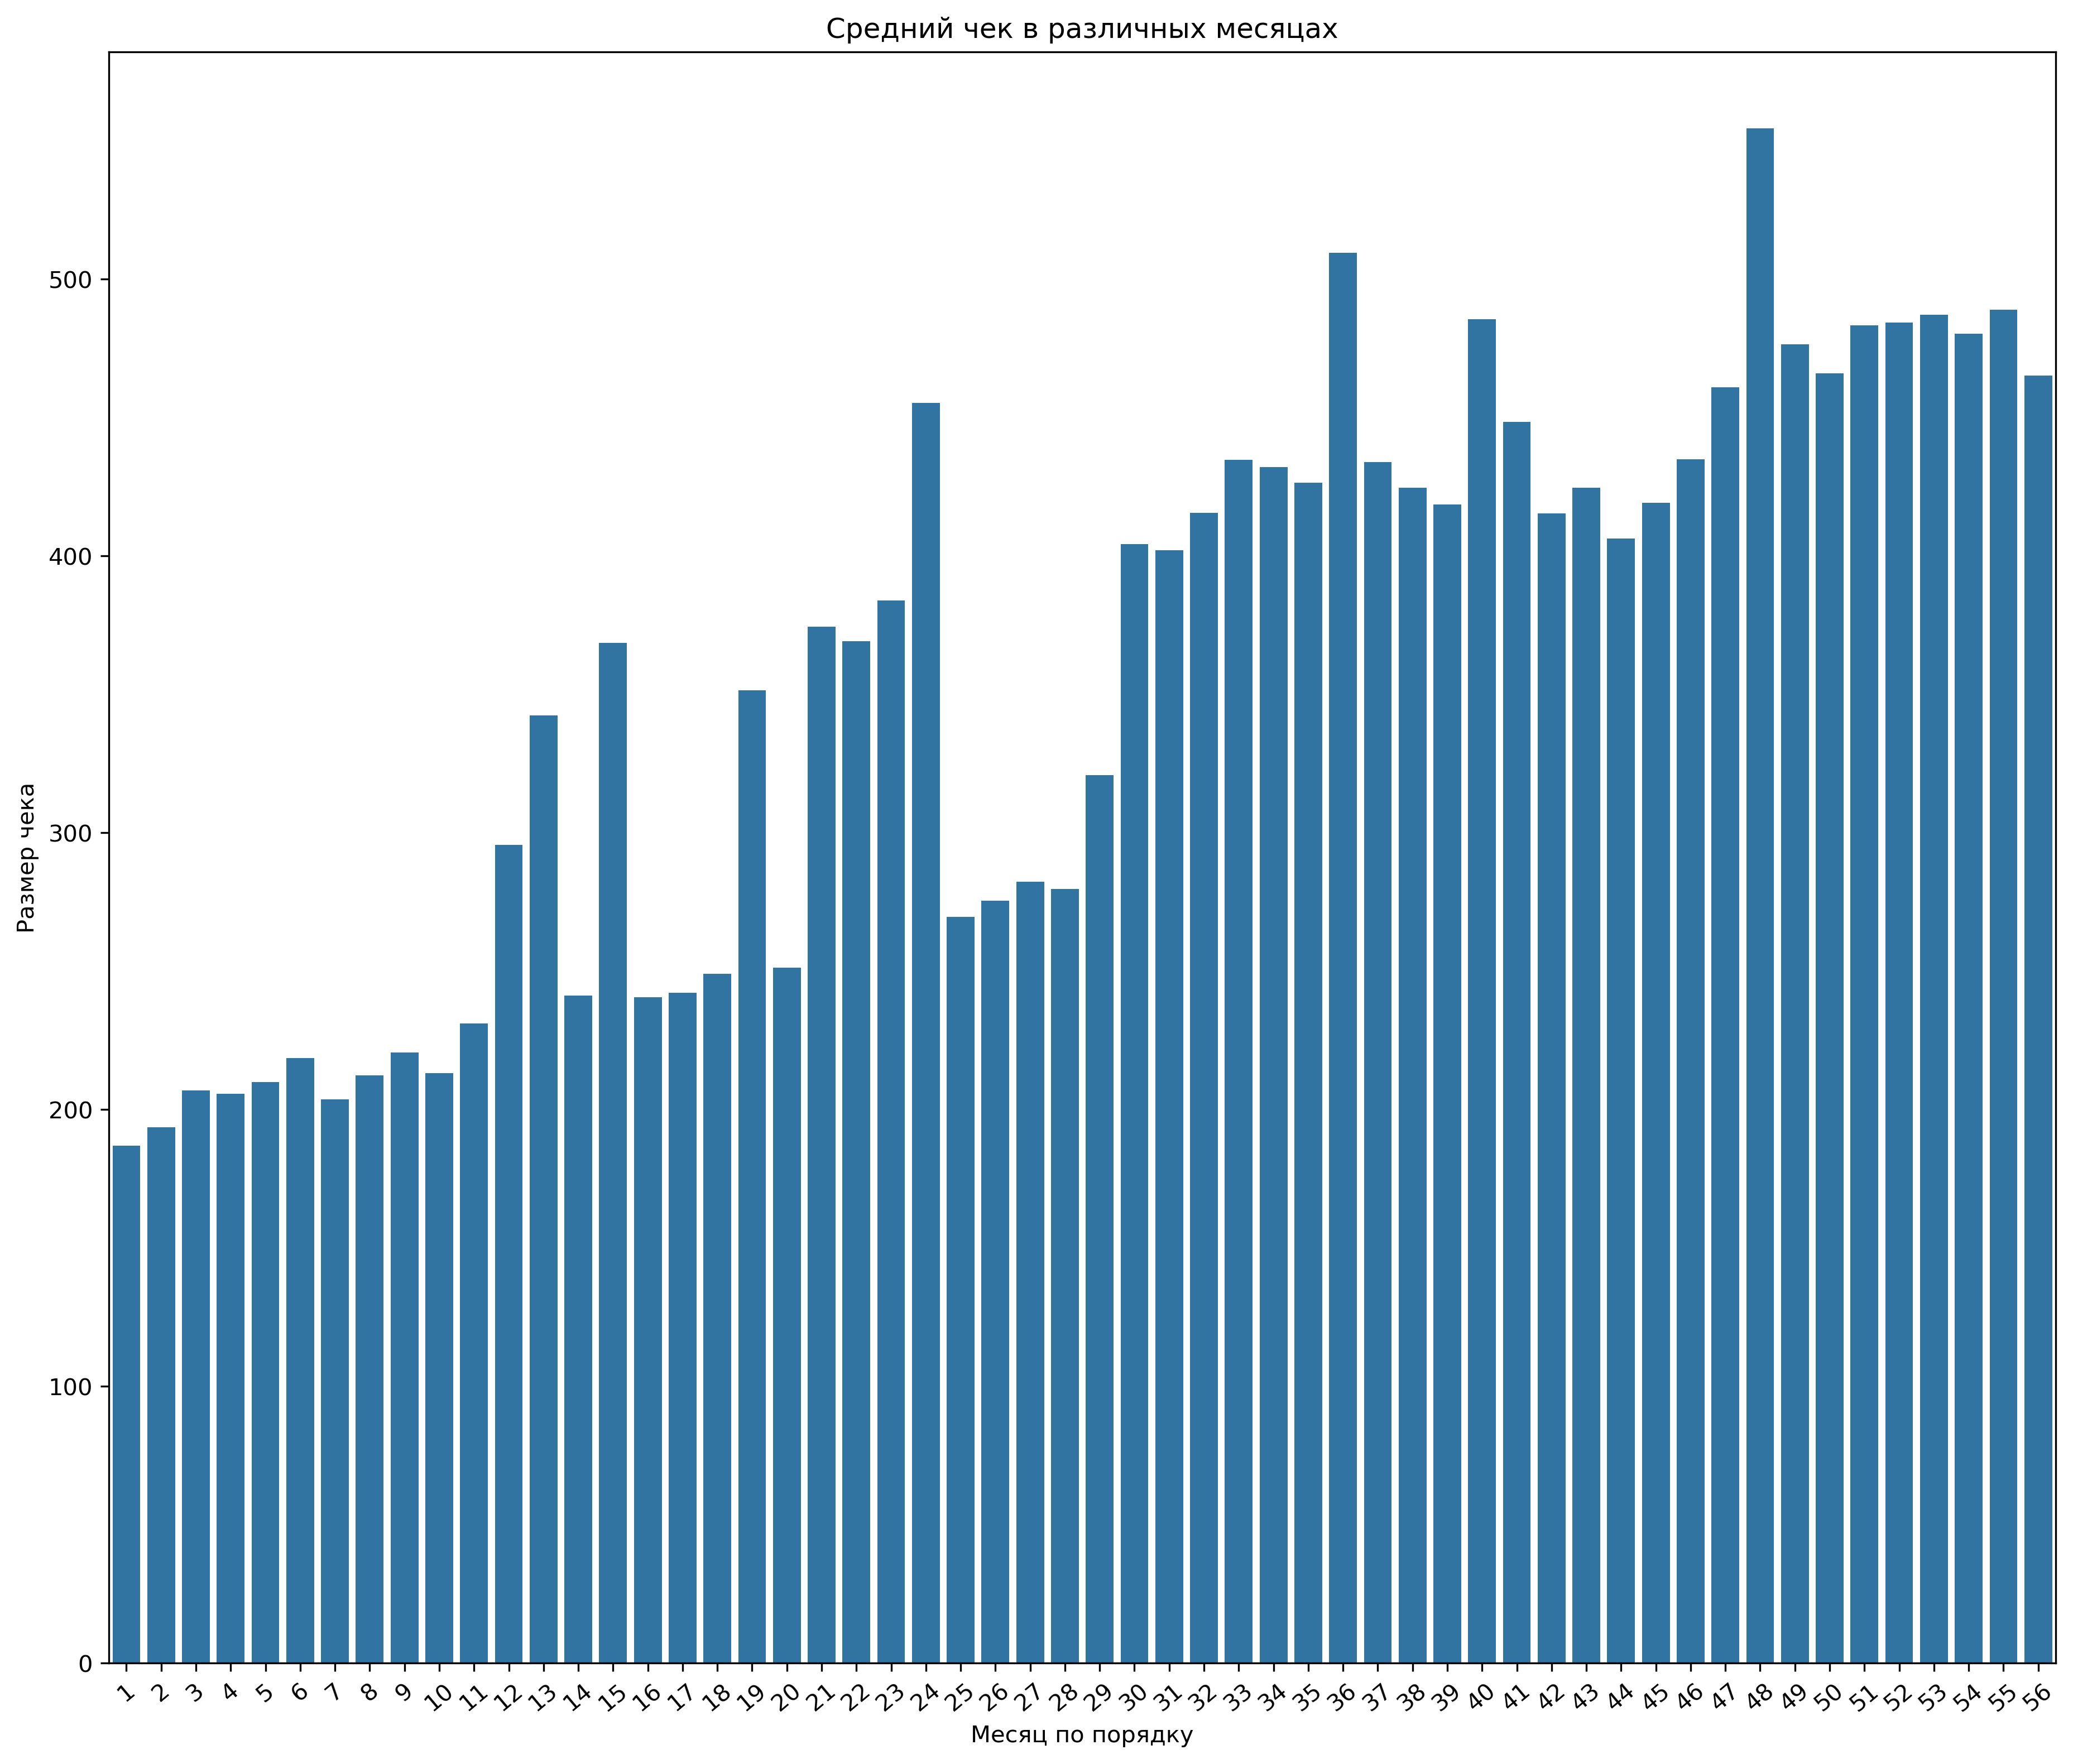

In [316]:
fig = plt.figure(figsize=(15, 12.5), dpi=300)
plt.title("Средний чек в различных месяцах")
plt.ylabel("Размер чека")
plt.xlabel("Месяц по порядку")
sns.barplot(data=df_num_columns.groupby("months")["sales"].mean())
plt.xticks(rotation=40)
plt.show()

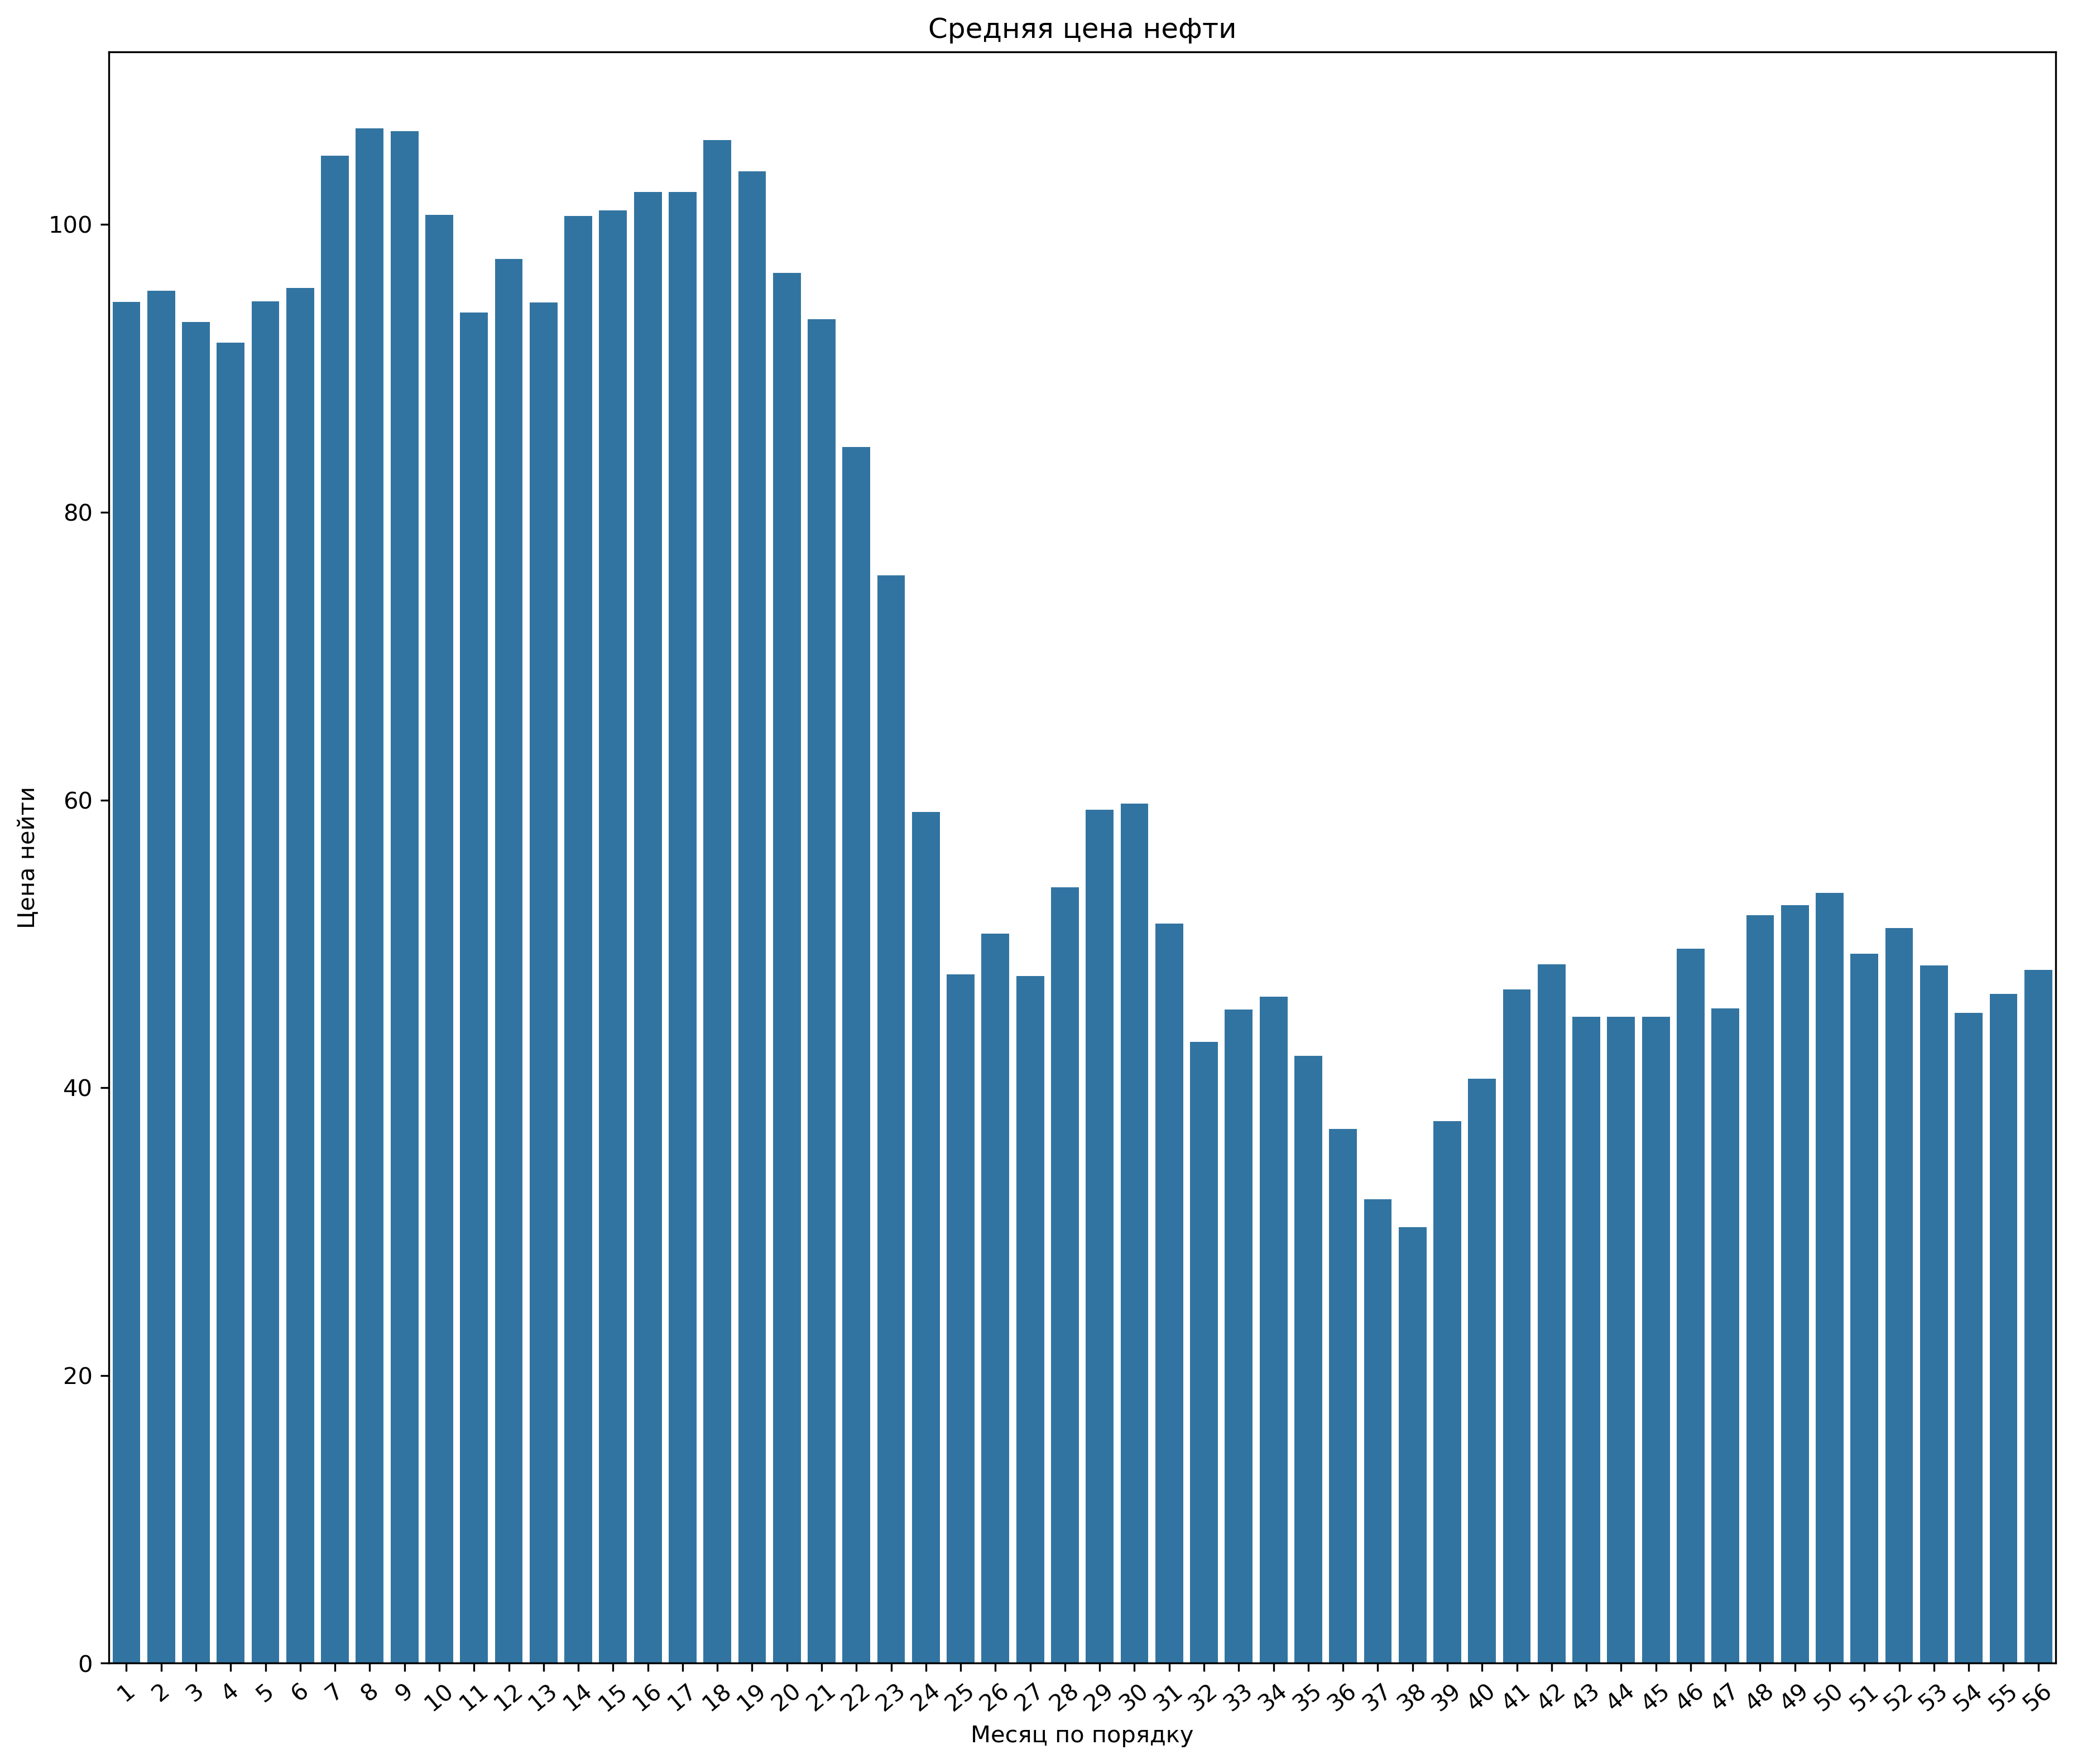

In [317]:
fig = plt.figure(figsize=(15, 12.5), dpi=300)
plt.title("Средняя цена нефти")
plt.ylabel("Цена нейти")
plt.xlabel("Месяц по порядку")
sns.barplot(data=df_num_columns.groupby("months")["dcoilwtico"].mean())
plt.xticks(rotation=40)
plt.show()

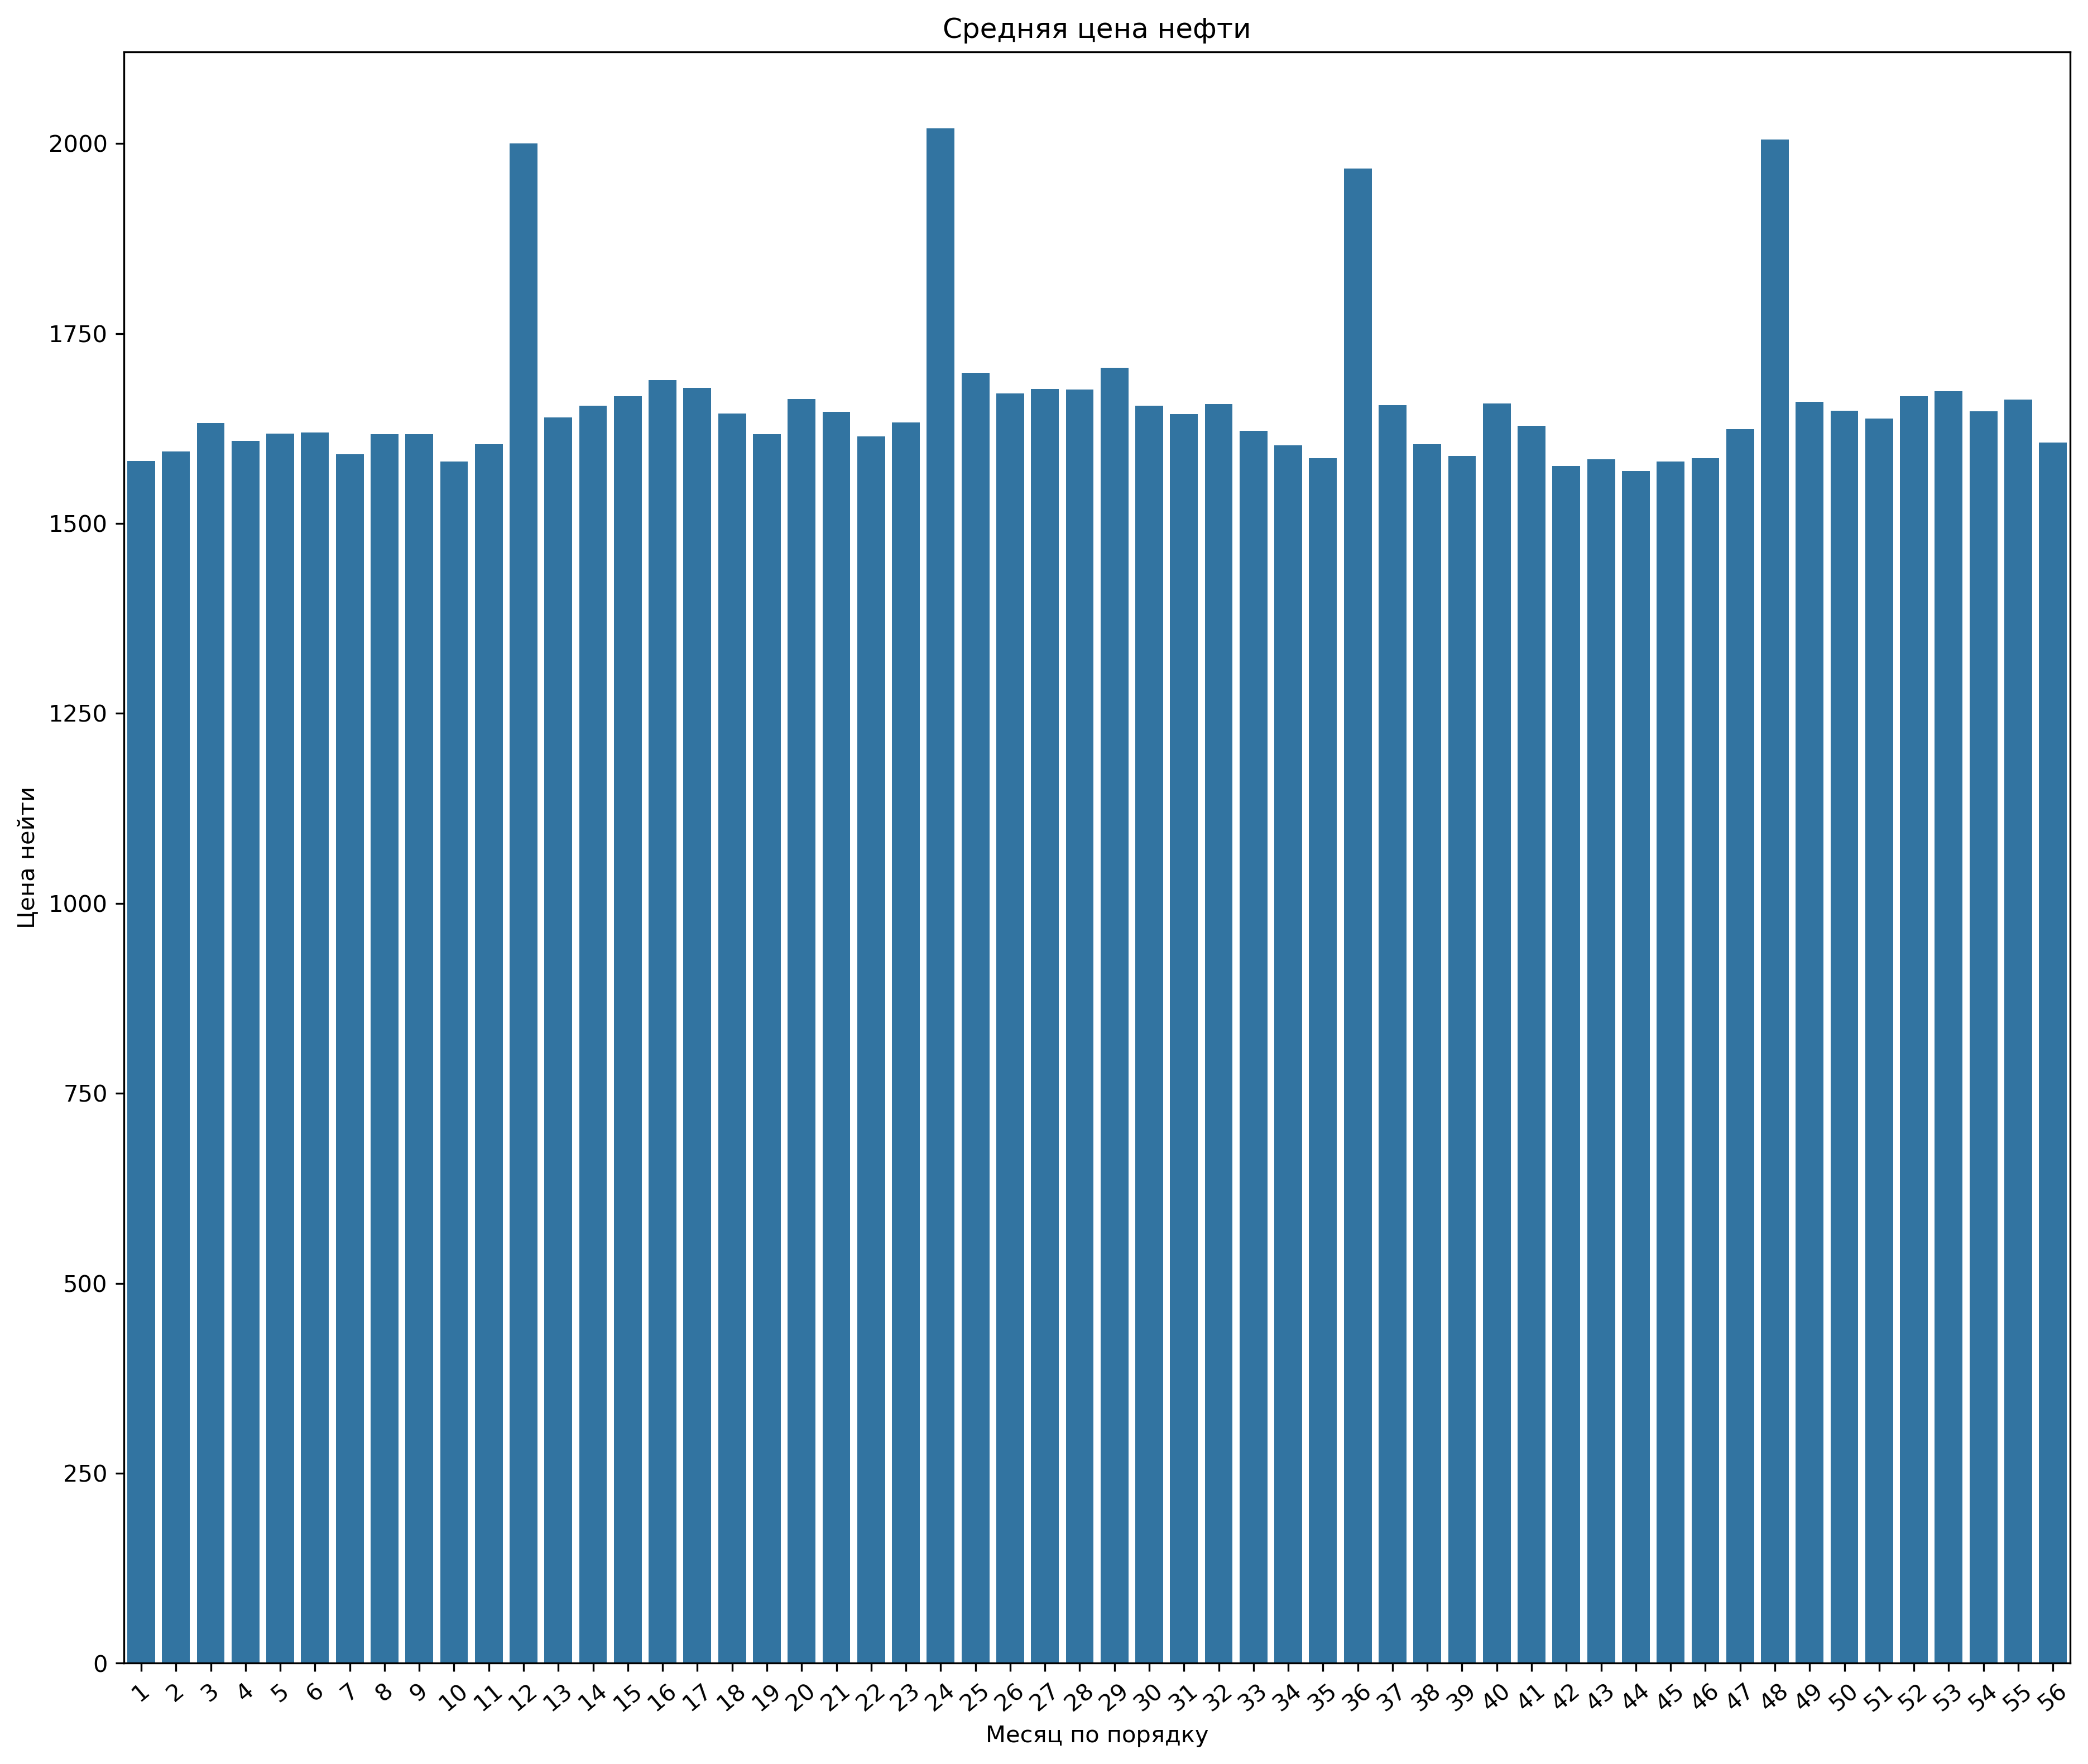

In [318]:
fig = plt.figure(figsize=(15, 12.5), dpi=300)
plt.title("Средняя цена нефти")
plt.ylabel("Цена нейти")
plt.xlabel("Месяц по порядку")
sns.barplot(data=df_num_columns.groupby("months")["transactions"].mean())
plt.xticks(rotation=40)
plt.show()

### Результат анализа
- Видно, что средний чек увеличивался в цене
- Цена нефти стала падать после 14 года
- Количество продав в среднем никак не менялось, исключая случаи, каждого 12 месяца, так как там были праздники

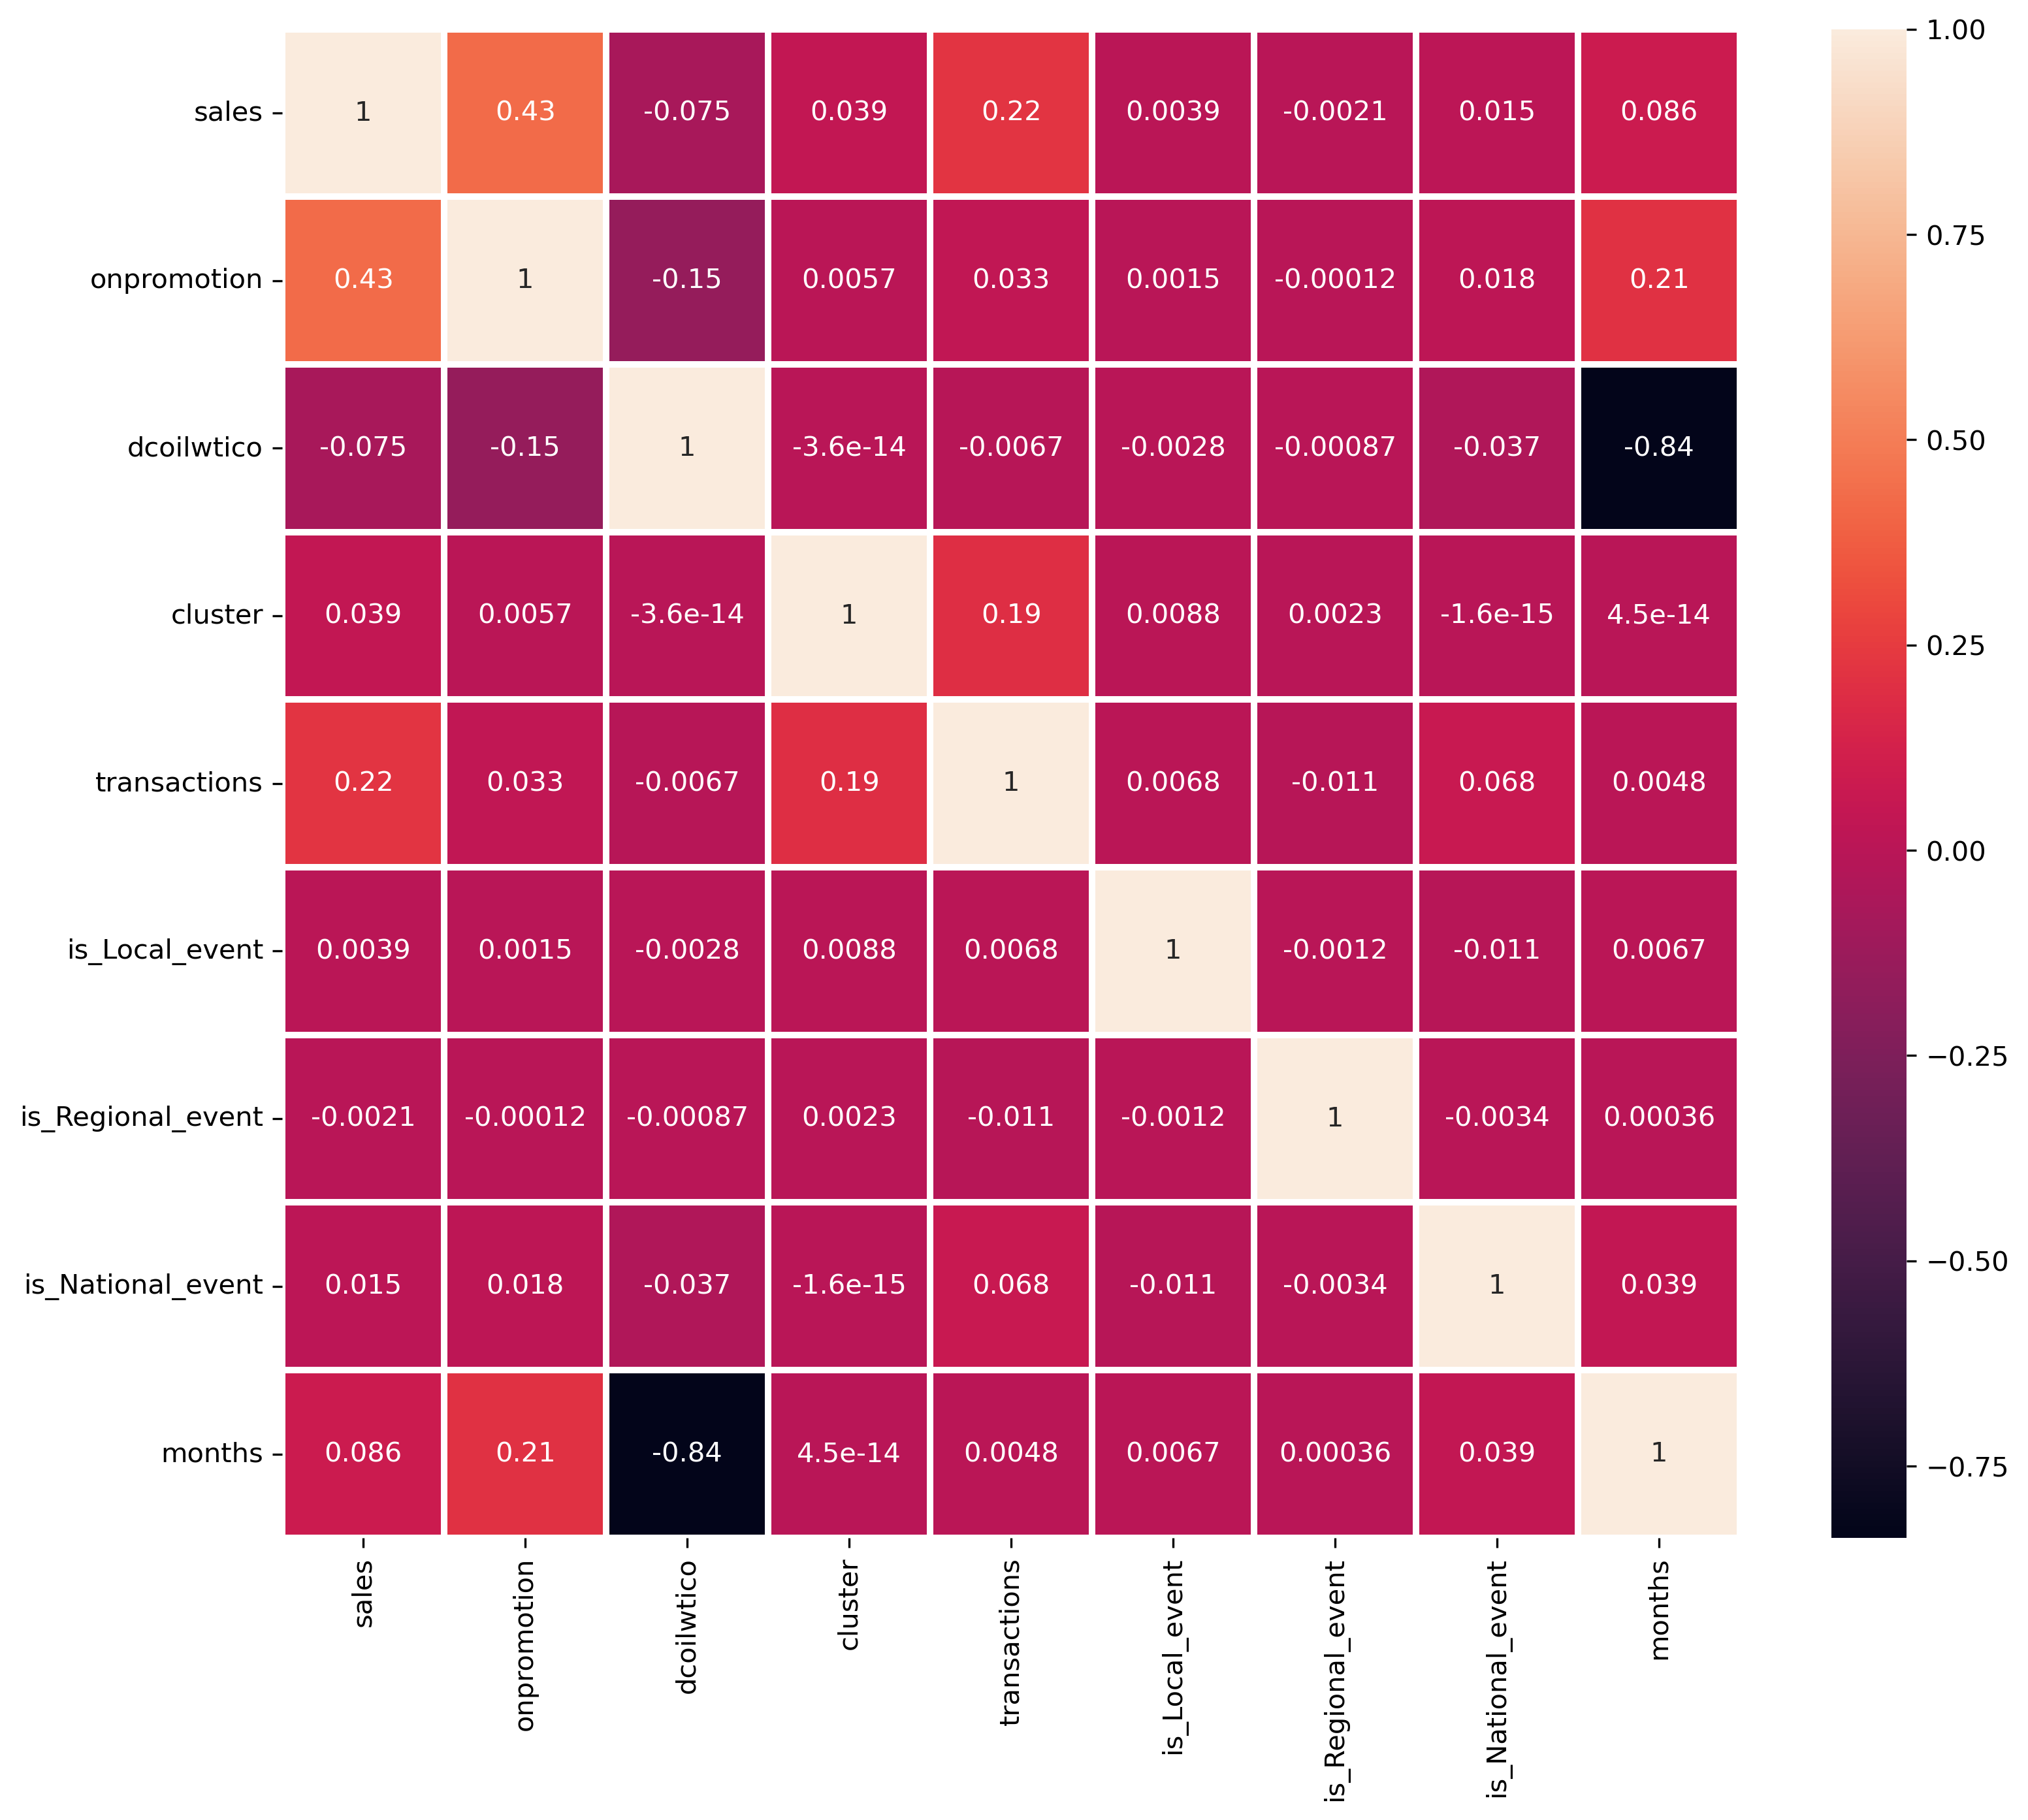

In [319]:
#Отрисуем тепловую карту
fig = plt.figure(figsize=(12, 10), dpi=300)
sns.heatmap(data=df_num_columns.drop(["date", "store_nbr"], axis=1).corr(), annot=True, linewidths=2)
plt.show()

In [320]:
#Уберем признак months, так как он коррелирует сильно с признаком dcoliwtico, а также он был вспомогательным
df_num_columns.drop("months", axis=1, inplace=True)
print("Признак months удалён!")

Признак months удалён!


In [321]:
df_num_columns.drop(["date", "store_nbr"], axis=1).corr()

sales  onpromotion    dcoilwtico       cluster  \
sales              1.000000     0.427923 -7.480838e-02  3.852528e-02   
onpromotion        0.427923     1.000000 -1.546659e-01  5.700249e-03   
dcoilwtico        -0.074808    -0.154666  1.000000e+00 -3.578086e-14   
cluster            0.038525     0.005700 -3.578086e-14  1.000000e+00   
transactions       0.221652     0.033231 -6.689040e-03  1.944674e-01   
is_Local_event     0.003901     0.001518 -2.767400e-03  8.780110e-03   
is_Regional_event -0.002146    -0.000119 -8.672325e-04  2.304619e-03   
is_National_event  0.015149     0.018063 -3.653758e-02 -1.614552e-15   

                   transactions  is_Local_event  is_Regional_event  \
sales                  0.221652        0.003901          -0.002146   
onpromotion            0.033231        0.001518          -0.000119   
dcoilwtico            -0.006689       -0.002767          -0.000867   
cluster                0.194467        0.008780           0.002305   
transactions           1.000000        0.006773          -0.010936   
is_Local_event         0.006773        1.000000          -0.001174   
is_Regional_event     -0.010936       -0.001174           1.000000   
is_National_event      0.068117       -0.010720          -0.003434   

                   is_National_event  
sales                   1.514877e-02  
onpromotion             1.806335e-02  
dcoilwtico             -3.653758e-02  
cluster                -1.614552e-15  
transactions            6.811655e-02  
is_Local_event         -1.071993e-02  
is_Regional_event      -3.433986e-03  
is_National_event       1.000000e+00

### Анализ категориальных признаков

In [322]:
#Посмотрим на общую информацию
df_cat_columns.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3029400 entries, 0 to 3029399
Data columns (total 9 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   date                        object 
 1   family                      object 
 2   city                        object 
 3   state                       object 
 4   type                        object 
 5   description_National_event  object 
 6   description_Regional_event  object 
 7   description_Local_event     object 
 8   sales                       float64
dtypes: float64(1), object(8)
memory usage: 295.6+ MB


In [323]:
#Посмотрим на основные статистики
df_cat_columns.describe(include="object")

date      family     city      state     type  \
count      3029400     3029400  3029400    3029400  3029400   
unique        1700          33       22         16        5   
top     2017-08-31  AUTOMOTIVE    Quito  Pichincha        D   
freq          1782       91800  1009800    1065900  1009800   

       description_National_event description_Regional_event  \
count                     3029400                    3029400   
unique                         72                          5   
top                      No_Event                   No_Event   
freq                      2767446                    2997324   

       description_Local_event  
count                  3029400  
unique                      27  
top                   No_Event  
freq                   2820906

In [324]:
#Посмотрим на пропуски в процентном соотношении
df_cat_columns.isna().sum() / len(df_cat_columns) * 100

date                          0.000000
family                        0.000000
city                          0.000000
state                         0.000000
type                          0.000000
description_National_event    0.000000
description_Regional_event    0.000000
description_Local_event       0.000000
sales                         0.941176
dtype: float64

In [325]:
#Создадим вспомогательный словарь для перевода колонок на русский язык
dict_cat_feature_description = {
    "date": "Дата",
    "family": "Категория товара",
    "city": "Город",
    "state": "Провинция",
    "type": "Тип магазина"
}

In [326]:
# Функция, которая отрисовывает гистограмму распределения признаков
def drow_countplot(df, col, dict_cat_feature_description):
    fig = plt.figure(figsize=(6, 5), dpi=150)
    plt.title(dict_cat_feature_description)
    plt.ylabel(col)
    sns.countplot(data=df, x=col, palette="hls")
    plt.xticks(rotation=45)
    plt.show()

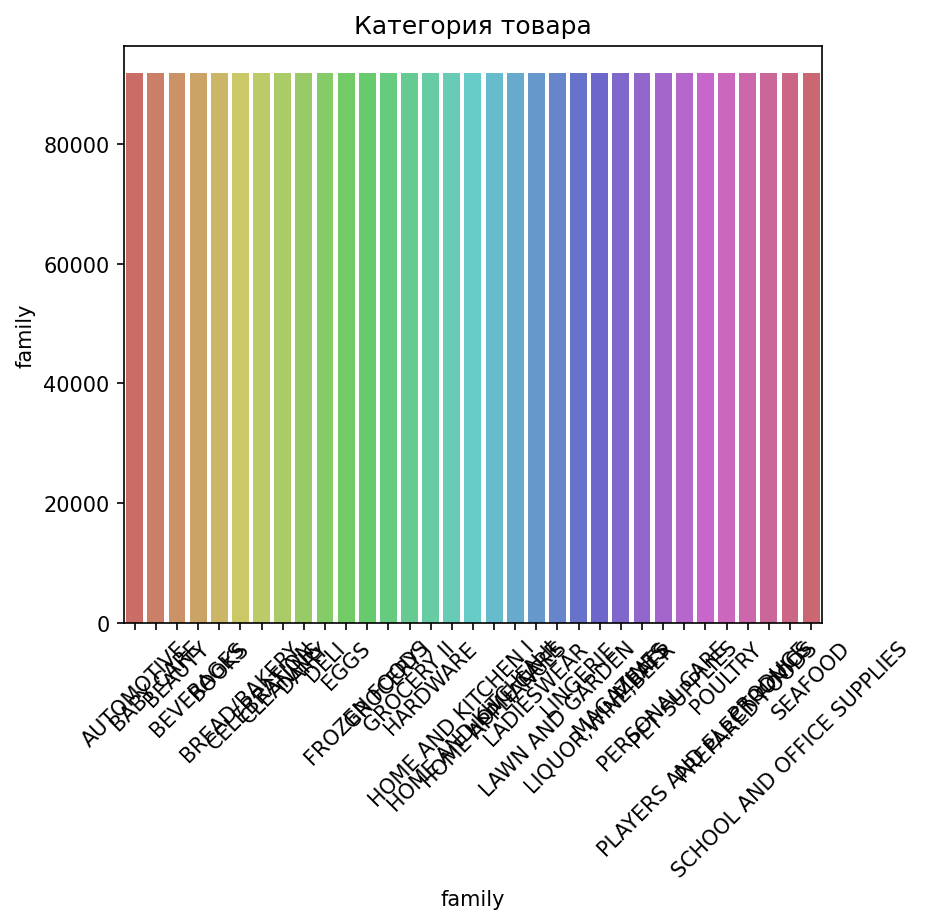

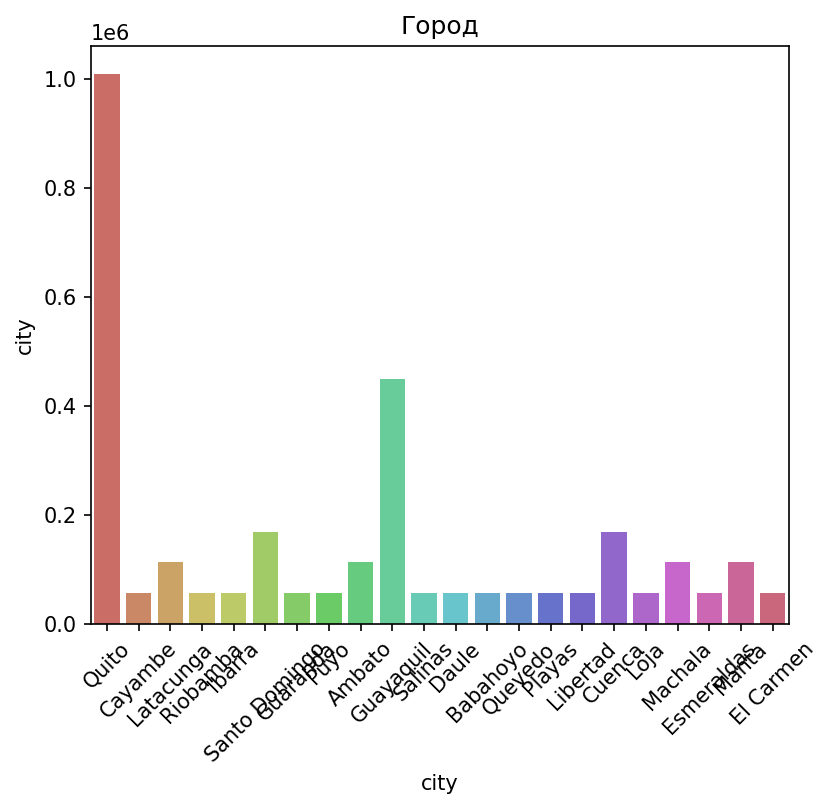

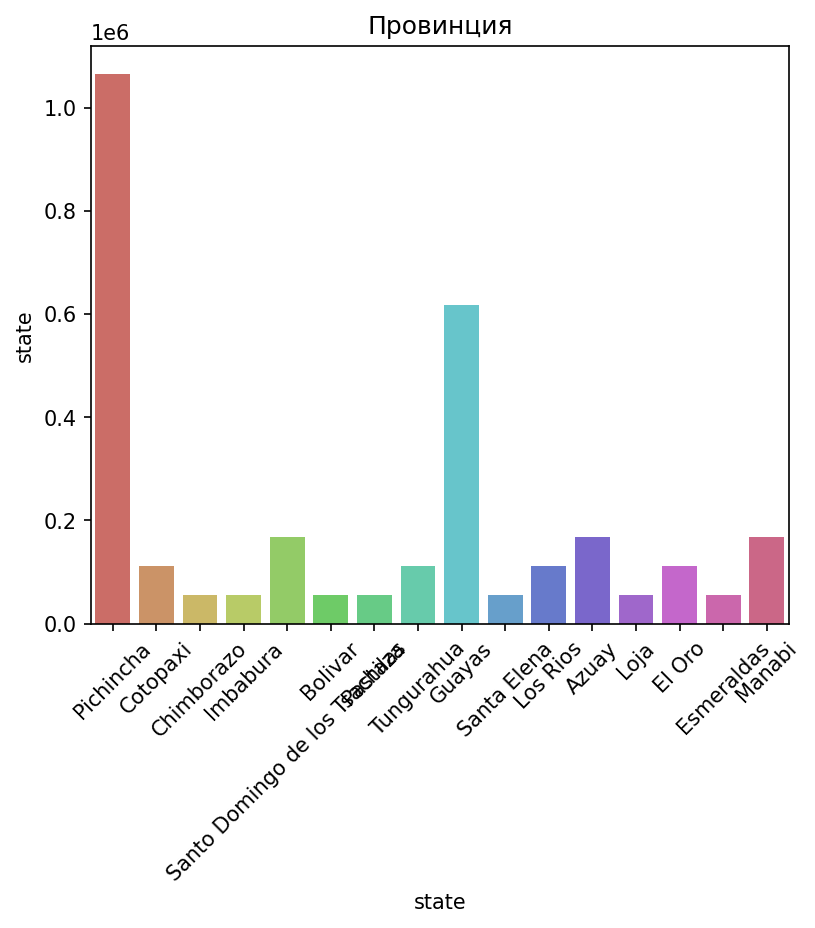

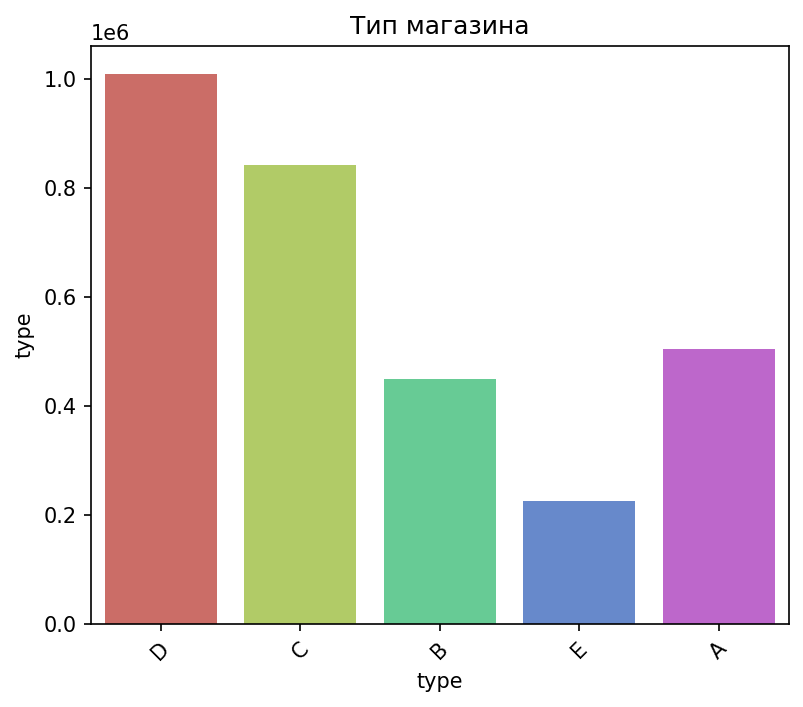

In [327]:
for col in ["family", "city", "state", "type"]:
    drow_countplot(df_cat_columns, col, dict_cat_feature_description[col])

### Результат
- В категории товаров, все категории имеют одинаковую частоту
- Нет категорий, которые очень сильно доминируют

In [328]:
#Функция, которая показывает распределение целевой переменной для каждой категории
def drow_boxplot(df, col, dict_cat_feature_description):
    fig = plt.figure(figsize=(7, 6.75), dpi=200)
    plt.title(dict_cat_feature_description)
    plt.ylabel(col)
    sns.boxplot(data=df, x=col, y="sales", palette="hls")
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
for col in ["family", "city", "state", "type"]:


### Результат
- Хорошо видно, что распределение меняется в зависимости от той или иной категории, значит категория влияет на распределение

In [330]:
#Функиця для отображения среднего значения целевой переменной, для каждой категории
def drow_barplot_mean(df, col, dict_cat_feature_description):
    group_data = df.groupby(col)["sales"].mean().sort_values(ascending=False)
    fig = plt.figure(figsize=(7, 6.75), dpi=400)
    plt.title(dict_cat_feature_description)
    plt.ylabel(col)
    sns.barplot(data=group_data, palette="hls")
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
for col in ["family", "city", "state", "type"]:
    drow_barplot_mean(df_cat_columns, col, dict_cat_feature_description[col])

In [332]:
#Снова добавим колонку months для различных экспериментов
df_cat_columns["months"] = (df_num_columns["date"].dt.year - 2013) * 12 + df_num_columns["date"].dt.month

In [333]:
#Функция для среднего значения целевой переменной для каждой категории в каждый месяц
def drow_mean_months(df, col, dict_cat_feature_description):
    fig = plt.figure(figsize=(7, 6.75), dpi=400)
    plt.title(dict_cat_feature_description)
    for cat in df[col].unique():
        cat_data = df[df[col]==cat].groupby("months")["sales"].mean()
        plt.plot(cat_data, label=cat)
    plt.ylabel(col)
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
for col in ["family", "city", "state", "type"]:
    drow_mean_months(df_cat_columns, col, dict_cat_feature_description[col])

In [335]:
#Также посмотрим среднее распределение цены для разлиных праздников, только возьмем первые 30, так как праздников очень много
def drow_barplot_mean_event(df, col, dict_cat_feature_description):
    group_data = df.groupby(col)["sales"].mean().sort_values(ascending=False)
    fig = plt.figure(figsize=(7, 6.75), dpi=400)
    plt.title(dict_cat_feature_description)
    plt.ylabel(col)
    sns.barplot(data=group_data, palette="hls")
    plt.xticks(rotation=45)
    plt.show()

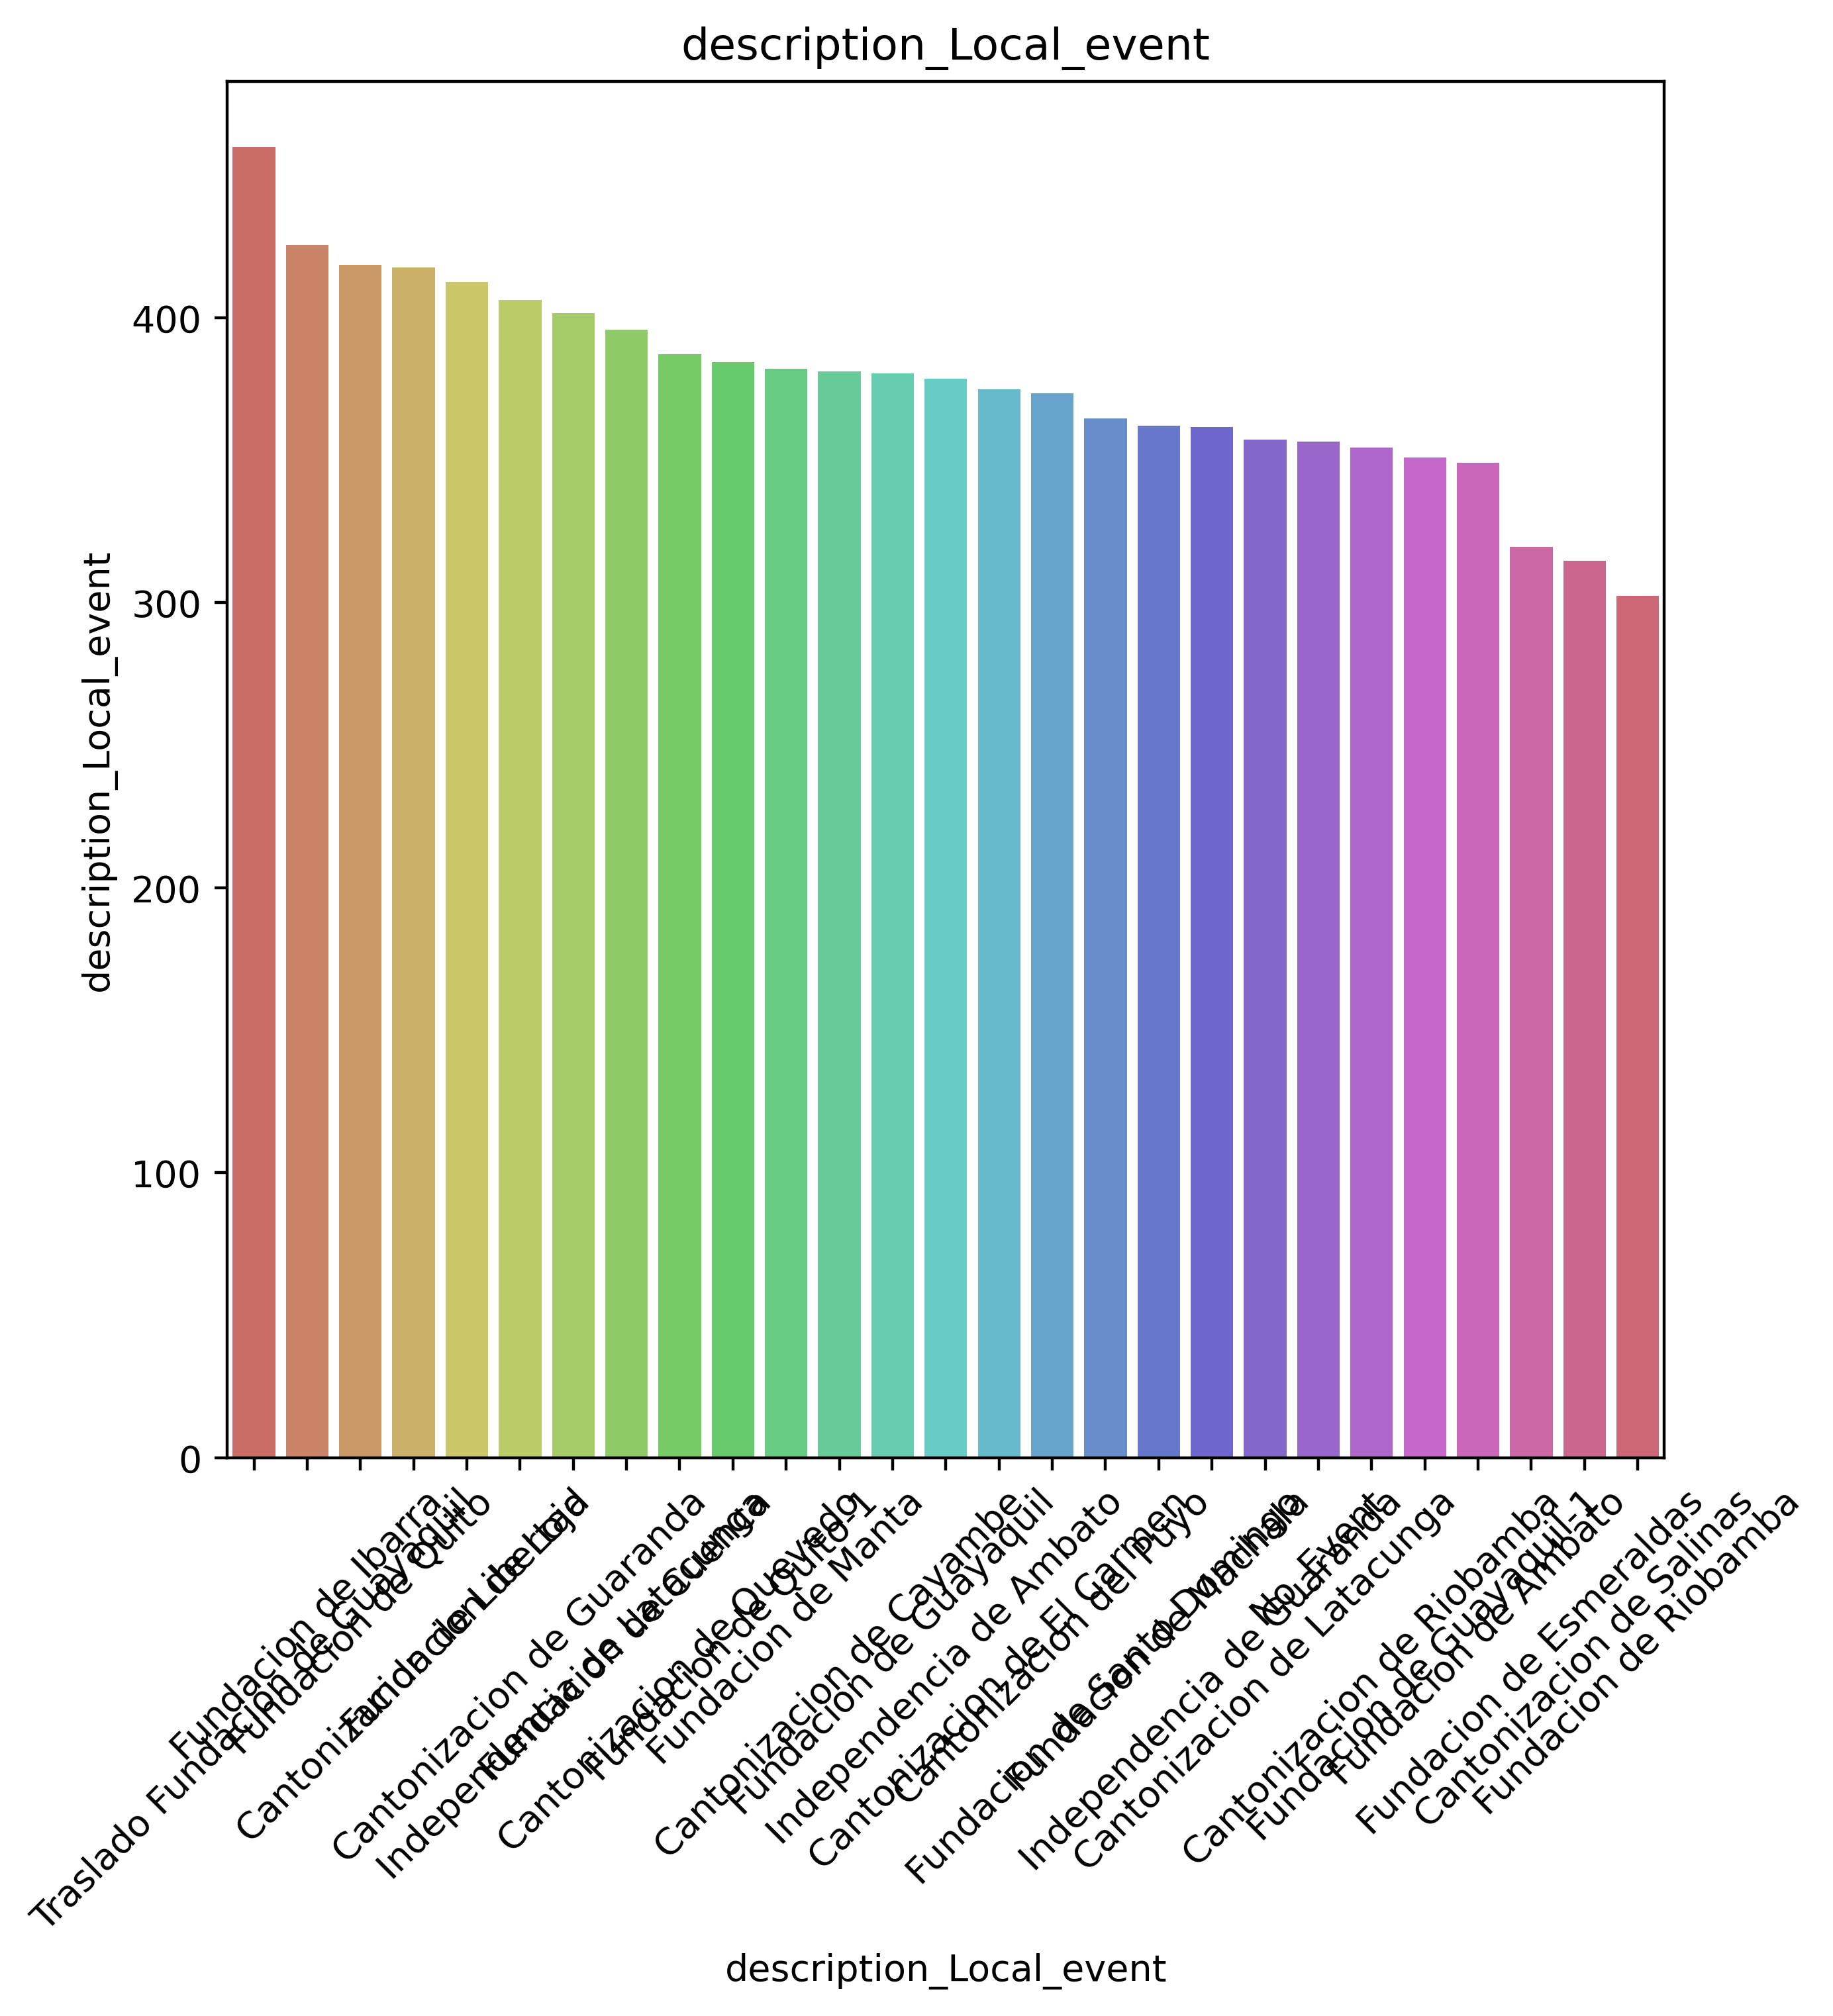

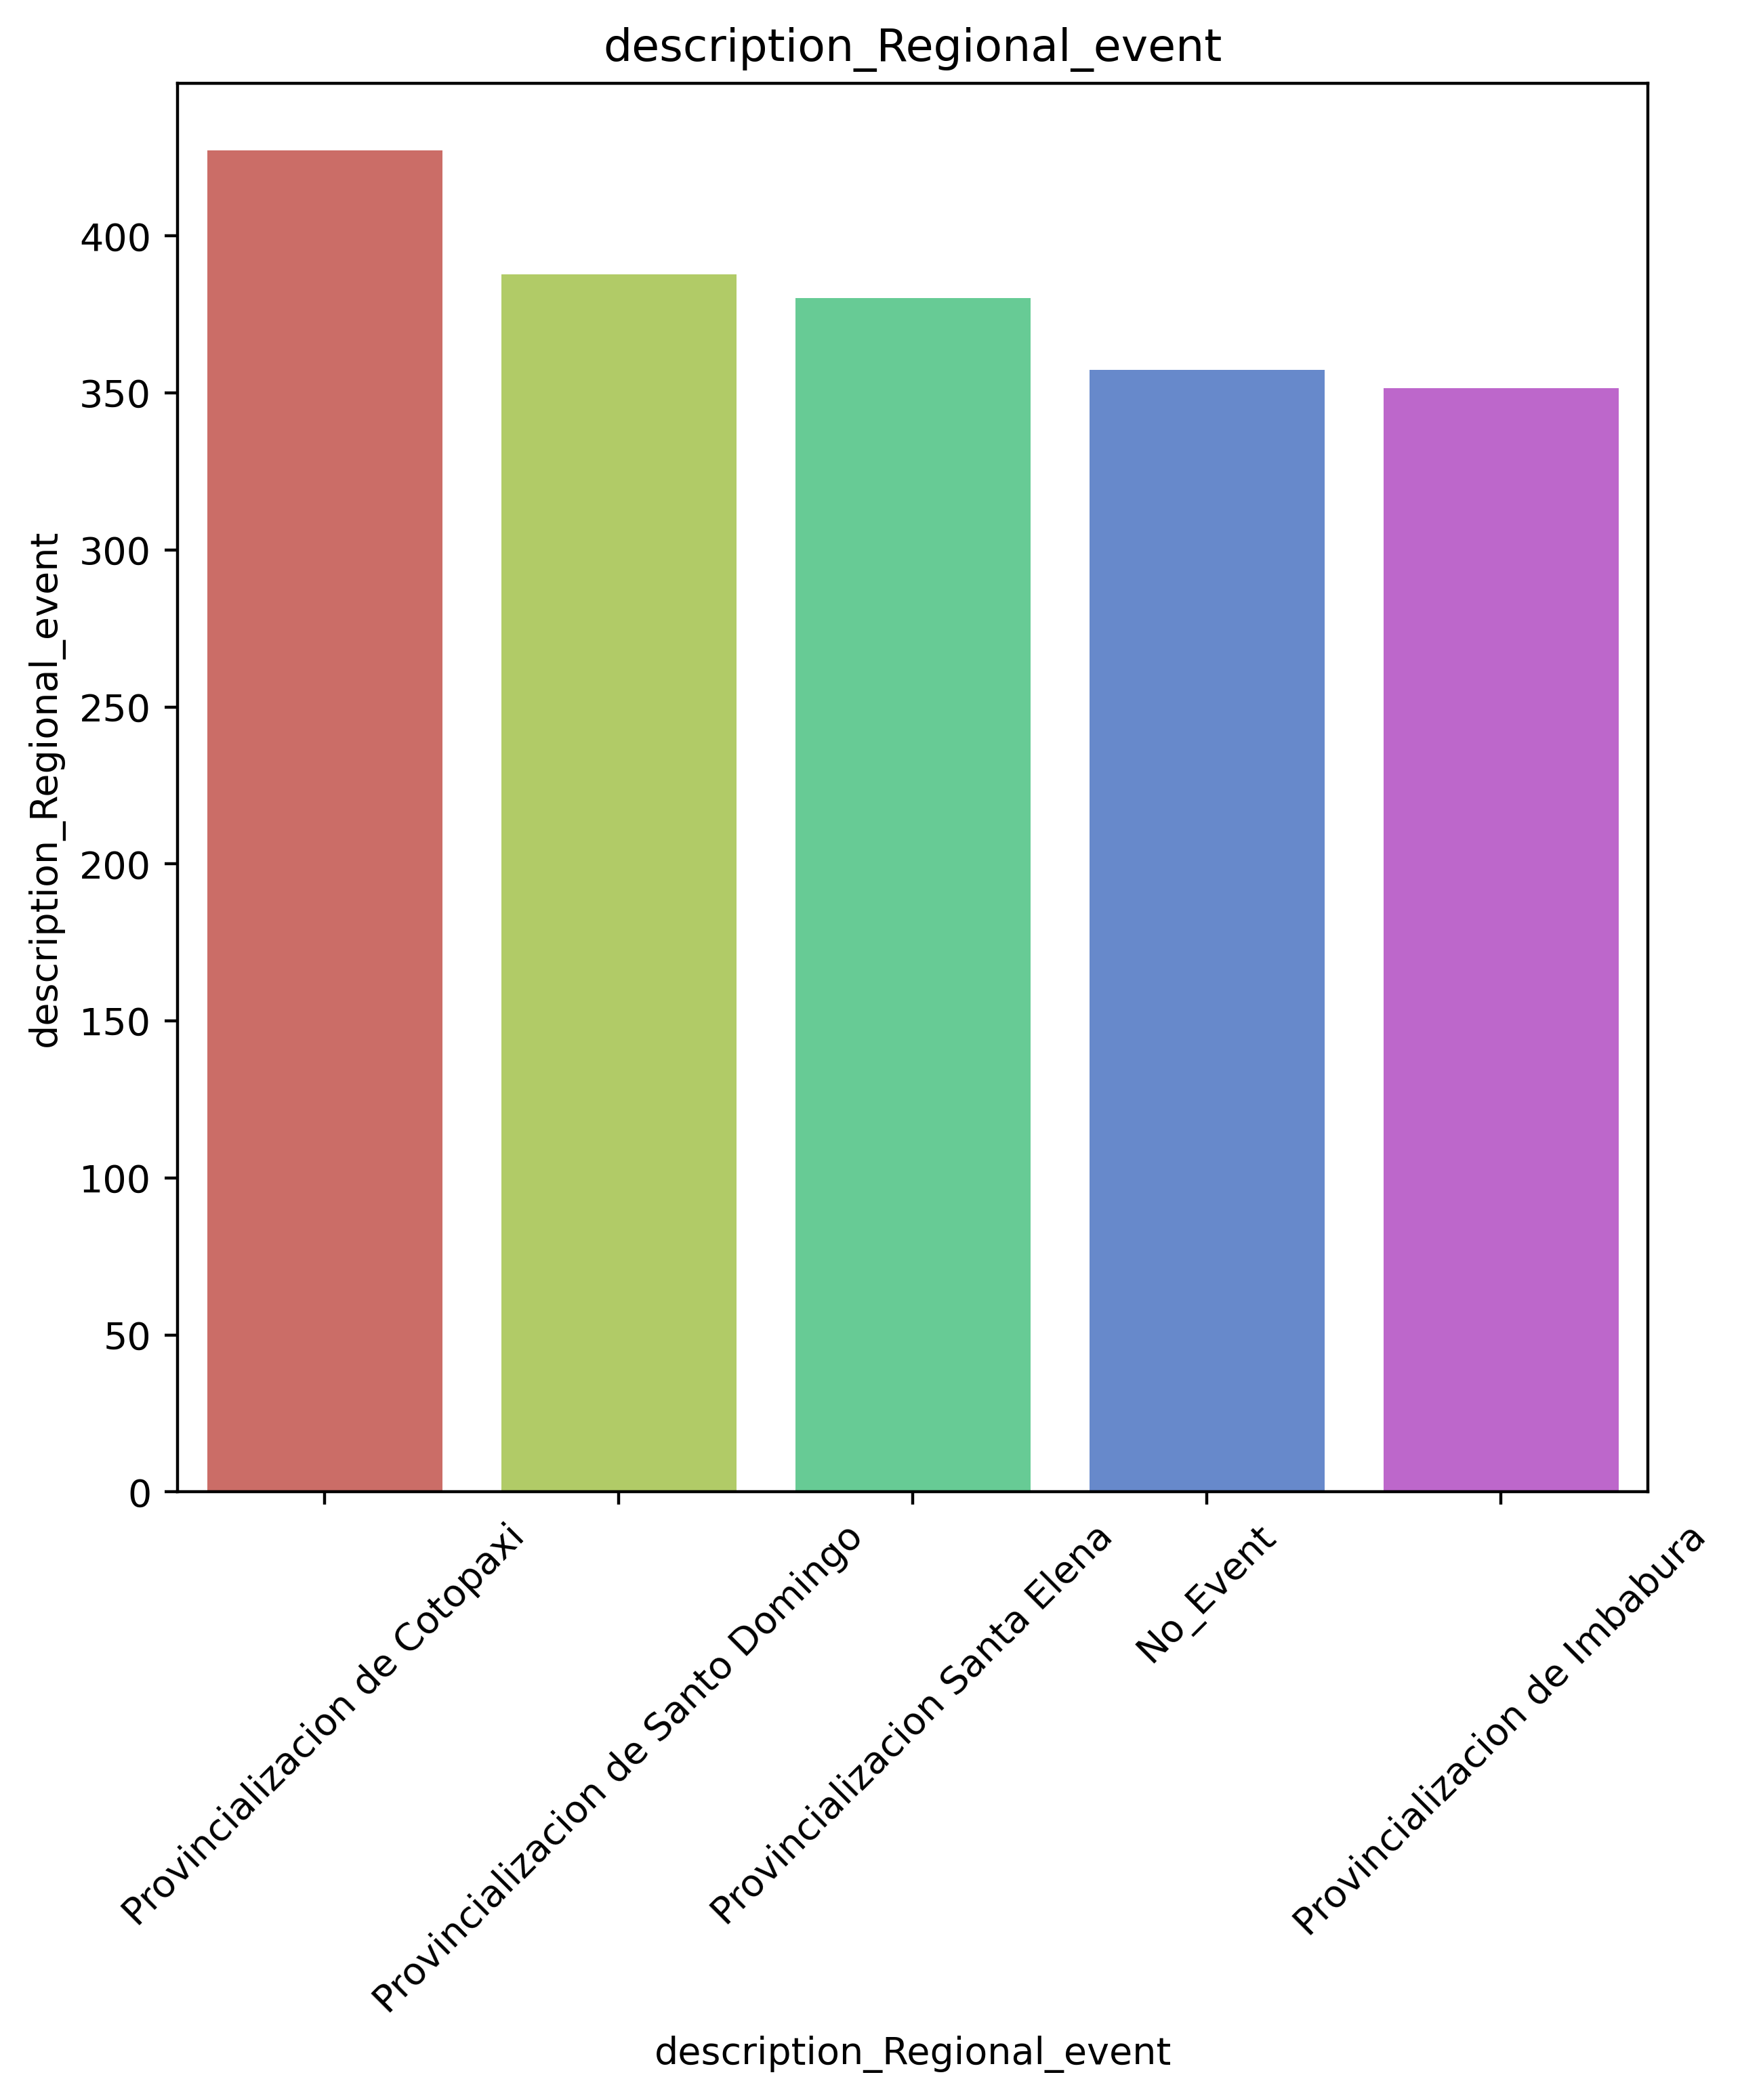

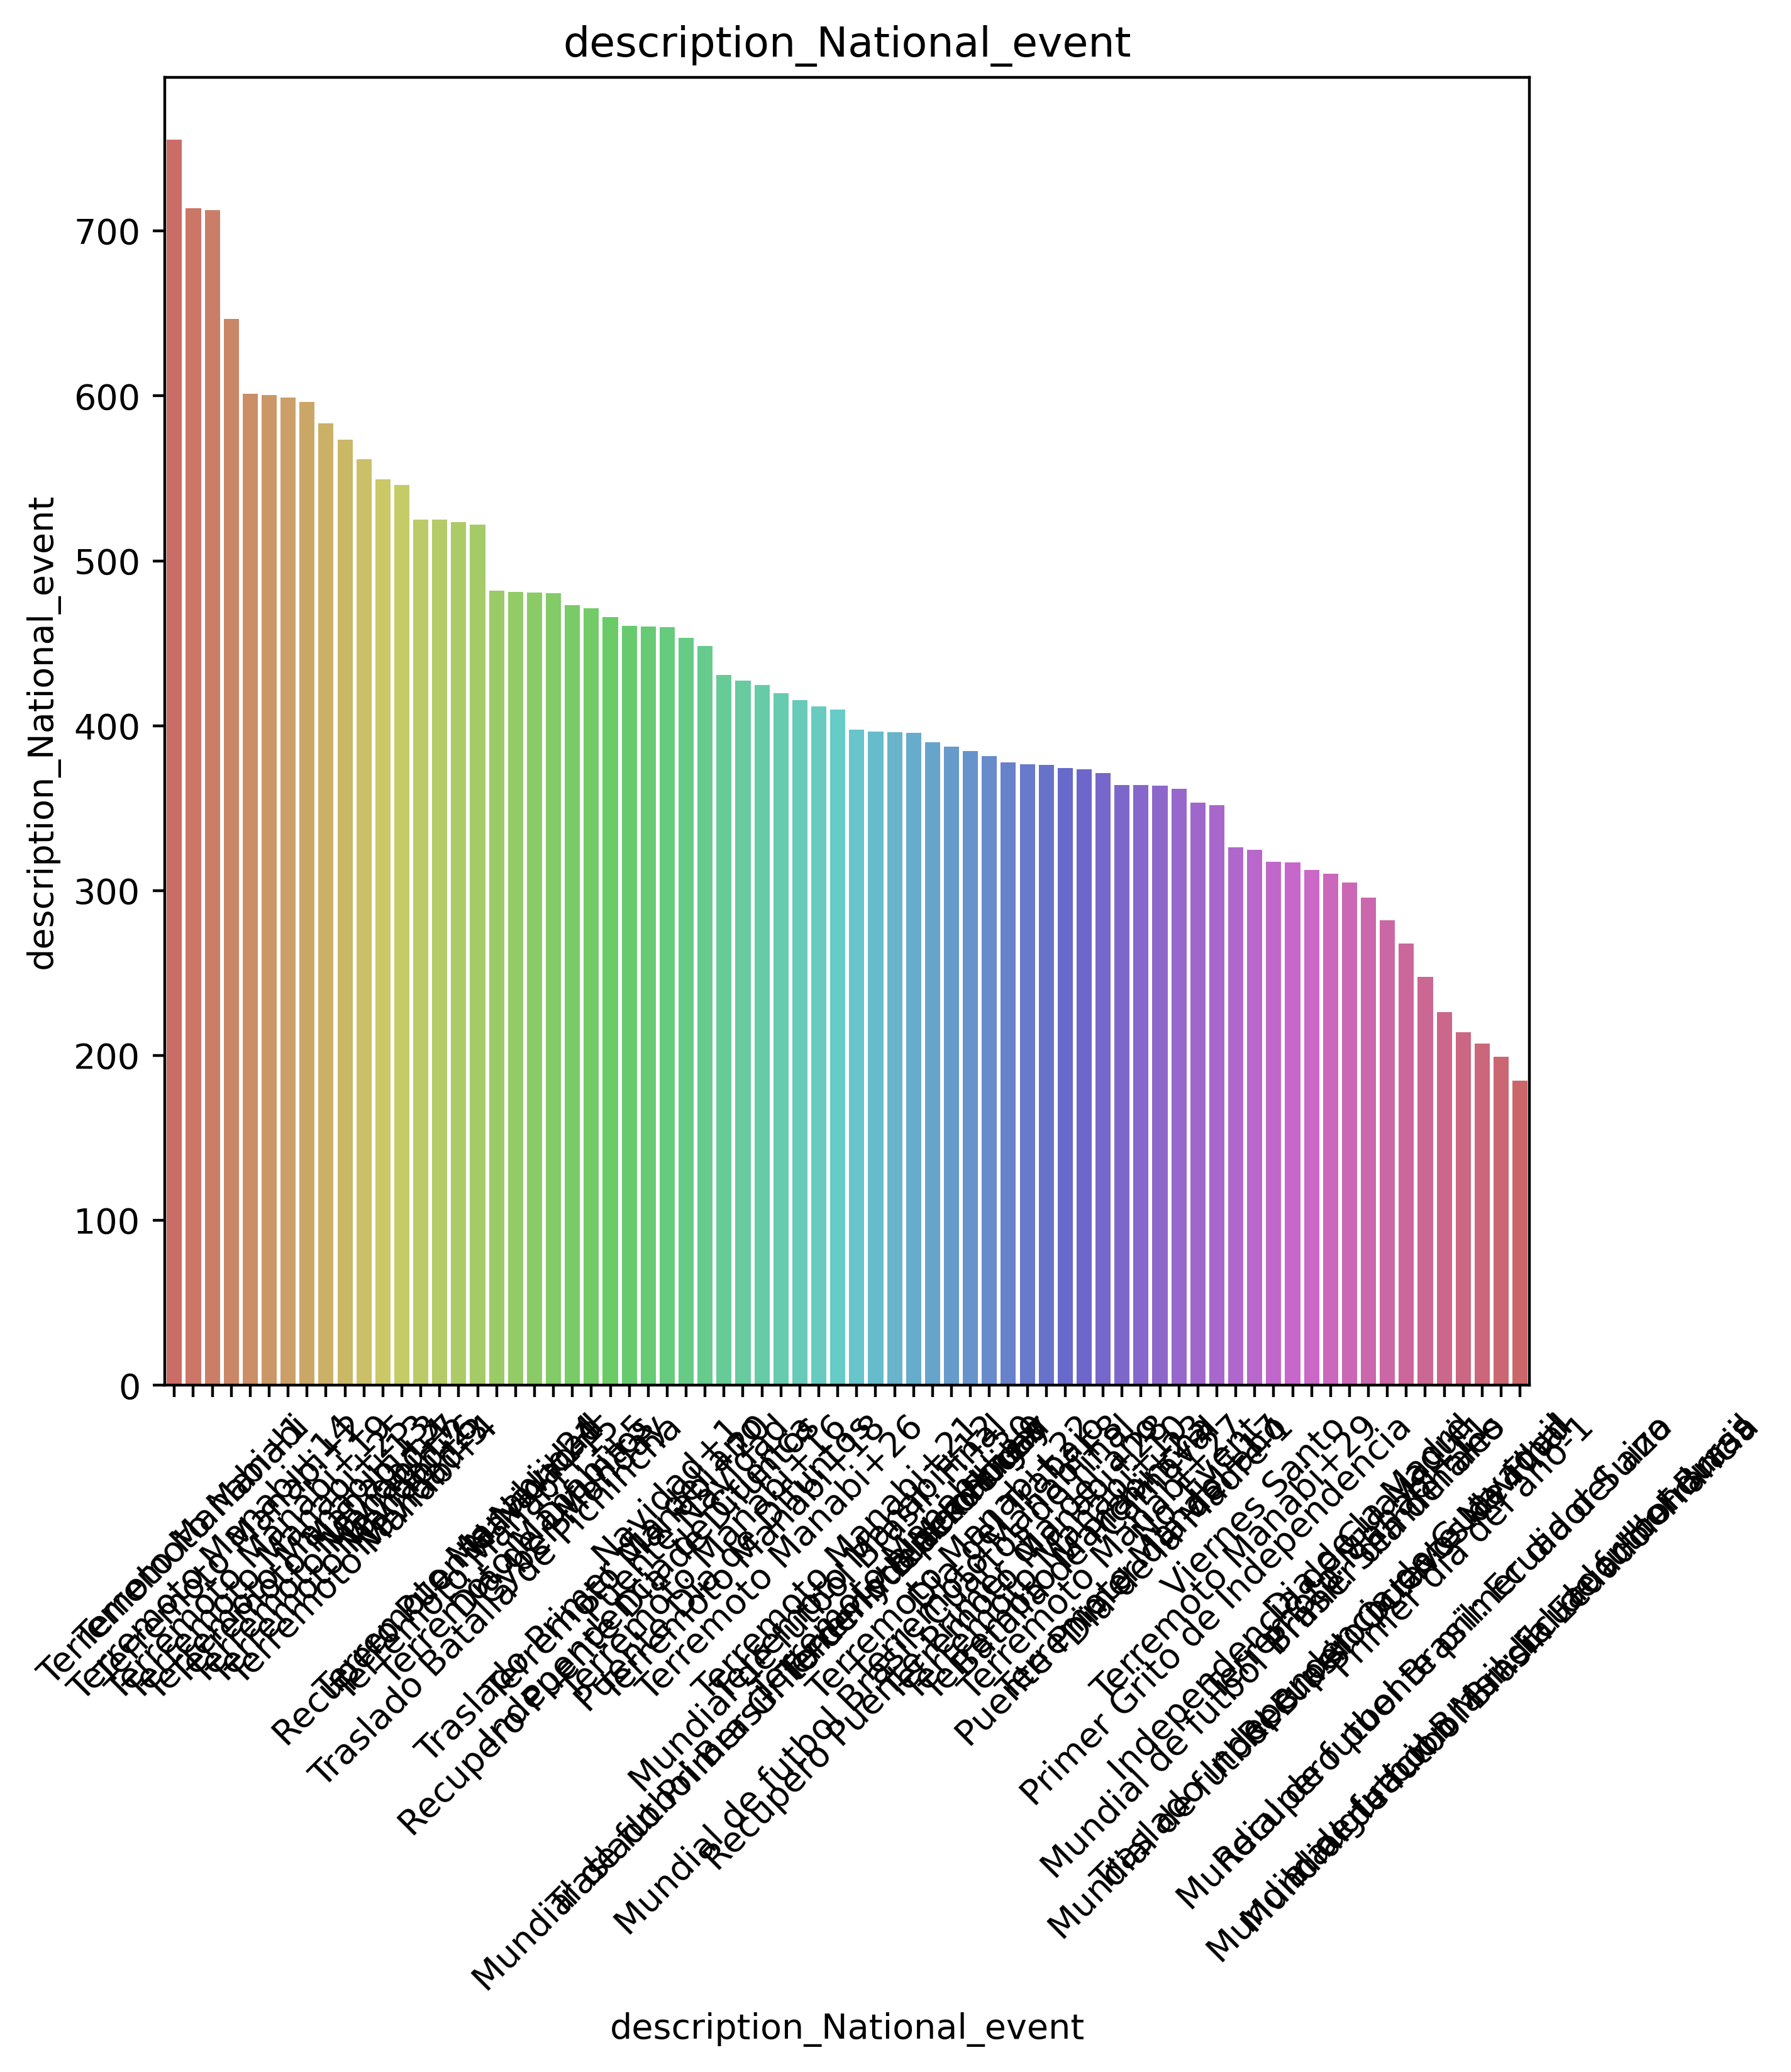

In [336]:
for col in ["description_Local_event", "description_Regional_event", "description_National_event"]:
    drow_barplot_mean_event(df_cat_columns, col, col)

### Результат
- Видно, что в зависимости от различных категории, target принимает различные значения
- Оставляем все категории

In [337]:
#Удалим колонки date, months, sales из df_cat_columns, так как они есть в  df_num_columns
df_cat_columns.drop(["date", "months", "sales"], axis=1, inplace=True)
print("Колонки успешно удалены")

Колонки успешно удалены


In [339]:
#Соединим датасеты
full_df_1 = pd.merge(left=df_num_columns, right=df_cat_columns, how="inner", left_index=True, right_index=True)

### Результат
- Было видно, что цена в среднем меняется со временем, обычно она растёт
- Если будем обучать модель на всех данных, тогда она будет учитывать старые зависимости, которые уже неактуальные, тогда принято решения взять последний кусочек данных и обучить на нём модель
- В качестве куска, будем брать данные, после чего валидироваться на кросс_валидации, пока качество будет падать, будем увеличивать размер данных иначе обрезаем данные, так как потом уже теряется зависимость
- Делаем данное дествие, так как мы хотим предсказывать цену на коротую ногу

In [412]:
#Оставляем данные только за 2017 год, остальное выкидываем
full_df = full_df_1.copy()
full_df = full_df[full_df["date"] >= "2017-01-08"]

In [413]:
#Посмотрим размеры
print(f"Количетсво объектов: {full_df.shape[0]}")

Количетсво объектов: 420552


In [414]:
full_df.reset_index(drop=True, inplace=True)

In [415]:
full_df.head()

date  store_nbr   sales  onpromotion  dcoilwtico  cluster  \
0 2017-01-08          1     0.0            0       53.98       13   
1 2017-01-08          1     0.0            0       53.98       13   
2 2017-01-08          1     1.0            1       53.98       13   
3 2017-01-08          1  1356.0           32       53.98       13   
4 2017-01-08          1     1.0            0       53.98       13   

   transactions  is_Local_event  is_Regional_event  is_National_event  \
0         558.0               0                  0                  0   
1         558.0               0                  0                  0   
2         558.0               0                  0                  0   
3         558.0               0                  0                  0   
4         558.0               0                  0                  0   

       family   city      state type description_National_event  \
0  AUTOMOTIVE  Quito  Pichincha    D                   No_Event   
1   BABY CARE  Quito  Pichincha    D                   No_Event   
2      BEAUTY  Quito  Pichincha    D                   No_Event   
3   BEVERAGES  Quito  Pichincha    D                   No_Event   
4       BOOKS  Quito  Pichincha    D                   No_Event   

  description_Regional_event description_Local_event  
0                   No_Event                No_Event  
1                   No_Event                No_Event  
2                   No_Event                No_Event  
3                   No_Event                No_Event  
4                   No_Event                No_Event

In [416]:
###Закодируем признаки
cv = TimeSeriesSplit(n_splits=10)

for col in ["family", "city", "state", "type", "description_National_event", "description_Regional_event", "description_Local_event"]:
    if full_df[col].nunique() <= 6:
        ohe = pd.get_dummies(data=full_df[col], prefix=col, drop_first=True, dtype="int")
        full_df = pd.concat([full_df, ohe], axis=1)
        full_df.drop(col, axis=1, inplace=True)
    else:
        mte_column = f"{col}_mte"
        full_df[mte_column] = 0.0
        for train_index, val_index in cv.split(full_df):
            mte_dict = full_df.iloc[train_index].groupby(col)["sales"].mean().to_dict()
            map_values = full_df.loc[val_index, col].map(mte_dict)
            
            noise = np.random.uniform(0.99, 1.01, size=len(map_values))

            full_df.loc[val_index, mte_column] = map_values * noise
            
        mean_target = full_df["sales"].mean()
        full_df[mte_column].fillna(mean_target, inplace=True)
        full_df.drop(col, axis=1, inplace=True)
print("Все колонки закодированы!")

Все колонки закодированы!


In [417]:
full_df.head()

date  store_nbr   sales  onpromotion  dcoilwtico  cluster  \
0 2017-01-08          1     0.0            0       53.98       13   
1 2017-01-08          1     0.0            0       53.98       13   
2 2017-01-08          1     1.0            1       53.98       13   
3 2017-01-08          1  1356.0           32       53.98       13   
4 2017-01-08          1     1.0            0       53.98       13   

   transactions  is_Local_event  is_Regional_event  is_National_event  ...  \
0         558.0               0                  0                  0  ...   
1         558.0               0                  0                  0  ...   
2         558.0               0                  0                  0  ...   
3         558.0               0                  0                  0  ...   
4         558.0               0                  0                  0  ...   

   city_mte  state_mte  type_B  type_C  type_D  type_E  \
0       0.0        0.0       0       0       1       0   
1       0.0        0.0       0       0       1       0   
2       0.0        0.0       0       0       1       0   
3       0.0        0.0       0       0       1       0   
4       0.0        0.0       0       0       1       0   

   description_National_event_mte  \
0                             0.0   
1                             0.0   
2                             0.0   
3                             0.0   
4                             0.0   

   description_Regional_event_Provincializacion de Cotopaxi  \
0                                                  0          
1                                                  0          
2                                                  0          
3                                                  0          
4                                                  0          

   description_Regional_event_Provincializacion de Imbabura  \
0                                                  0          
1                                                  0          
2                                                  0          
3                                                  0          
4                                                  0          

   description_Local_event_mte  
0                          0.0  
1                          0.0  
2                          0.0  
3                          0.0  
4                          0.0  

[5 rows x 21 columns]

In [419]:
### Удалим сильно коррелирующие признаки city_mte и description_Local_event_mte
full_df.drop(["city_mte", "description_Local_event_mte"], axis=1, inplace=True)
print("Данные признаки были удалены!")

Данные признаки были удалены!


In [ ]:
fig = plt.figure(figsize=(15, 15), dpi=400)
sns.heatmap(full_df.drop(["date", "store_nbr"], axis=1).corr(), annot=True, linewidths=1)
plt.show()

In [420]:
full_df.sort_values(["date", "store_nbr"], inplace=True)

In [421]:
X, y = full_df[full_df["sales"].notna()].drop(["sales", "date", "store_nbr"], axis=1),  full_df[full_df["sales"].notna()]["sales"]

### Обучим модель дерева с различными гиперпараметрами

In [241]:
tree_model = DecisionTreeRegressor()

cv = TimeSeriesSplit(n_splits=6)

param_grid = {
    "max_depth": [23, 25, 28],
    "min_samples_split": [20, 25, 30],
    "min_samples_leaf": [10, 12, 15]
}

grid = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=cv, n_jobs=-1, scoring="neg_mean_squared_error", verbose=1)

In [242]:
grid.fit(X, y)

Fitting 6 folds for each of 27 candidates, totalling 162 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=6, test_size=None),
             estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [23, 25, 28],
                         'min_samples_leaf': [10, 12, 15],
                         'min_samples_split': [20, 25, 30]},
             scoring='neg_mean_squared_error', verbose=1)

In [232]:
print("Лучшие параметры:", grid.best_params_)
print("Лучший MSE:", -grid.best_score_)

Лучшие параметры: {'max_depth': 25, 'min_impurity_decrease': 1, 'min_samples_leaf': 15, 'min_samples_split': 20}
Лучший MSE: 204380.7765778658


### Обучим беггинг с различными гиперпараметрами

In [410]:
bagging_model = BaggingRegressor(estimator=DecisionTreeRegressor())

cv = TimeSeriesSplit(n_splits=8)

param_grid = {
    "n_estimators": [40],
    "max_samples": [0.75]
}

grid = GridSearchCV(estimator=bagging_model, param_grid=param_grid, cv=cv, verbose=10, scoring="neg_mean_squared_error")

In [354]:
#Для данных от 2016-06-01 до 2017-08-15 кросс-валидация на 14 частей, так как тестируемся на каждом месяце
grid.fit(X, y)

Fitting 14 folds for each of 1 candidates, totalling 14 fits
[CV 1/14; 1/1] START max_samples=0.75, n_estimators=40..........................
[CV 1/14; 1/1] END max_samples=0.75, n_estimators=40;, score=-813381.874 total time=   2.4s
[CV 2/14; 1/1] START max_samples=0.75, n_estimators=40..........................
[CV 2/14; 1/1] END max_samples=0.75, n_estimators=40;, score=-139758.254 total time=   9.6s
[CV 3/14; 1/1] START max_samples=0.75, n_estimators=40..........................
[CV 3/14; 1/1] END max_samples=0.75, n_estimators=40;, score=-93606.003 total time=  21.1s
[CV 4/14; 1/1] START max_samples=0.75, n_estimators=40..........................
[CV 4/14; 1/1] END max_samples=0.75, n_estimators=40;, score=-264242.630 total time=  34.0s
[CV 5/14; 1/1] START max_samples=0.75, n_estimators=40..........................
[CV 5/14; 1/1] END max_samples=0.75, n_estimators=40;, score=-92546.393 total time=  49.5s
[CV 6/14; 1/1] START max_samples=0.75, n_estimators=40......................

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=14, test_size=None),
             estimator=BaggingRegressor(estimator=DecisionTreeRegressor()),
             param_grid={'max_samples': [0.75], 'n_estimators': [40]},
             scoring='neg_mean_squared_error', verbose=10)

In [355]:
print("Лучшие параметры:", grid.best_params_)
print("Лучший MSE:", -grid.best_score_)

Лучшие параметры: {'max_samples': 0.75, 'n_estimators': 40}
Лучший MSE: 201457.7053480395


### Результат
- Видно, что модель ведет себя нестабильно от того или иного временного промежутка, так как зависимость каждый раз меняется
- Теперь возьмем дату с 2016-08-15 до 2017-08-15 кросс-валидация на 12 частей

In [368]:
#Для данных от 2016-08-15 до 2017-08-15 кросс-валидация на 12 частей, так как тестируемся на каждом месяце
grid.fit(X, y)

Fitting 12 folds for each of 1 candidates, totalling 12 fits
[CV 1/12; 1/1] START max_samples=0.75, n_estimators=40..........................
[CV 1/12; 1/1] END max_samples=0.75, n_estimators=40;, score=-1089077.399 total time=   2.1s
[CV 2/12; 1/1] START max_samples=0.75, n_estimators=40..........................
[CV 2/12; 1/1] END max_samples=0.75, n_estimators=40;, score=-131385.444 total time=  10.5s
[CV 3/12; 1/1] START max_samples=0.75, n_estimators=40..........................
[CV 3/12; 1/1] END max_samples=0.75, n_estimators=40;, score=-145475.515 total time=  21.8s
[CV 4/12; 1/1] START max_samples=0.75, n_estimators=40..........................
[CV 4/12; 1/1] END max_samples=0.75, n_estimators=40;, score=-530772.397 total time=  34.7s
[CV 5/12; 1/1] START max_samples=0.75, n_estimators=40..........................
[CV 5/12; 1/1] END max_samples=0.75, n_estimators=40;, score=-206143.396 total time=  46.6s
[CV 6/12; 1/1] START max_samples=0.75, n_estimators=40...................

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=12, test_size=None),
             estimator=BaggingRegressor(estimator=DecisionTreeRegressor()),
             param_grid={'max_samples': [0.75], 'n_estimators': [40]},
             scoring='neg_mean_squared_error', verbose=10)

In [385]:
print("Лучшие параметры:", grid.best_params_)
print("Лучший MSE:", -grid.best_score_)

Лучшие параметры: {'max_samples': 0.75, 'n_estimators': 40}
Лучший MSE: 235432.32542423235


### Результат
- Также видно в некоторых местах, что предсказание модели могут колебаться, возьмем дату ещё раньше

In [384]:
#Для данных от 2016-10-15 до 2017-08-15 кросс-валидация на 10 частей, так как тестируемся на каждом месяце
grid.fit(X, y)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10; 1/1] START max_samples=0.75, n_estimators=40..........................
[CV 1/10; 1/1] END max_samples=0.75, n_estimators=40;, score=-717100.882 total time=   3.0s
[CV 2/10; 1/1] START max_samples=0.75, n_estimators=40..........................
[CV 2/10; 1/1] END max_samples=0.75, n_estimators=40;, score=-585570.183 total time=  12.3s
[CV 3/10; 1/1] START max_samples=0.75, n_estimators=40..........................
[CV 3/10; 1/1] END max_samples=0.75, n_estimators=40;, score=-160959.091 total time=  25.3s
[CV 4/10; 1/1] START max_samples=0.75, n_estimators=40..........................
[CV 4/10; 1/1] END max_samples=0.75, n_estimators=40;, score=-118351.185 total time=  37.7s
[CV 5/10; 1/1] START max_samples=0.75, n_estimators=40..........................
[CV 5/10; 1/1] END max_samples=0.75, n_estimators=40;, score=-101799.684 total time=  50.2s
[CV 6/10; 1/1] START max_samples=0.75, n_estimators=40....................

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=BaggingRegressor(estimator=DecisionTreeRegressor()),
             param_grid={'max_samples': [0.75], 'n_estimators': [40]},
             scoring='neg_mean_squared_error', verbose=10)

In [386]:
print("Лучшие параметры:", grid.best_params_)
print("Лучший MSE:", -grid.best_score_)

Лучшие параметры: {'max_samples': 0.75, 'n_estimators': 40}
Лучший MSE: 216088.48952372133


### Результат, теперь модель ведет себя более стабильно, чем раньше
- Теперь сократим дату еще сильнее с 2017-01-15 до 2017-08-15

In [398]:
#Для данных от 2017-01-15 до 2017-08-15 кросс-валидация на 8 частей, так как тестируемся на каждом месяце
grid.fit(X, y)

Fitting 8 folds for each of 1 candidates, totalling 8 fits
[CV 1/8; 1/1] START max_samples=0.75, n_estimators=40...........................
[CV 1/8; 1/1] END max_samples=0.75, n_estimators=40;, score=-366605.497 total time=   3.0s
[CV 2/8; 1/1] START max_samples=0.75, n_estimators=40...........................
[CV 2/8; 1/1] END max_samples=0.75, n_estimators=40;, score=-169143.758 total time=  12.4s
[CV 3/8; 1/1] START max_samples=0.75, n_estimators=40...........................
[CV 3/8; 1/1] END max_samples=0.75, n_estimators=40;, score=-142273.807 total time=  21.3s
[CV 4/8; 1/1] START max_samples=0.75, n_estimators=40...........................
[CV 4/8; 1/1] END max_samples=0.75, n_estimators=40;, score=-136249.367 total time=  32.9s
[CV 5/8; 1/1] START max_samples=0.75, n_estimators=40...........................
[CV 5/8; 1/1] END max_samples=0.75, n_estimators=40;, score=-104101.721 total time=  43.6s
[CV 6/8; 1/1] START max_samples=0.75, n_estimators=40...........................


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=BaggingRegressor(estimator=DecisionTreeRegressor()),
             param_grid={'max_samples': [0.75], 'n_estimators': [40]},
             scoring='neg_mean_squared_error', verbose=10)

In [409]:
print("Лучшие параметры:", grid.best_params_)
print("Лучший MSE:", -grid.best_score_)

Лучшие параметры: {'max_samples': 0.75, 'n_estimators': 40}
Лучший MSE: 150842.34383872076


### Результат
- Видно, что качетсво стало лучше, но возьмем данные на неделю позже, так как там прошел новый год, из-за которого очень сильно сбился прогноз

In [422]:
#Для данных от 2017-01-08 до 2017-08-15 кросс-валидация на 8 частей, так как тестируемся на каждом месяце
grid.fit(X, y)

Fitting 8 folds for each of 1 candidates, totalling 8 fits
[CV 1/8; 1/1] START max_samples=0.75, n_estimators=40...........................
[CV 1/8; 1/1] END max_samples=0.75, n_estimators=40;, score=-485436.966 total time=   3.0s
[CV 2/8; 1/1] START max_samples=0.75, n_estimators=40...........................
[CV 2/8; 1/1] END max_samples=0.75, n_estimators=40;, score=-163238.226 total time=  12.1s
[CV 3/8; 1/1] START max_samples=0.75, n_estimators=40...........................
[CV 3/8; 1/1] END max_samples=0.75, n_estimators=40;, score=-148934.689 total time=  22.0s
[CV 4/8; 1/1] START max_samples=0.75, n_estimators=40...........................
[CV 4/8; 1/1] END max_samples=0.75, n_estimators=40;, score=-159968.398 total time=  33.5s
[CV 5/8; 1/1] START max_samples=0.75, n_estimators=40...........................
[CV 5/8; 1/1] END max_samples=0.75, n_estimators=40;, score=-118908.463 total time=  45.5s
[CV 6/8; 1/1] START max_samples=0.75, n_estimators=40...........................


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=BaggingRegressor(estimator=DecisionTreeRegressor()),
             param_grid={'max_samples': [0.75], 'n_estimators': [40]},
             scoring='neg_mean_squared_error', verbose=10)

In [489]:
print("Лучшие параметры:", grid.best_params_)
print("Лучший MSE:", -grid.best_score_)

Лучшие параметры: {'max_samples': 0.75, 'n_estimators': 40}
Лучший MSE: 169483.0945780654


### Резкльтаты стали стабильные, тогда оставим эту дату

# Генерация признаков
Так как мы предсказываем цену  товаров в магазине на ближайшие 15 дней, тогда генерация признаков будет происходить от последнего месяца в тренировочных данных
### Временные признаки
- Признак месяца
- Признак недели по порядку
- Признак день в месяце
- Признак день недели
- Признак день в году
- Признак (бинарный), выходной или рабочий день

### Признаки из лагов
- Генерация признаков из лагов в промежутке [1, 2, 3, 7, 14, 28]

### Генерация статистик признаков по промежуткам: [1, 2, 3, 7, 14, 28] для каждого магазина и для каждого семейства товаров по колонку sales
- Признак скользящее среднее
- Признак скользящие стандартное отклонение
- Признак медиана по промежутку
- **Важно, чтобы данные статистики были рассчитаны для колонки sales не вклюдая дату по которой будет склеивания, чтобы предотвратить утечку данных**


In [453]:
full_df_1.to_csv("preprocessed_data_sales.csv")

In [678]:
#Возьмем пока данные, начиная с 2016-11-01, когда посчитаем лаги, то сократим до 2017-01-08
full_df = full_df_1.copy()
full_df = full_df[full_df["date"] >= "2016-11-01"]

In [679]:
#Размах тренировочных данных во времени
max(pd.to_datetime(test_df["date"])) - min(pd.to_datetime(test_df["date"]))

Timedelta('15 days 00:00:00')

In [680]:
#Генерация лагов за 7, 14, 21, 28 дней назад для sales
#Но будем считать со сдвигом на 15 дней, чтобы не было пропусков в тестовых данных
scope = 15
for lag in [1+scope, 8+scope, 15+scope, 22+scope]:
    full_df[f"sales_lag_{lag}"] = full_df.groupby(["store_nbr", "family"])["sales"].shift(lag)
for lag in [7, 14, 21, 28]:
    full_df[f"dcoilwtico_lag_{lag}"] = full_df.groupby(["store_nbr", "family"])["dcoilwtico"].shift(lag)
for lag in [1, 3, 5, 7, 10]:
    full_df[f"onpromotion_lag_{lag}"] = full_df.groupby(["store_nbr", "family"])["onpromotion"].shift(lag)

In [681]:
#Создадим бинарные признак, была ли промоакция
full_df["is_promotion"] = full_df["onpromotion"].apply(lambda x: 1 if x > 0 else 0).astype(int)

In [682]:
#Создадим признаки из скользящих статистик(среднее, медианное, максимальное, минимальное, std) для колонок sales
#Для колонок is_promotion посчитаем, сколько было дней проакций
#Для колонки onpromotion посчитаем сумму промоакций, среднее, std, min, max, медианное
scope = 16
windows = [7, 14, 21, 28]
#Скользящие статистики для целевой переменной (sales)
for window in windows:
    full_df[f"mean_window_sales_{window}"] = full_df.groupby(["store_nbr", "family"])["sales"].shift(scope).rolling(window).mean()
    full_df[f"median_window_sales_{window}"] = full_df.groupby(["store_nbr", "family"])["sales"].shift(scope).rolling(window).median()
    full_df[f"max_window_sales_{window}"] = full_df.groupby(["store_nbr", "family"])["sales"].shift(scope).rolling(window).max()
    full_df[f"min_window_sales_{window}"] = full_df.groupby(["store_nbr", "family"])["sales"].shift(scope).rolling(window).min()
    full_df[f"var_window_sales_{window}"] = full_df.groupby(["store_nbr", "family"])["sales"].shift(scope).rolling(window).var()

#Скользящие статисики для is_promotion
for window in windows:
    full_df[f"sum_days_is_promotion_{window}"] = full_df.groupby(["store_nbr", "family"])["is_promotion"].shift(1).rolling(window).sum()
    full_df[f"mean_days_is_promotion_{window}"] = full_df.groupby(["store_nbr", "family"])["is_promotion"].shift(1).rolling(window).mean()

#Скользящие статистики для onpromotion
for window in windows:
    full_df[f"mean_window_onpromotion_{window}"] = full_df.groupby(["store_nbr", "family"])["onpromotion"].shift(1).rolling(window).mean()
    full_df[f"median_window_onpromotion_{window}"] = full_df.groupby(["store_nbr", "family"])["onpromotion"].shift(1).rolling(window).median()
    full_df[f"max_window_onpromotion_{window}"] = full_df.groupby(["store_nbr", "family"])["onpromotion"].shift(1).rolling(window).max()
    full_df[f"min_window_onpromotion_{window}"] = full_df.groupby(["store_nbr", "family"])["onpromotion"].shift(1).rolling(window).min()
    full_df[f"var_window_onpromotion_{window}"] = full_df.groupby(["store_nbr", "family"])["onpromotion"].shift(1).rolling(window).var()
    full_df[f"sum_window_onpromotion_{window}"] = full_df.groupby(["store_nbr", "family"])["onpromotion"].shift(1).rolling(window).sum()

In [683]:
#Обрежем данные до 2017-01-08, чтобы при 
full_df = full_df[full_df["date"] >= "2017-01-08"]

In [684]:
#Генерация признаков связанные с датой
#1. месяц в году
full_df["month"] = full_df["date"].dt.month
#2. Неделя в году
full_df["week_of_year"] = full_df['date'].dt.isocalendar().week.astype(int)
#3. День в месяце
full_df['day_of_month'] = full_df['date'].dt.day
# День недели
full_df['day_of_week'] = full_df['date'].dt.dayofweek 
# День в году 
full_df['day_of_year'] = full_df['date'].dt.dayofyear
# Является ли день выходным
full_df['is_weekend'] = (full_df['date'].dt.dayofweek >= 5).astype(int)
# Является ли день началом месяца
full_df['is_month_start'] = full_df['date'].dt.is_month_start.astype(int)
# Является ли день концом месяца
full_df['is_month_end'] = full_df['date'].dt.is_month_end.astype(int)

In [685]:
#Перезапишем индескы, для кодировки
full_df.reset_index(drop=True, inplace=True)

In [686]:
###Закодируем признаки
cv = TimeSeriesSplit(n_splits=10)

for col in ["family", "city", "state", "type", "description_National_event", "description_Regional_event", "description_Local_event"]:
    if full_df[col].nunique() <= 6:
        ohe = pd.get_dummies(data=full_df[col], prefix=col, drop_first=True, dtype="int")
        full_df = pd.concat([full_df, ohe], axis=1)
        full_df.drop(col, axis=1, inplace=True)
    else:
        mte_column = f"{col}_mte"
        full_df[mte_column] = 0.0
        for train_index, val_index in cv.split(full_df):
            mte_dict = full_df.iloc[train_index].groupby(col)["sales"].mean().to_dict()
            map_values = full_df.loc[val_index, col].map(mte_dict)
            
            noise = np.random.uniform(0.99, 1.01, size=len(map_values))

            full_df.loc[val_index, mte_column] = map_values * noise
            
        mean_target = full_df["sales"].mean()
        full_df[mte_column].fillna(mean_target, inplace=True)
        full_df.drop(col, axis=1, inplace=True)
print("Все колонки закодированы!")

Все колонки закодированы!


In [576]:
#Видно, что корреляция между признаками есть
num_columns = full_df.drop("sales", axis=1).columns
dict_corr = dict()
for i in range(len(num_columns)):
    for j in range(i, len(num_columns)):
        if i != j:
            dict_corr[f"{num_columns[i]}-{num_columns[j]}"] = round(float(full_df[[num_columns[i], num_columns[j]]].corr().iloc[0][1]), 3)

In [577]:
sorted_items = sorted(dict_corr.items(), key=lambda item: abs(item[1]))
sorted_items[-30:]

[('day_of_month-is_month_start', -0.303),
 ('week_of_year-state_mte', 0.304),
 ('day_of_year-state_mte', 0.304),
 ('month-city_mte', 0.309),
 ('day_of_month-is_month_end', 0.309),
 ('state_mte-type_C', -0.309),
 ('month-state_mte', 0.312),
 ('city_mte-type_C', -0.338),
 ('is_month_start-description_Regional_event_Provincializacion de Cotopaxi',
  0.373),
 ('type_C-type_D', -0.439),
 ('week_of_year-description_Local_event_mte', 0.512),
 ('day_of_year-description_Local_event_mte', 0.512),
 ('week_of_year-description_National_event_mte', 0.521),
 ('day_of_year-description_National_event_mte', 0.521),
 ('month-description_Local_event_mte', 0.525),
 ('month-description_National_event_mte', 0.534),
 ('city_mte-description_National_event_mte', 0.582),
 ('city_mte-description_Local_event_mte', 0.582),
 ('state_mte-description_National_event_mte', 0.588),
 ('state_mte-description_Local_event_mte', 0.588),
 ('day_of_week-is_weekend', 0.792),
 ('mean_window_onpromotion_28-var_window_onpromotion_2

In [687]:
#Удалим сильно коррелирующие признаки
full_df.drop(["month", "week_of_year", "mean_window_onpromotion_28", "state_mte",
              "sum_window_onpromotion_28", "mean_window_onpromotion_28", "sales_lag_37", "description_Local_event_mte",
             "max_window_onpromotion_28", "sum_window_onpromotion_14"], axis=1, inplace=True)
print("Сильно коррелирующие колонки успешно удалены")

Сильно коррелирующие колонки успешно удалены


In [688]:
#Удалим данные колонки, так как один все одинаковы, константный признак
full_df.drop(["min_window_onpromotion_14", "min_window_onpromotion_21", "min_window_onpromotion_28"], axis=1, inplace=True)
print("Данные признаки успешно удалены!")

Данные признаки успешно удалены!


In [580]:
#Видно, что корреляция между признаками есть
num_columns = full_df.drop("sales", axis=1).columns
dict_corr = dict()
for i in range(len(num_columns)):
    for j in range(i, len(num_columns)):
        if i != j:
            dict_corr[f"{num_columns[i]}-{num_columns[j]}"] = round(float(full_df[[num_columns[i], num_columns[j]]].corr().iloc[0][1]), 3)

In [582]:
#Проверим еще раз
sorted_items = sorted(dict_corr.items(), key=lambda item: abs(item[1]))
sorted_items[-40:]

[('var_window_onpromotion_14-var_window_onpromotion_21', 0.841),
 ('max_window_onpromotion_7-var_window_onpromotion_7', 0.842),
 ('max_window_sales_14-mean_window_sales_21', 0.846),
 ('mean_window_onpromotion_14-max_window_onpromotion_14', 0.856),
 ('max_window_sales_21-var_window_sales_28', 0.863),
 ('max_window_onpromotion_14-var_window_onpromotion_14', 0.866),
 ('var_window_sales_21-mean_window_sales_28', 0.873),
 ('mean_window_sales_14-var_window_sales_14', 0.876),
 ('max_window_onpromotion_21-var_window_onpromotion_21', 0.878),
 ('mean_window_sales_14-mean_window_sales_21', 0.88),
 ('max_window_sales_14-var_window_sales_14', 0.884),
 ('var_window_onpromotion_21-var_window_onpromotion_28', 0.886),
 ('max_window_sales_7-var_window_sales_7', 0.887),
 ('var_window_sales_14-var_window_sales_21', 0.888),
 ('max_window_sales_21-var_window_sales_21', 0.893),
 ('mean_window_sales_21-var_window_sales_21', 0.9),
 ('mean_window_onpromotion_7-max_window_onpromotion_7', 0.903),
 ('max_window_on

In [689]:
#Слева сильно коррелирующие колонки
full_df.drop(["mean_days_is_promotion_7", "mean_days_is_promotion_14", "mean_days_is_promotion_21", "mean_days_is_promotion_28",
             "sum_window_onpromotion_7", "sum_window_onpromotion_21"], axis=1, inplace=True)
print("Колонки удалены")

Колонки удалены


In [585]:
#Видно, что корреляция между признаками есть
num_columns = full_df.drop("sales", axis=1).columns
dict_corr = dict()
for i in range(len(num_columns)):
    for j in range(i, len(num_columns)):
        if i != j:
            dict_corr[f"{num_columns[i]}-{num_columns[j]}"] = round(float(full_df[[num_columns[i], num_columns[j]]].corr().iloc[0][1]), 3)

In [593]:
#Проверим еще раз
sorted_items = sorted(dict_corr.items(), key=lambda item: abs(item[1]))
sorted_items[-50:]

[('max_window_sales_14-max_window_sales_21', 0.798),
 ('sum_days_is_promotion_14-sum_days_is_promotion_21', 0.799),
 ('mean_window_sales_7-mean_window_sales_14', 0.807),
 ('mean_window_onpromotion_14-mean_window_onpromotion_21', 0.81),
 ('max_window_onpromotion_14-max_window_onpromotion_21', 0.811),
 ('dcoilwtico-dcoilwtico_lag_7', 0.815),
 ('dcoilwtico_lag_7-dcoilwtico_lag_14', 0.822),
 ('dcoilwtico_lag_14-dcoilwtico_lag_21', 0.822),
 ('var_window_sales_14-var_window_sales_28', 0.822),
 ('sum_days_is_promotion_21-sum_days_is_promotion_28', 0.822),
 ('var_window_sales_14-mean_window_sales_21', 0.824),
 ('mean_window_sales_21-max_window_sales_28', 0.824),
 ('mean_window_sales_21-var_window_sales_28', 0.826),
 ('dcoilwtico_lag_21-dcoilwtico_lag_28', 0.827),
 ('mean_window_onpromotion_21-max_window_onpromotion_21', 0.835),
 ('var_window_sales_21-max_window_sales_28', 0.837),
 ('mean_window_sales_7-var_window_sales_7', 0.838),
 ('var_window_onpromotion_14-var_window_onpromotion_21', 0.841)

### Проблема, очень много коррелирубщих колонок
- Решение, уберем колонки, где корреляция превышается **|0.85|**, оставим те, у которых корреляция с таргетом сильнее

In [690]:
drop_columns = list(set(["max_window_sales_7", "sales_lag_30", "var_window_sales_21", "onpromotion_lag_10", "max_window_sales_28", "onpromotion_lag_7",
               "var_window_sales_28", "max_window_onpromotion_7", "var_window_sales_21", "var_window_sales_7", "var_window_onpromotion_28",
                "var_window_onpromotion_21", "var_window_sales_14", "mean_window_sales_21", "var_window_onpromotion_21", "max_window_onpromotion_21",
                        "var_window_sales_14"]))

In [691]:
full_df.drop(drop_columns, axis=1, inplace=True)
print("Сильно коррелирующие колонки были удалены")

Сильно коррелирующие колонки были удалены


In [692]:
num_columns = full_df.drop("sales", axis=1).columns
dict_corr = dict()
for i in range(len(num_columns)):
    for j in range(i, len(num_columns)):
        if i != j:
            dict_corr[f"{num_columns[i]}-{num_columns[j]}"] = round(float(full_df[[num_columns[i], num_columns[j]]].corr().iloc[0][1]), 3)

In [693]:
#Проверим еще раз
sorted_items = sorted(dict_corr.items(), key=lambda item: abs(item[1]))
sorted_items[-30:]

[('sum_days_is_promotion_14-median_window_onpromotion_14', 0.722),
 ('sales_lag_16-family_mte', 0.723),
 ('sum_days_is_promotion_7-sum_days_is_promotion_14', 0.724),
 ('date-dcoilwtico_lag_14', -0.739),
 ('dcoilwtico_lag_14-day_of_year', -0.739),
 ('date-dcoilwtico_lag_21', -0.747),
 ('dcoilwtico_lag_21-day_of_year', -0.747),
 ('mean_window_sales_14-max_window_sales_21', 0.747),
 ('mean_window_sales_28-median_window_sales_28', 0.749),
 ('mean_window_sales_14-mean_window_sales_28', 0.761),
 ('date-dcoilwtico_lag_28', -0.769),
 ('dcoilwtico_lag_28-day_of_year', -0.769),
 ('max_window_sales_14-mean_window_sales_28', 0.778),
 ('mean_window_sales_14-median_window_sales_14', 0.784),
 ('day_of_week-is_weekend', 0.792),
 ('max_window_sales_14-max_window_sales_21', 0.798),
 ('sum_days_is_promotion_14-sum_days_is_promotion_21', 0.799),
 ('mean_window_sales_7-mean_window_sales_14', 0.807),
 ('mean_window_onpromotion_14-mean_window_onpromotion_21', 0.81),
 ('dcoilwtico-dcoilwtico_lag_7', 0.815),
 

In [ ]:
fig = plt.figure(figsize=(20, 20), dpi=500)
sns.heatmap(full_df.drop(["date", "store_nbr"], axis=1).corr(), annot=True, linewidths=1)
plt.show()

In [646]:
X_train, y_train = full_df[full_df["sales"].notna()].drop(["date", "store_nbr", "sales"], axis=1), full_df[full_df["sales"].notna()]["sales"]
X_test, y_test = full_df[full_df["sales"].isnull()].drop(["date", "store_nbr", "sales"], axis=1), full_df[full_df["sales"].isnull()]["sales"]

In [648]:
#Тестирование модели
bagging_model = BaggingRegressor(estimator=DecisionTreeRegressor())

cv = TimeSeriesSplit(n_splits=8)

param_grid = {
    "n_estimators": [30],
    "max_samples": [0.75]
}

grid = GridSearchCV(estimator=bagging_model, param_grid=param_grid, cv=cv, verbose=10, scoring="neg_mean_squared_error")

In [649]:
#Для данных от 2017-01-08 до 2017-08-08 кросс-валидация на 8 частей, так как тестируемся на каждом месяце
grid.fit(X_train, y_train)

Fitting 8 folds for each of 1 candidates, totalling 8 fits
[CV 1/8; 1/1] START max_samples=0.75, n_estimators=30...........................
[CV 1/8; 1/1] END max_samples=0.75, n_estimators=30;, score=-102166.188 total time=  23.6s
[CV 2/8; 1/1] START max_samples=0.75, n_estimators=30...........................
[CV 2/8; 1/1] END max_samples=0.75, n_estimators=30;, score=-101755.751 total time=  56.4s
[CV 3/8; 1/1] START max_samples=0.75, n_estimators=30...........................
[CV 3/8; 1/1] END max_samples=0.75, n_estimators=30;, score=-123100.681 total time= 1.5min
[CV 4/8; 1/1] START max_samples=0.75, n_estimators=30...........................
[CV 4/8; 1/1] END max_samples=0.75, n_estimators=30;, score=-141174.901 total time= 2.2min
[CV 5/8; 1/1] START max_samples=0.75, n_estimators=30...........................
[CV 5/8; 1/1] END max_samples=0.75, n_estimators=30;, score=-71098.537 total time= 3.2min
[CV 6/8; 1/1] START max_samples=0.75, n_estimators=30...........................
[

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=BaggingRegressor(estimator=DecisionTreeRegressor()),
             param_grid={'max_samples': [0.75], 'n_estimators': [30]},
             scoring='neg_mean_squared_error', verbose=10)

### Результат
- Качетсво модели улучшилось, но не очень сильно, попробуем снова убрать сильно коррелирующие признаки, далее посмотреть на результат

In [650]:
num_columns = full_df.drop("sales", axis=1).columns
dict_corr = dict()
for i in range(len(num_columns)):
    for j in range(i, len(num_columns)):
        if i != j:
            dict_corr[f"{num_columns[i]}-{num_columns[j]}"] = round(float(full_df[[num_columns[i], num_columns[j]]].corr().iloc[0][1]), 3)

In [651]:
#Проверим еще раз
sorted_items = sorted(dict_corr.items(), key=lambda item: abs(item[1]))
sorted_items[-30:]

[('sum_days_is_promotion_14-median_window_onpromotion_14', 0.722),
 ('sales_lag_16-family_mte', 0.723),
 ('sum_days_is_promotion_7-sum_days_is_promotion_14', 0.724),
 ('date-dcoilwtico_lag_14', -0.739),
 ('dcoilwtico_lag_14-day_of_year', -0.739),
 ('date-dcoilwtico_lag_21', -0.747),
 ('dcoilwtico_lag_21-day_of_year', -0.747),
 ('mean_window_sales_14-max_window_sales_21', 0.747),
 ('mean_window_sales_28-median_window_sales_28', 0.749),
 ('mean_window_sales_14-mean_window_sales_28', 0.761),
 ('date-dcoilwtico_lag_28', -0.769),
 ('dcoilwtico_lag_28-day_of_year', -0.769),
 ('max_window_sales_14-mean_window_sales_28', 0.778),
 ('mean_window_sales_14-median_window_sales_14', 0.784),
 ('day_of_week-is_weekend', 0.792),
 ('max_window_sales_14-max_window_sales_21', 0.798),
 ('sum_days_is_promotion_14-sum_days_is_promotion_21', 0.799),
 ('mean_window_sales_7-mean_window_sales_14', 0.807),
 ('mean_window_onpromotion_14-mean_window_onpromotion_21', 0.81),
 ('dcoilwtico-dcoilwtico_lag_7', 0.815),
 

In [669]:
#Не будем удалять данные признаки, так как там ещё есть информация
drop_columns = list(set(["sales_lag_23", "max_window_sales_14", "max_window_sales_21", "var_window_onpromotion_14", "dcoilwtico_lag_21",
                        "sum_days_is_promotion_21", "dcoilwtico_lag_14"]))

In [670]:
full_df.drop(drop_columns, axis=1, inplace=True)
print("Сильно коррелирующие признаки были удалены!")

Сильно коррелирующие признаки были удалены!


In [671]:
num_columns = full_df.drop("sales", axis=1).columns
dict_corr = dict()
for i in range(len(num_columns)):
    for j in range(i, len(num_columns)):
        if i != j:
            dict_corr[f"{num_columns[i]}-{num_columns[j]}"] = round(float(full_df[[num_columns[i], num_columns[j]]].corr().iloc[0][1]), 3)

In [672]:
#Проверим еще раз
sorted_items = sorted(dict_corr.items(), key=lambda item: abs(item[1]))
sorted_items[-30:]

[('mean_window_onpromotion_7-max_window_onpromotion_14', 0.605),
 ('sum_days_is_promotion_7-median_window_onpromotion_7', 0.607),
 ('median_window_sales_14-median_window_sales_21', 0.612),
 ('mean_window_sales_7-median_window_sales_14', 0.622),
 ('var_window_onpromotion_7-max_window_onpromotion_14', 0.624),
 ('median_window_sales_21-median_window_sales_28', 0.635),
 ('transactions-mean_window_sales_28', 0.649),
 ('median_window_onpromotion_21-median_window_onpromotion_28', 0.672),
 ('mean_window_onpromotion_7-var_window_onpromotion_7', 0.694),
 ('date-dcoilwtico', -0.697),
 ('dcoilwtico-day_of_year', -0.697),
 ('date-dcoilwtico_lag_7', -0.715),
 ('dcoilwtico_lag_7-day_of_year', -0.715),
 ('sum_days_is_promotion_28-median_window_onpromotion_28', 0.716),
 ('mean_window_onpromotion_7-mean_window_onpromotion_14', 0.717),
 ('max_window_onpromotion_14-mean_window_onpromotion_21', 0.719),
 ('sum_days_is_promotion_14-median_window_onpromotion_14', 0.722),
 ('sales_lag_16-family_mte', 0.723),
 

In [ ]:
fig = plt.figure(figsize=(28, 28), dpi=600)
sns.heatmap(full_df.drop(["date", "store_nbr"], axis=1).corr(), annot=True, linewidths=1)
plt.show()

In [702]:
X_train, y_train = full_df[full_df["sales"].notna()].drop(["date", "sales"], axis=1), full_df[full_df["sales"].notna()]["sales"]
X_test, y_test = full_df[full_df["sales"].isnull()].drop(["date", "sales"], axis=1), full_df[full_df["sales"].isnull()]["sales"]

In [703]:
#Тестирование модели
bagging_model = BaggingRegressor(estimator=DecisionTreeRegressor())

cv = TimeSeriesSplit(n_splits=8)

param_grid = {
    "n_estimators": [30],
    "max_samples": [0.75]
}

grid = GridSearchCV(estimator=bagging_model, param_grid=param_grid, cv=cv, verbose=10, scoring="neg_mean_squared_error")

In [677]:
#Для данных от 2017-01-08 до 2017-08-08 кросс-валидация на 8 частей, так как тестируемся на каждом месяце
grid.fit(X_train, y_train)

Fitting 8 folds for each of 1 candidates, totalling 8 fits
[CV 1/8; 1/1] START max_samples=0.75, n_estimators=30...........................
[CV 1/8; 1/1] END max_samples=0.75, n_estimators=30;, score=-98856.830 total time=  20.6s
[CV 2/8; 1/1] START max_samples=0.75, n_estimators=30...........................
[CV 2/8; 1/1] END max_samples=0.75, n_estimators=30;, score=-114577.914 total time=  48.2s
[CV 3/8; 1/1] START max_samples=0.75, n_estimators=30...........................
[CV 3/8; 1/1] END max_samples=0.75, n_estimators=30;, score=-121873.089 total time= 1.4min
[CV 4/8; 1/1] START max_samples=0.75, n_estimators=30...........................
[CV 4/8; 1/1] END max_samples=0.75, n_estimators=30;, score=-126419.897 total time= 1.9min
[CV 5/8; 1/1] START max_samples=0.75, n_estimators=30...........................
[CV 5/8; 1/1] END max_samples=0.75, n_estimators=30;, score=-72168.502 total time= 2.7min
[CV 6/8; 1/1] START max_samples=0.75, n_estimators=30...........................
[C

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=BaggingRegressor(estimator=DecisionTreeRegressor()),
             param_grid={'max_samples': [0.75], 'n_estimators': [30]},
             scoring='neg_mean_squared_error', verbose=10)

In [706]:
X_train, y_train = full_df[full_df["sales"].notna()], full_df[full_df["sales"].notna()]["sales"]
X_test, y_test = full_df[full_df["sales"].isnull()], full_df[full_df["sales"].isnull()]["sales"]

In [699]:
X_train["date"].max()

Timestamp('2017-08-15 00:00:00')

In [725]:
#Обучим модель на данных до 2017-07-31, а протестируемся c 2017-08-01 до  2017-08-15
X_train_val, y_train_val = X_train[X_train["date"] < "2017-07-16"].drop(["date", "sales"], axis=1), X_train[X_train["date"] < "2017-07-16"]["sales"]
X_test_val, y_test_val = X_train[X_train["date"] >= "2017-07-16"].drop(["date", "sales"], axis=1), X_train[X_train["date"] >= "2017-07-16"]["sales"]

In [717]:
bagging_model = BaggingRegressor(estimator=DecisionTreeRegressor(), max_samples=0.8, max_features=0.95, n_estimators=200, n_jobs=-1)
bagging_model.fit(X_train_val, y_train_val)

BaggingRegressor(estimator=DecisionTreeRegressor(), max_features=0.95,
                 max_samples=0.8, n_estimators=200, n_jobs=-1)

In [718]:
MSE(y_test_val, bagging_model.predict(X_test_val))

57587.20971096681

In [719]:
y_pred = bagging_model.predict(X_test_val)

In [721]:
result = round(float(np.sqrt(np.mean(np.log1p(y_pred + 1) - np.log1p(1 + y_test_val)))), 5)
print(f"Качество модели: {result}")

Качество модели: 0.34345


In [722]:
test_df

id        date  store_nbr                      family  onpromotion
0      3000888  2017-08-16          1                  AUTOMOTIVE            0
1      3000889  2017-08-16          1                   BABY CARE            0
2      3000890  2017-08-16          1                      BEAUTY            2
3      3000891  2017-08-16          1                   BEVERAGES           20
4      3000892  2017-08-16          1                       BOOKS            0
...        ...         ...        ...                         ...          ...
28507  3029395  2017-08-31          9                     POULTRY            1
28508  3029396  2017-08-31          9              PREPARED FOODS            0
28509  3029397  2017-08-31          9                     PRODUCE            1
28510  3029398  2017-08-31          9  SCHOOL AND OFFICE SUPPLIES            9
28511  3029399  2017-08-31          9                     SEAFOOD            0

[28512 rows x 5 columns]

In [729]:
X_test[["date", "store_nbr", "onpromotion"]]

date  store_nbr  onpromotion
392040 2017-08-16          1            0
392041 2017-08-16          1            0
392042 2017-08-16          1            2
392043 2017-08-16          1           20
392044 2017-08-16          1            0
...           ...        ...          ...
420547 2017-08-31          9            1
420548 2017-08-31          9            0
420549 2017-08-31          9            1
420550 2017-08-31          9            9
420551 2017-08-31          9            0

[28512 rows x 3 columns]

In [ ]:
#Обучим модель на всех данных